In [1]:
import os
import pickle
import pprint
import itertools
import pathos
import functools
from functools import partial

import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.feature_selection import mutual_info_regression as MI

import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('/home/leonardo/git/bayesian_bss')
from src import MMSEMetropolisHastingsEstimator, InstantaneousMixtureModel

np.random.seed(2000)

In [2]:
# Whether or not to execute sampling
EXECUTE_SAMPLING=False

# Number of sources and observations
NSOURCES=2
NOBS=20000

# Execution hyperparameters
N_INITIALIZATIONS = 30
N_WORKERS = os.cpu_count()

# Define initial conditions for optimizations
initial_B = np.random.normal(
    0,1,
    (NSOURCES, NSOURCES, N_INITIALIZATIONS)
)

# MCMC configs
EXPLORATION_VAR=1E-4
N_SAMPLES=10000
BURN_IN=0.5

# Plot configs
NBINS=20

# Variável para armazenar erros de estimação em cada caso
errors = {
    'perfect_model': {},
    'slightly_misspecified': {}
}

# ENSAIO - MARKOV CHAIN MONTE CARLO - ALGORITMO METROPOLIS-HASTINGS

#### Objetivos:
#### - Implementar o algoritmo Metropolis para obter amostras da distribuição a posteriori da matriz de separação B;
#### - Estimar a matriz de separação B, variando a escolha de distribuição a priori a configuração de casamento entre estatística das fontes e modelo. Estimações são feitas para critério MMSE, onde se toma o valor esperado da distribuição a posteriori;
#### - Avaliar qualidade de estimações nos vários casos;
#### - Avaliar desempenho de algoritmo Metropolis: convergência das amostras, custo computacional, influência de pontos de inicialização, qualidade de estimativas;

#### Para tal:
####  - Executa-se algoritmo de amostragem, obtendo estimativa MMSE via simulação de Monte Carlo.
####  - Avalia-se a convergência da distribuição do processo estocástico resultante do algoritmo Metropolis, bem como da log-posteriori resultante;
####  - Observam-se as distribuições a posteriori dos coeficientes da matriz B individualmente;
####  - Utilizam-se as amostras obtidas para estimar matriz B, a qual é utilizada para recuperar as fontes não-observadas;
#### 

# Estimação Pontual Bayesiana via critério Minimum Mean Square Error (MMSE)

#### De Paulino, Turkman e Murteira (2003): estimativa $\hat{B}_{MMSE}$ é obtida como sendo a média (valor esperado) da distribuição a posteriori. Considerando $\mathcal{B}$ como sendo o conjunto de todas as matrizes B possíveis:

$$\hat{B}_{MMSE}=E[B]=\int_{\mathcal{B}}B \cdot P(B|X) dB$$ 


#### Demonstra-se, de maneira simples, que este critério coincide com a minimização do erro quadrático médio, sendo portanto chamado de MMSE. Considera-se que o erro quadrático médio para uma estimativa qualquer $\hat{B}$ seja dada por:

$$ MSE = \int_{\mathcal{B}} (\hat{B}-B)^{2} \cdot P(B|X) dB $$

#### 
# Simulação de Monte Carlo

#### De Brémaud (2020): quando não possível ou muito complexa em termos de resolução analítica, a integral para estimação de $\hat{B}_{MMSE}$ pode ser aproximada gerando-se amostras $B_{i}$ de B segundo a distribuição $P(B|X)$, e computando a média destas amostras. A Lei Forte dos Grandes Números garante a convergência.

$$\hat{B}_{MMSE}=E[B]=\int_{\mathcal{B}}B \cdot P(B|X) dB= \lim_{N \to \infty} \sum_{i=1}^{N}B_{i}$$

#### Há, ainda, o desafio de se obter amostras $B_{i}$ distribuídas de acordo com $P(B|X)$. Para este fim, utilizam-se os métodos MCMC.

#### 

# Métodos de Monte Carlo via Cadeia de Markov (Markov Chain Monte Carlo - MCMC)

#### De Paulino, Turkman e Murteira (2003): 

#### "A ideia básica por detrás desses métodos é a da transformar o problema estático em consideração num problema de natureza dinâmica, construindo para o efeito um processo estocástico temporal, artificial, que seja fácil de simular, e que convirja, fracamente, para a distribuição original. Este processo temporal é, em geral, uma cadeia de Markov homogênea cuja distribuição de equilíbrio é a distribuição que se pretende simular. Para implementar este método há necessidade de saber construir cadeias de Markov com distribuições de equilíbrio específicas."

#### 

# Algoritmo Metropolis-Hastings

#### De Mira (2005): no caso de se desejar obter amostras da distribuição a posteriori $P(B|X)$, o algoritmo Metropolis-Hastings (Metropolis et al., 1953; Hastings, 1970) se constitui pela aplicação sequencial da seguinte regra:



#### 1. Dado B_{i}, o valor de B num instante qualquer i, uma movimentação para B_{i+1} é proposta segundo uma distribuição $Q(B_{i},B_{i+1})$. Por exemplo, Q pode ser uma distribuição normal centrada em $B_{i}$, e com variância pré-determinada.

#### 2. O valor proposto de $B_{i+1}$ será aceito com probabilidade $\alpha(B_{i}, B_{i+1})$, onde:

$$ \alpha(B_{i}, B_{i+1})= \min \left[ \; 1, \; \frac{P(B_{i+1}|X) \cdot Q(B_{i},B_{i+1})}{P(B_{i}|X) \cdot Q(B_{i},B_{i+1})} \; \right] $$

#### 3. Caso não seja aceito o novo valor, faz-se $B_{i+1}=B_{i}$.

#### 

#### Obs: caso a função Q seja simétrica, como por exemplo uma distribuição normal, tem-se que $Q(B_{i},B_{i+1})=Q(B_{i+1},B_{i})$. Neste caso, a expressão da probabilidade de aceite se reduz a:

$$ \alpha(B_{i}, B_{i+1})= \min \left[ \; 1, \; \frac{P(B_{i+1}|X)}{P(B_{i}|X)} \; \right] $$

#### Este é o algoritmo originalmente proposto em Metropolis et al. (1953), com a generalização para funções Q não simétricas tendo sido proposta em Hastings, 1970. Neste ensaio, utiliza-se Q normal, e portanto simétrica.

#### 

# Cálculo de $\alpha(B_{i}, B_{i+1})$

#### Uma vez que as probabilidades a posteriori envolvidas no cálculo de $\alpha(B_{i}, B_{i+1})$ são muito pequenas, faz-se uma adaptação das equações envolvidas para que estejam expressas em termos das log-posterioris:

$$ \log \alpha(B_{i}, B_{i+1})= \min \left[ 0, \; \log P(B_{i+1}|X) - \log P(B_{i}|X) \; \right] $$

Portanto, tem-se:

$$ \alpha(B_{i}, B_{i+1})= \exp \left( \min \left[ 0, \; \log P(B_{i+1}|X) - \log P(B_{i}|X) \; \right] \right)$$

#### Utiliza-se a equação da log-posteriori de Djafari (2000):
$$ \log P(\boldsymbol{B}|X) = T \log |det({B})| + \sum_{t} \sum_{i} \log p_{i}(x_{i}(t)) + \log P(\boldsymbol{B}) + cte$$



# 1. PERFECT MODEL

## 1.1. Initialize Sources

In [3]:
def source_cumulative(x):
    return 1/(1+np.exp(-x))

def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def source_generator(
    nsources,
    nobs,
    mu
):
    return np.random.logistic(
        loc=mu,
        scale=1,
        size=(nsources, nobs)
    )

In [4]:
MU=0.0

s = source_generator(
    nsources=NSOURCES,
    nobs=NOBS,
    mu=MU
)

print('-'*100)
print('NÚMERO DE FONTES: {}'.format(NSOURCES))
print('TAMANHO DOS SINAIS DAS FONTES: {}'.format(NOBS))
for i in range(s.shape[0]):
    print(
        'CURTOSE s{}: {}'.format(
            i,
            st.kurtosis(a=s[i,:])
        )
    )
    
print('-'*100)

----------------------------------------------------------------------------------------------------
NÚMERO DE FONTES: 2
TAMANHO DOS SINAIS DAS FONTES: 20000
CURTOSE s0: 1.0628396785103567
CURTOSE s1: 1.2726001053056777
----------------------------------------------------------------------------------------------------


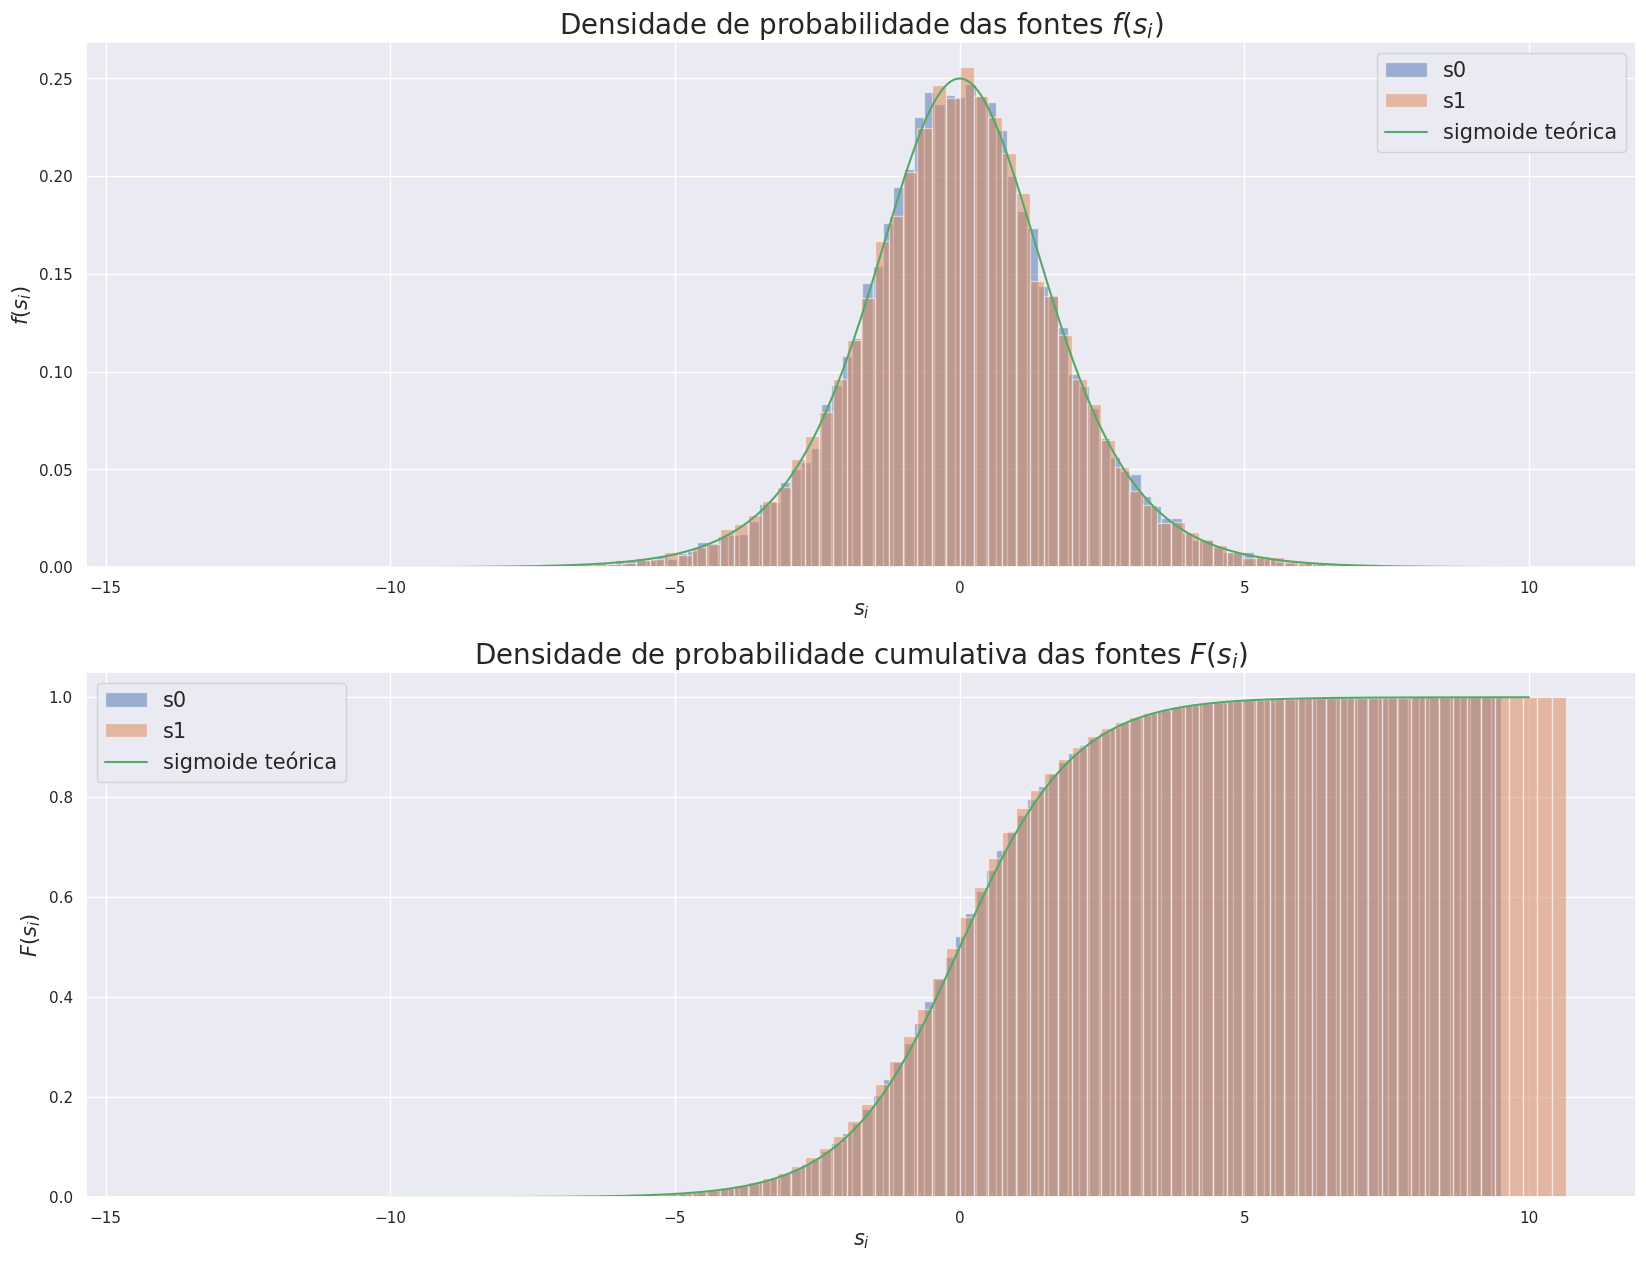

In [5]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)


for i in range(1, NSOURCES+1):
    ax1.hist(
        x=s[i-1,:],
        bins=100,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=s[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    
ax1.plot(
    np.linspace(-10,10,1000),
    [source_pdf(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)


ax2.plot(
    np.linspace(-10,10,1000),
    [source_cumulative(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)

ax1.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(s_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidade de probabilidade das fontes $f(s_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(s_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidade de probabilidade cumulativa das fontes $F(s_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

## 1.2. Mix sources and generate observations

In [6]:
# Mixing matrix
A = np.array([
    [1, 1],
    [-0.5, 0.5]
])
print('MIXING MATRIX A:')
print(A)

MIXING MATRIX A:
[[ 1.   1. ]
 [-0.5  0.5]]


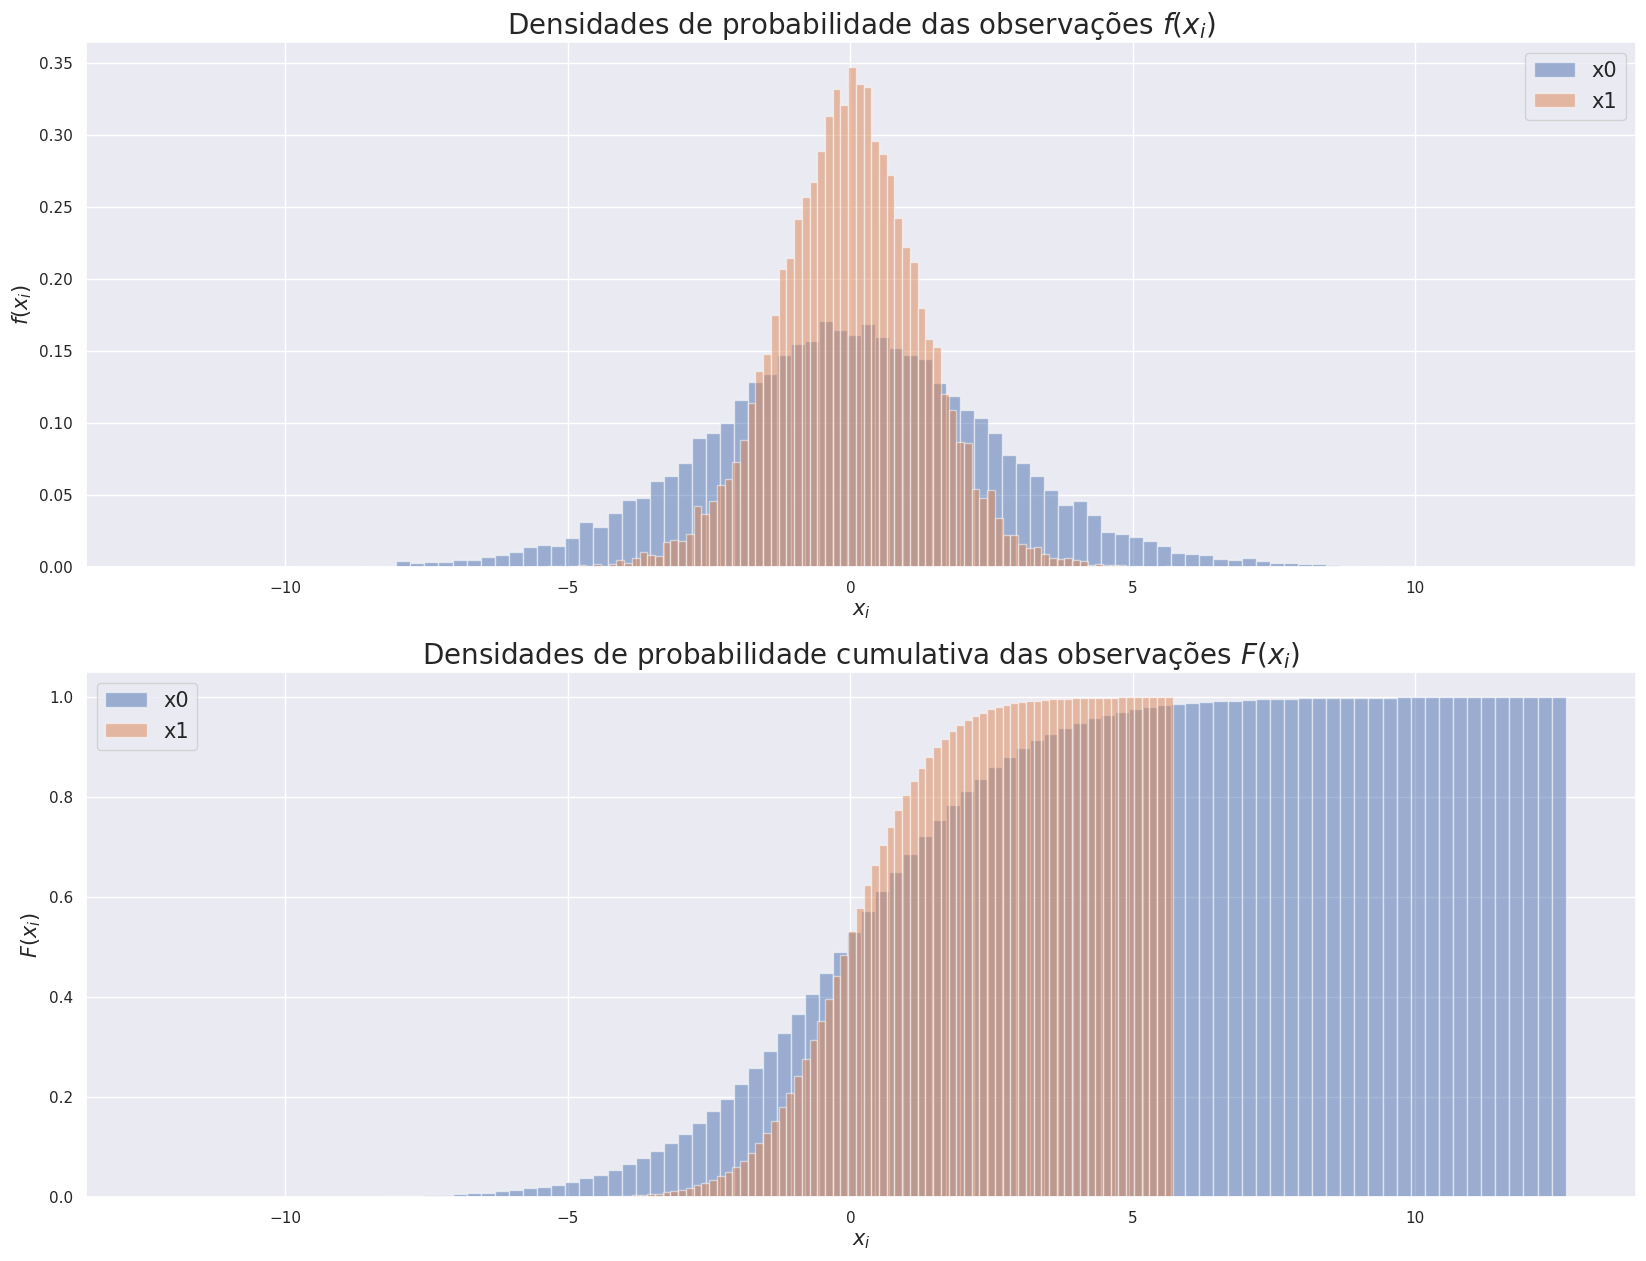

In [7]:
# Observed sources
x = A@s

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

for i in range(1, NSOURCES+1):
    ax1.hist(
        x=x[i-1,:],
        bins=100,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=x[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )

ax1.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(x_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidades de probabilidade das observações $f(x_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(x_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidades de probabilidade cumulativa das observações $F(x_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

## 1.3. Perform Analysis - LIKELIHOOD

### 1.3.1 Execute MCMC Sampling

In [8]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    return 1

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [9]:
%%time

SAVE_PATH='./artifacts/perfect_model_specification/ML.pkl'
if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(estimator, f)

else:
    # Read artifact
    with open(SAVE_PATH, 'rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 2.83 ms, sys: 35.2 ms, total: 38.1 ms
Wall time: 58.5 ms


### 1.3.2. Parse MCMC Results

In [10]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 10
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [11]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.4976208  -1.01101035]
 [ 0.50251113  0.98652182]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [12]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-80053.62176732118,
 -80053.62771851268,
 -80053.6641821671,
 -80053.62884758298,
 -80053.63954653266,
 -80053.66579535099,
 -80053.6347818967,
 -80053.66117714188,
 -80053.63949330601,
 -80053.66922386072,
 -80053.62792769306,
 -80053.68165271882,
 -80053.66679699745,
 -80053.66218317985,
 -80053.642604393,
 -80053.63045777602,
 -80053.63750091536,
 -80053.68035658957,
 -80053.66731434486,
 -80053.65874658164,
 -80053.65259968211,
 -80053.63969074686,
 -80053.62528321242,
 -80053.66084137389,
 -80053.64065935579,
 -80053.62551937235,
 -80053.6571553264,
 -80053.65921134298,
 -80053.67527020484,
 -80053.62007976879]

In [13]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.49887229, -1.00851982],
        [ 0.50118662,  0.98895178]]),
 array([[ 0.50382128,  0.98151498],
        [-0.49550664,  1.01397091]]),
 array([[-0.49799671,  1.00745138],
        [-0.5010159 , -0.98639617]]),
 array([[-0.4972167 ,  1.00887856],
        [-0.50198611, -0.98498732]]),
 array([[ 0.49784351, -1.01058913],
        [ 0.5021261 ,  0.98601377]]),
 array([[-0.50110232, -0.9875734 ],
        [-0.4983943 ,  1.00893615]]),
 array([[ 0.5045328 ,  0.97895154],
        [-0.49467997,  1.0157923 ]]),
 array([[-0.49928032, -0.99131277],
        [ 0.50010964, -1.00431047]]),
 array([[-0.49700153,  1.00885323],
        [-0.50163687, -0.98440507]]),
 array([[-0.49844589,  1.00754199],
        [ 0.5009087 ,  0.98891002]]),
 array([[ 0.4976208 , -1.01101035],
        [ 0.50251113,  0.98652182]]),
 array([[-0.4987387 , -0.99327502],
        [ 0.50084803, -1.00283714]]),
 array([[-0.49826491,  1.00919771],
        [ 0.50147009,  0.98754185]]),
 array([[-0.49737294,  1.01055932],
  

### 1.3.3. Plot sampled coefficients stochastic process - Markov Chain evolution

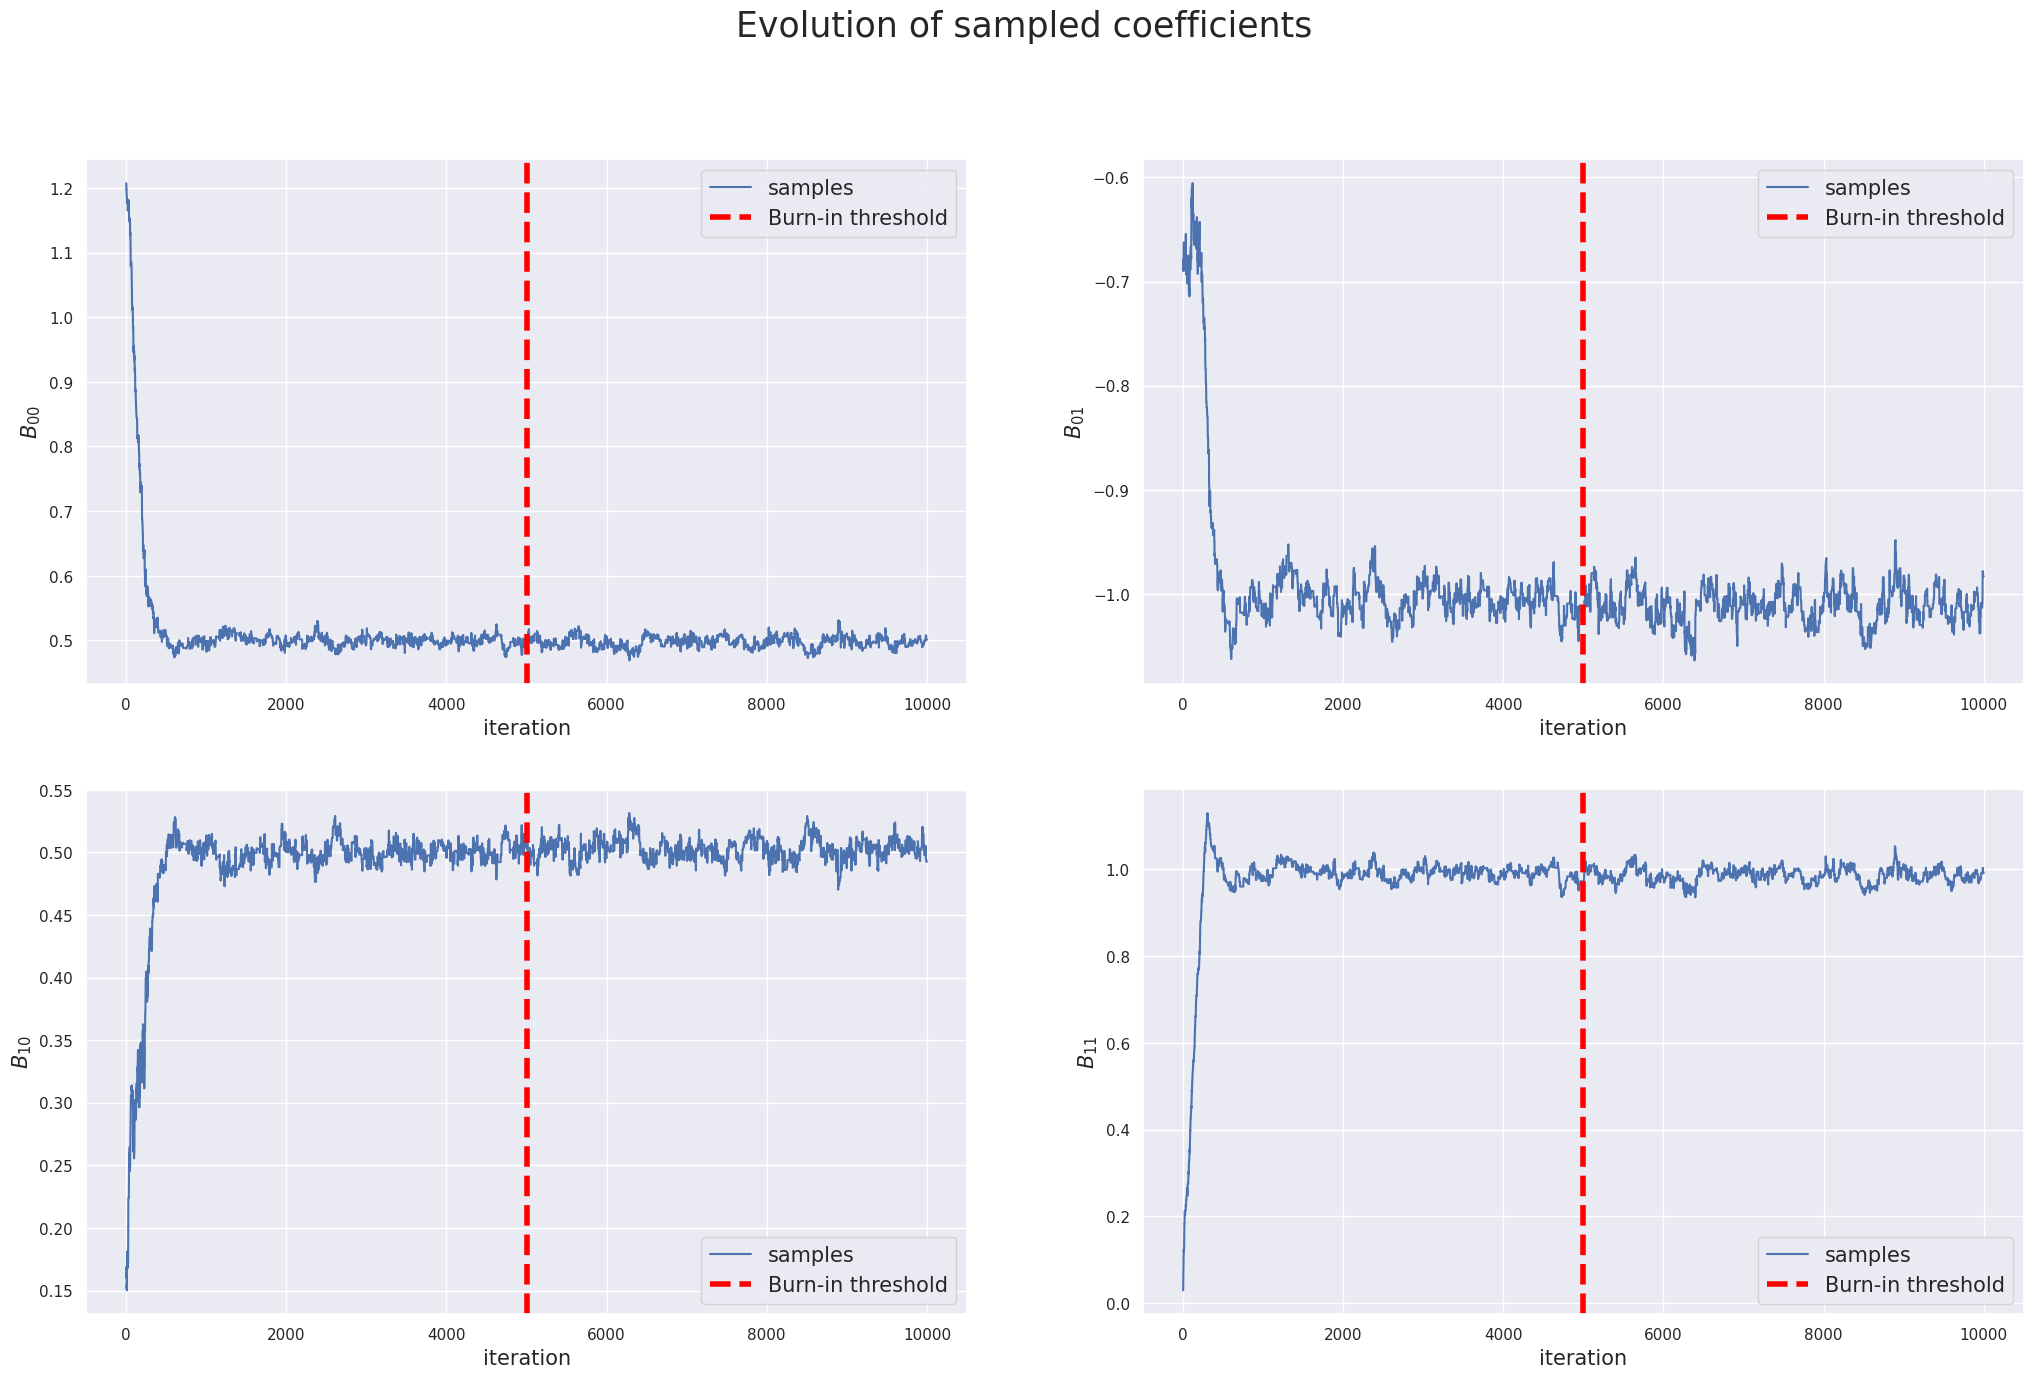

In [14]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of sampled coefficients',
    fontsize=25
)

# B_00
axs[0,0].plot(
    logs.iteration,
    samples[:, 0, 0],
    label='samples'
)
axs[0,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,0].set_ylabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].legend(
    fontsize=15
)

# B_01
axs[0,1].plot(
    logs.iteration,
    samples[:, 0, 1],
    label='samples'
)
axs[0,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].legend(
    fontsize=15
)

# B_10
axs[1,0].plot(
    logs.iteration,
    samples[:, 1, 0],
    label='samples'
)
axs[1,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,0].set_ylabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].legend(
    fontsize=15
)

# B_11
axs[1,1].plot(
    logs.iteration,
    samples[:, 1, 1],
    label='samples'
)
axs[1,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].legend(
    fontsize=15
)

### 1.3.4. Plot sampled coefficients distributions - Markov Chain evolution

<Axes: xlabel='B_11', ylabel='Density'>

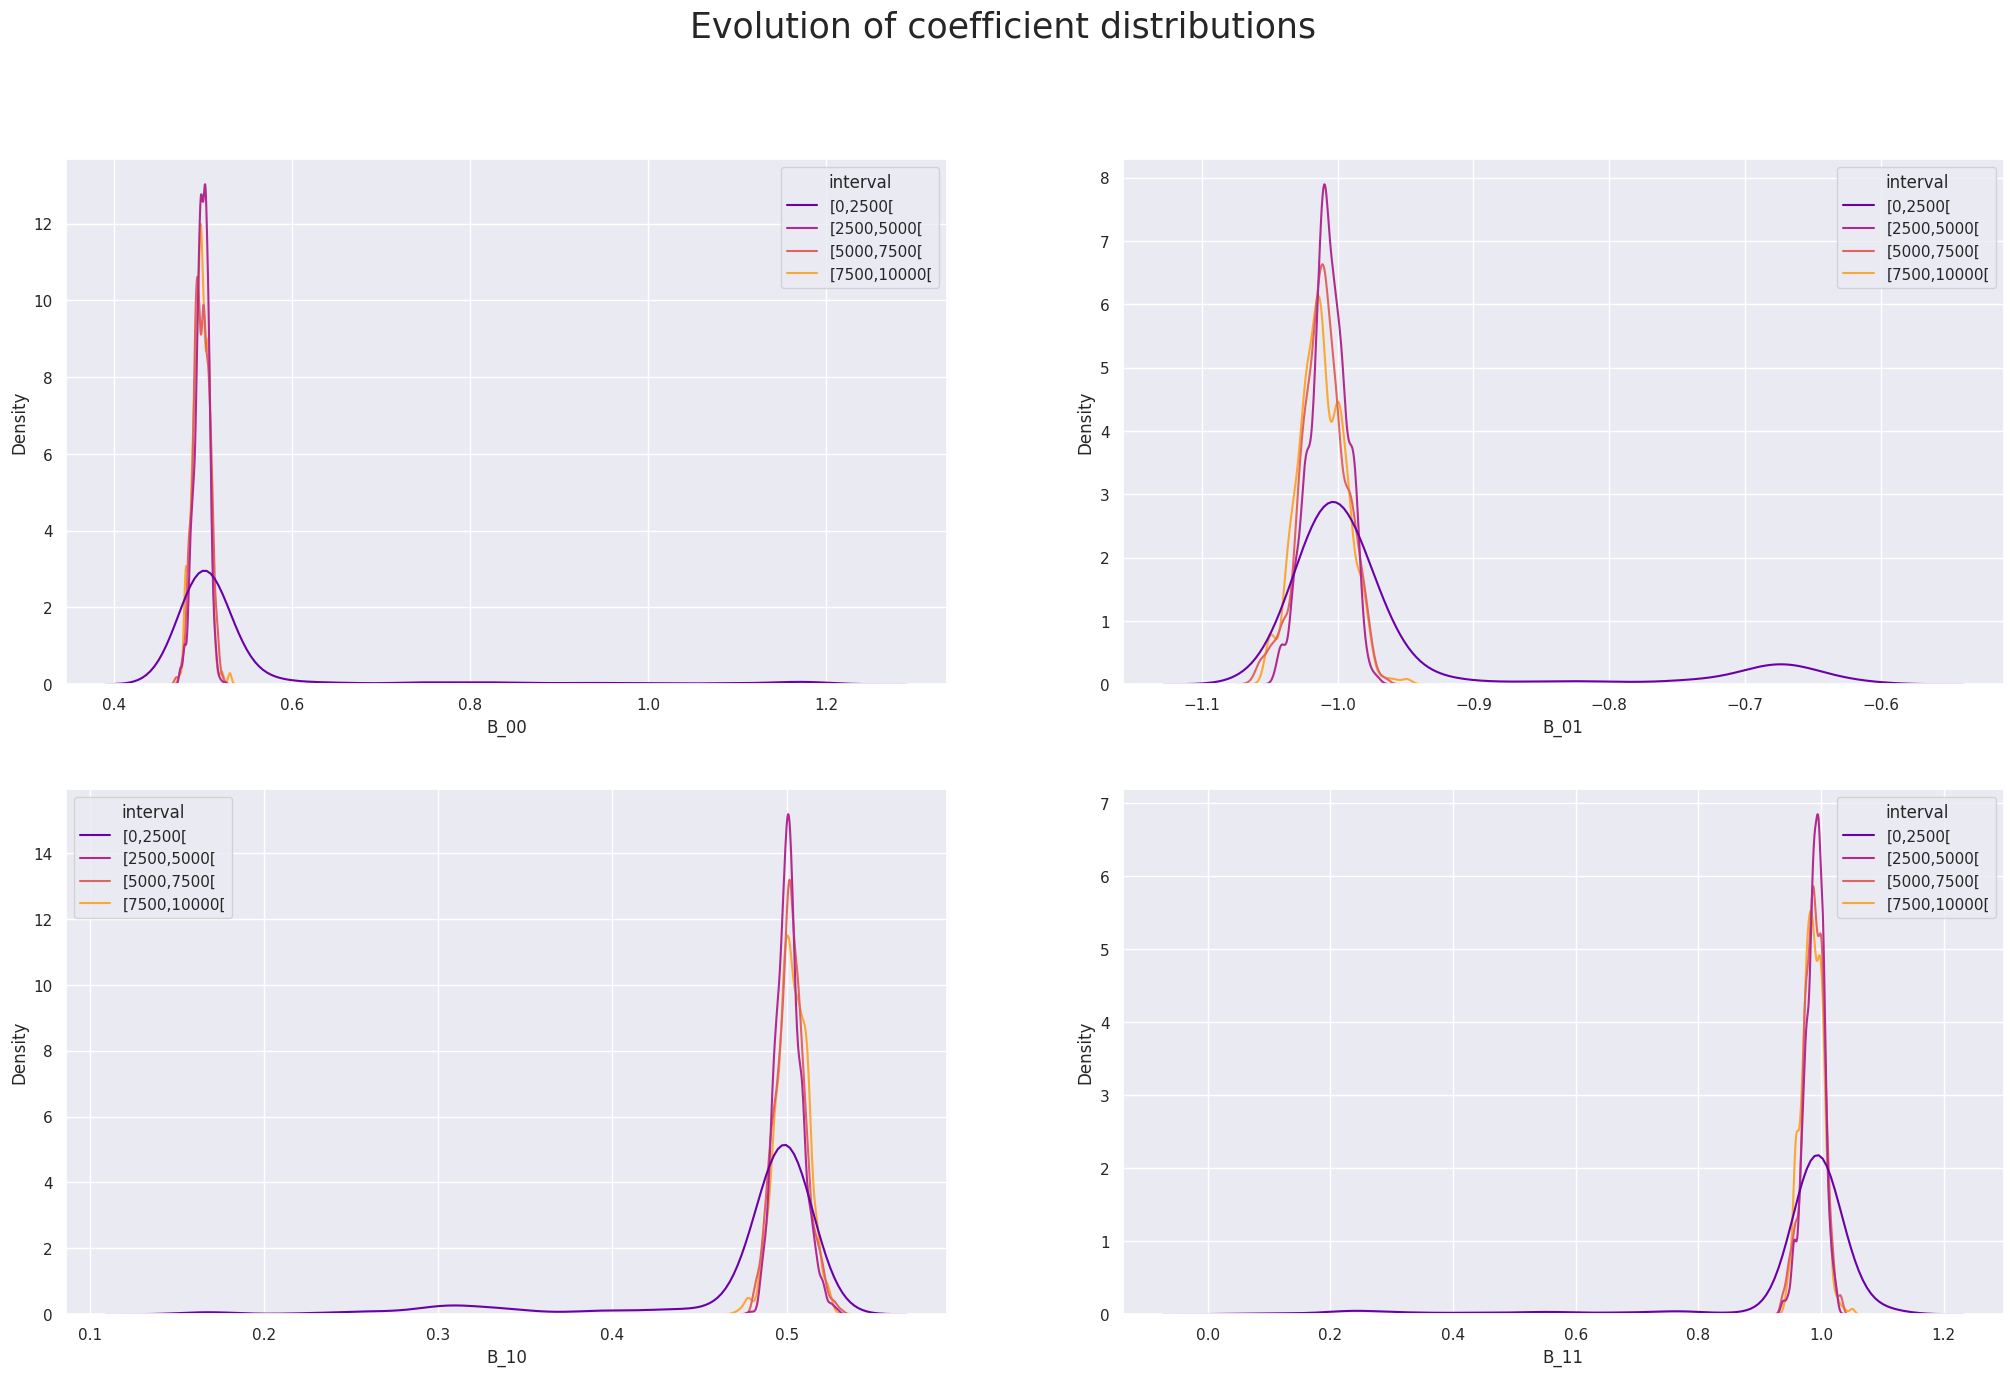

In [15]:
##############################
# Evolution of distributions #
##############################

# Get step size and evaluated points
STEP_SIZE=2500
PALETTE='plasma'

i=0
evaluated_intervals=[]
while i<N_SAMPLES:
    start=i
    end=min(
        i+STEP_SIZE,
        N_SAMPLES
    )
    evaluated_intervals.append(
        (start, end)
    )
    i = i + STEP_SIZE

# Window samples and construct dataframe for plotting
plot_df=pd.DataFrame()
for start, end in evaluated_intervals:
    wdw_df = pd.DataFrame(
        data={
            'interval': ['[{},{}['.format(start, end)]*(end-start)
        }
    )
    wdw_samples = samples[start:end,:,:]
    for i, j in np.ndindex(B_est.shape):
        wdw_df['B_{}{}'.format(i, j)] = wdw_samples[:,i,j]

    plot_df = pd.concat(
        [
            plot_df,
            wdw_df
        ],
        axis=0
    ).reset_index(
        drop=True
    )

# Plot coefficient distribution evolution
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of coefficient distributions',
    fontsize=25
)

# B_00
sns.kdeplot(
    data=plot_df,
    x='B_00',
    hue='interval',
    ax=axs[0,0],
    palette=PALETTE
)

# B_01
sns.kdeplot(
    data=plot_df,
    x='B_01',
    hue='interval',
    ax=axs[0,1],
    palette=PALETTE
)

# B_10
sns.kdeplot(
    data=plot_df,
    x='B_10',
    hue='interval',
    ax=axs[1,0],
    palette=PALETTE
)

# B_11
sns.kdeplot(
    data=plot_df,
    x='B_11',
    hue='interval',
    ax=axs[1,1],
    palette=PALETTE
)

### 1.3.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

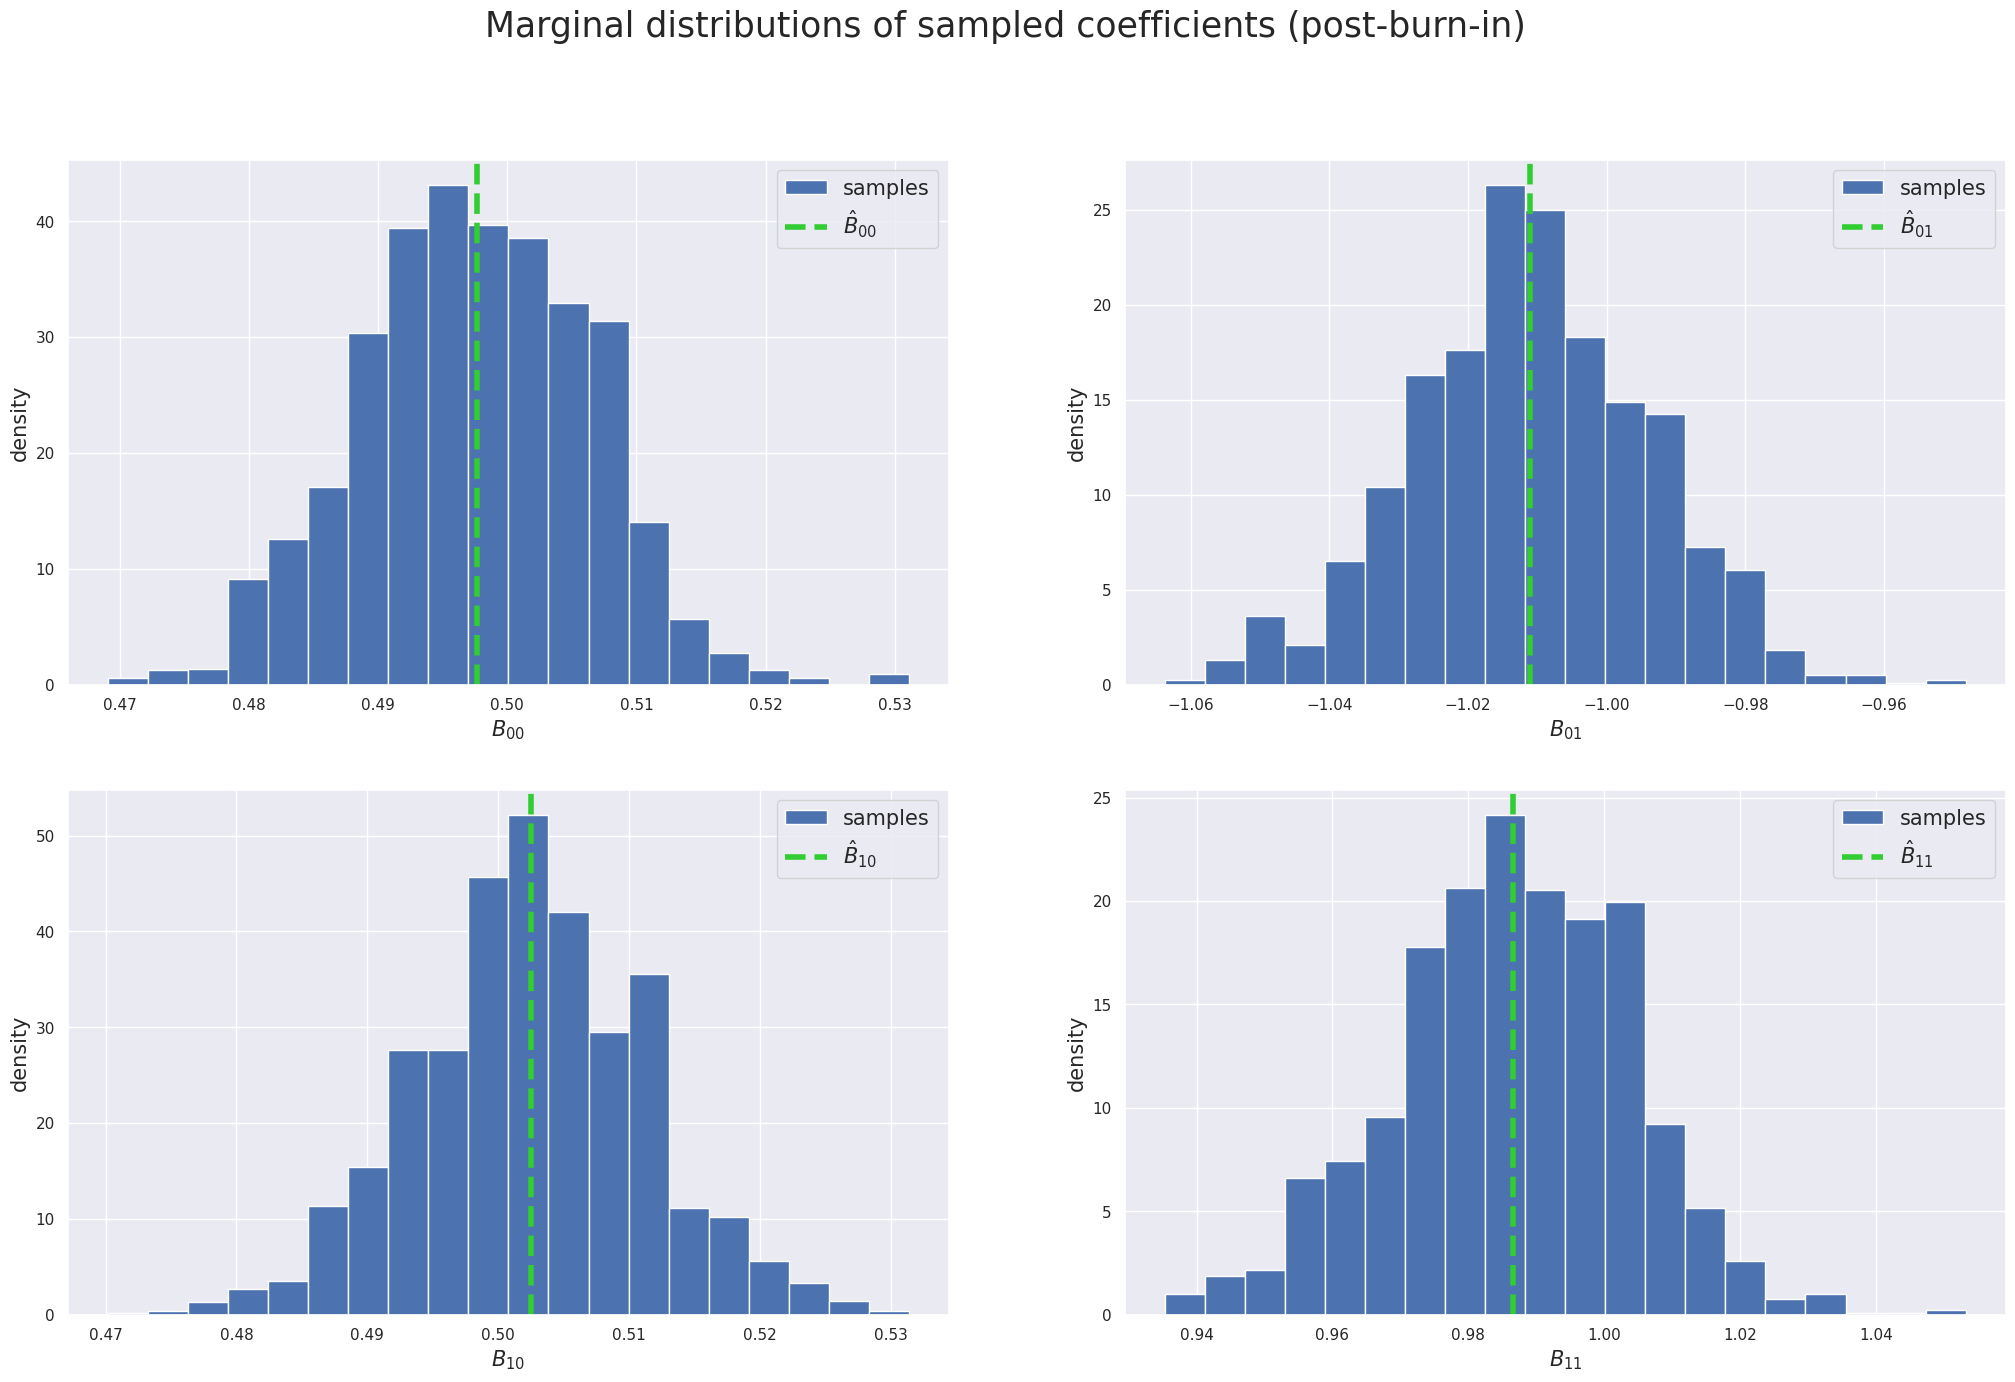

In [16]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Marginal distributions of sampled coefficients (post-burn-in)',
    fontsize=25
)

# B_00
axs[0,0].hist(
    valid_samples[:, 0, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,0].axvline(
    B_est[0, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{00}$'
)
axs[0,0].set_xlabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].set_ylabel(
    'density',
    fontsize=15
)
axs[0,0].legend(
    loc='upper right',
    fontsize=15
)


# B_01
axs[0,1].hist(
    valid_samples[:, 0, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,1].axvline(
    B_est[0, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{01}$'
)
axs[0,1].set_xlabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    'density',
    fontsize=15
)
axs[0,1].legend(
    loc='upper right',
    fontsize=15
)

# B_10
axs[1,0].hist(
    valid_samples[:, 1, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,0].axvline(
    B_est[1, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{10}$'
)
axs[1,0].set_xlabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].set_ylabel(
    'density',
    fontsize=15
)
axs[1,0].legend(
    loc='upper right',
    fontsize=15
)

# B_11
axs[1,1].hist(
    valid_samples[:, 1, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,1].axvline(
    B_est[1, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{11}$'
)
axs[1,1].set_xlabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    'density',
    fontsize=15
)
axs[1,1].legend(
    loc='upper right',
    fontsize=15
)

### 1.3.6. Plot evolution of log-posterior

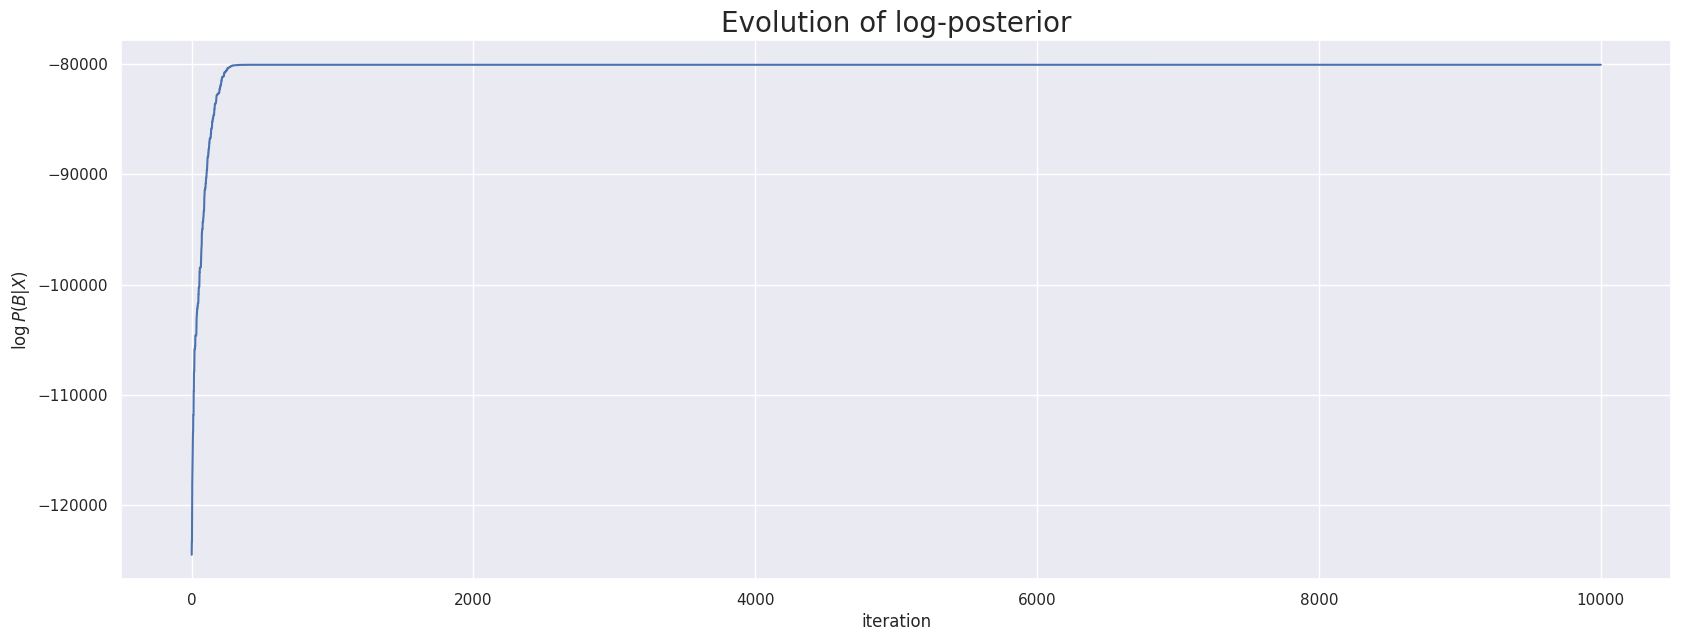

In [17]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posterior'
)
plt.ylabel(
    '$\log P(B|X)$'
)
t = plt.title(
    'Evolution of log-posterior',
    fontsize=20
)

Text(0.5, 1.0, 'Scatter plot - true values and estimates - coefficient s1')

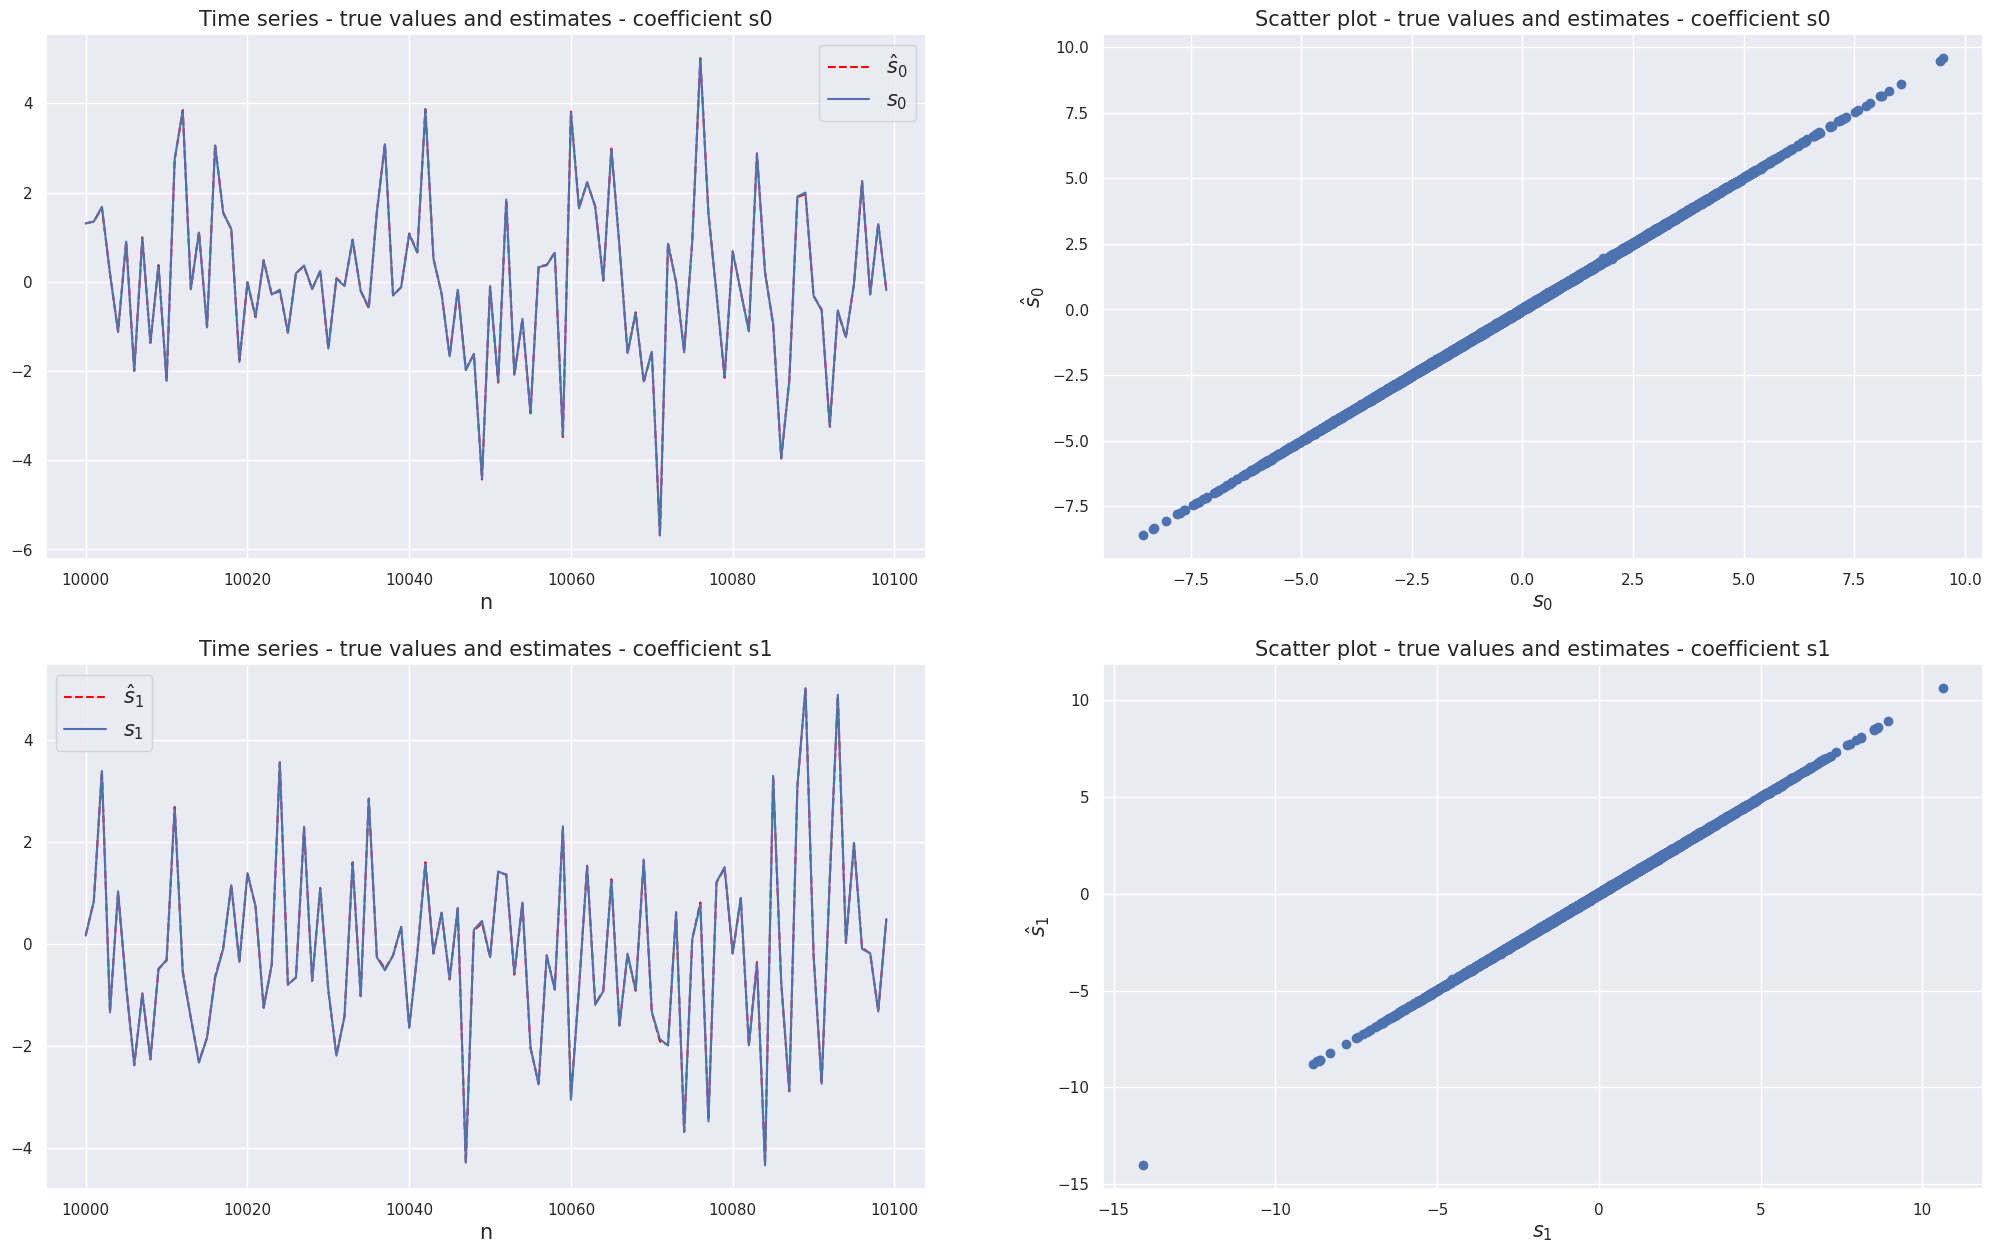

In [18]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B_est@x

# Axs 00
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
axs[0,0].set_xlabel(
    'n',
    fontsize=15
)
axs[0,0].set_title(
    'Time series - true values and estimates - coefficient s0',
    fontsize=15
)
axs[0,0].legend(fontsize=15)

# Axs 01
axs[0,1].scatter(
    s[0,:],
    s_est[0,:],
)
axs[0,1].set_xlabel(
    '$s_{0}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$\hat{s}_{0}$',
    fontsize=15
)
axs[0,1].set_title(
    'Scatter plot - true values and estimates - coefficient s0',
    fontsize=15
)

# Axs 10
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
axs[1,0].set_xlabel(
    'n',
    fontsize=15
)
axs[1,0].set_title(
    'Time series - true values and estimates - coefficient s1',
    fontsize=15
)
axs[1,0].legend(fontsize=15)

# Axs 11
axs[1,1].scatter(
    s[1,:],
    s_est[1,:],
)
axs[1,1].set_xlabel(
    '$s_{1}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$\hat{s}_{1}$',
    fontsize=15
)
axs[1,1].set_title(
    'Scatter plot - true values and estimates - coefficient s1',
    fontsize=15
)

In [19]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['perfect_model']['likelihood'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 8.505339686882418e-05


## 1.4. Perform Analysis - DETERMINANT PRIOR
#### Prior:
$p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} (det(\boldsymbol{B}) - 1)^2 \right]$

### 1.4.1 Execute MCMC Sampling

In [20]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    sig=0.1
    desired_det=1
    return (1/np.sqrt(2*np.pi*np.square(sig)))*np.exp(-np.square(np.linalg.det(B)-desired_det)/(2*np.square(sig)))

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [21]:
%%time

SAVE_PATH='./artifacts/perfect_model_specification/Det_1.pkl'
if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(estimator, f)

else:
    # Read artifact
    with open(SAVE_PATH, 'rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 56.5 ms, sys: 84.6 ms, total: 141 ms
Wall time: 52.7 ms


### 1.4.2. Parse MCMC Results

In [22]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 10
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [23]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.49823137 -1.00835393]
 [ 0.50082768  0.98728813]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [24]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-80053.62198666103,
 -80053.6560283316,
 -80053.63479940686,
 -80053.6692306573,
 -80053.66856872477,
 -80053.64885441509,
 -80053.62319403842,
 -80053.64579885082,
 -80053.6448504387,
 -80053.65316098626,
 -80053.63910514698,
 -80053.63317773843,
 -80053.65139390495,
 -80053.64441802833,
 -80053.65992297367,
 -80053.6454872476,
 -80053.65832264179,
 -80053.64566474588,
 -80053.62928373022,
 -80053.66562880499,
 -80053.63979600939,
 -80053.66348012764,
 -80053.6176018086,
 -80053.64824280233,
 -80053.64248010905,
 -80053.65862628096,
 -80053.62625650062,
 -80053.64300021685,
 -80053.62217157963,
 -80053.65778670384]

In [25]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.49791773, -1.00930154],
        [ 0.50159952,  0.98675452]]),
 array([[ 0.49736415, -1.00929174],
        [ 0.50200281,  0.98563656]]),
 array([[-0.49898956,  1.00609368],
        [-0.50040662, -0.98904064]]),
 array([[-0.49668826,  1.01015762],
        [-0.50213839, -0.98473299]]),
 array([[-0.50156263, -0.98650674],
        [ 0.49784349, -1.00876878]]),
 array([[-0.50139681, -0.98735513],
        [-0.49794503,  1.00820602]]),
 array([[ 0.50306919,  0.98339683],
        [-0.49618533,  1.01168936]]),
 array([[-0.5010089 , -0.98800635],
        [ 0.49834142, -1.008267  ]]),
 array([[-0.49654668,  1.0110691 ],
        [-0.50292954, -0.98351458]]),
 array([[ 0.49874077, -1.00635062],
        [ 0.50035705,  0.98896382]]),
 array([[ 0.49823137, -1.00835393],
        [ 0.50082768,  0.98728813]]),
 array([[-0.50242084, -0.98455533],
        [ 0.497123  , -1.01042858]]),
 array([[-0.50028031,  1.00462945],
        [ 0.49941795,  0.99148902]]),
 array([[-0.49850753,  1.00820614],
  

### 1.4.3. Plot sampled coefficients stochastic process - Markov Chain evolution

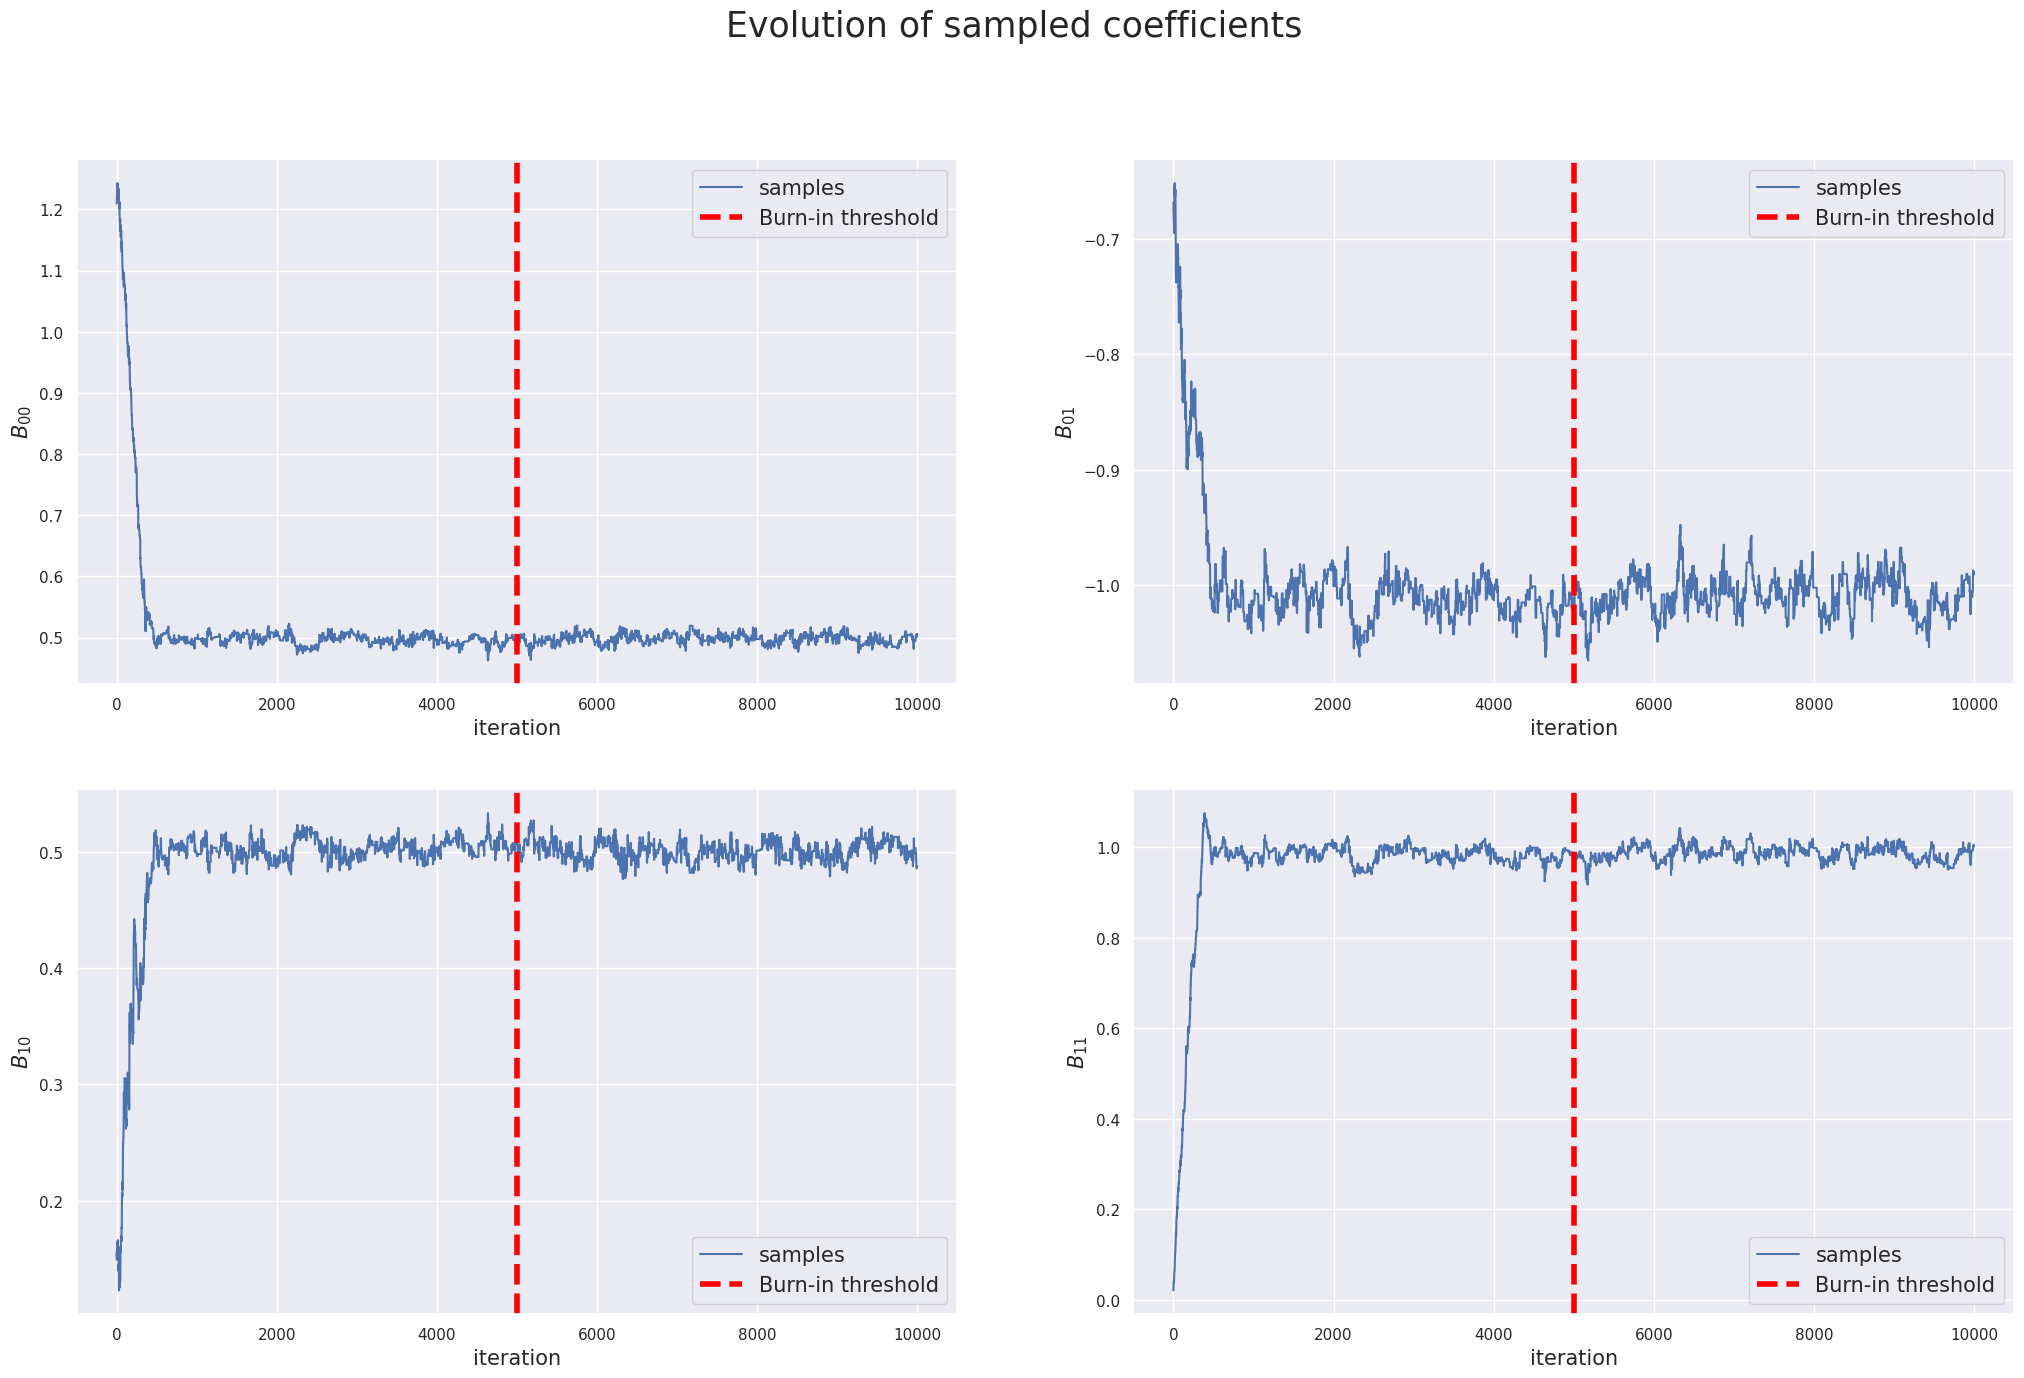

In [26]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of sampled coefficients',
    fontsize=25
)

# B_00
axs[0,0].plot(
    logs.iteration,
    samples[:, 0, 0],
    label='samples'
)
axs[0,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,0].set_ylabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].legend(
    fontsize=15
)

# B_01
axs[0,1].plot(
    logs.iteration,
    samples[:, 0, 1],
    label='samples'
)
axs[0,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].legend(
    fontsize=15
)

# B_10
axs[1,0].plot(
    logs.iteration,
    samples[:, 1, 0],
    label='samples'
)
axs[1,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,0].set_ylabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].legend(
    fontsize=15
)

# B_11
axs[1,1].plot(
    logs.iteration,
    samples[:, 1, 1],
    label='samples'
)
axs[1,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].legend(
    fontsize=15
)

### 1.4.4. Plot sampled coefficients distributions - Markov Chain evolution

<Axes: xlabel='B_11', ylabel='Density'>

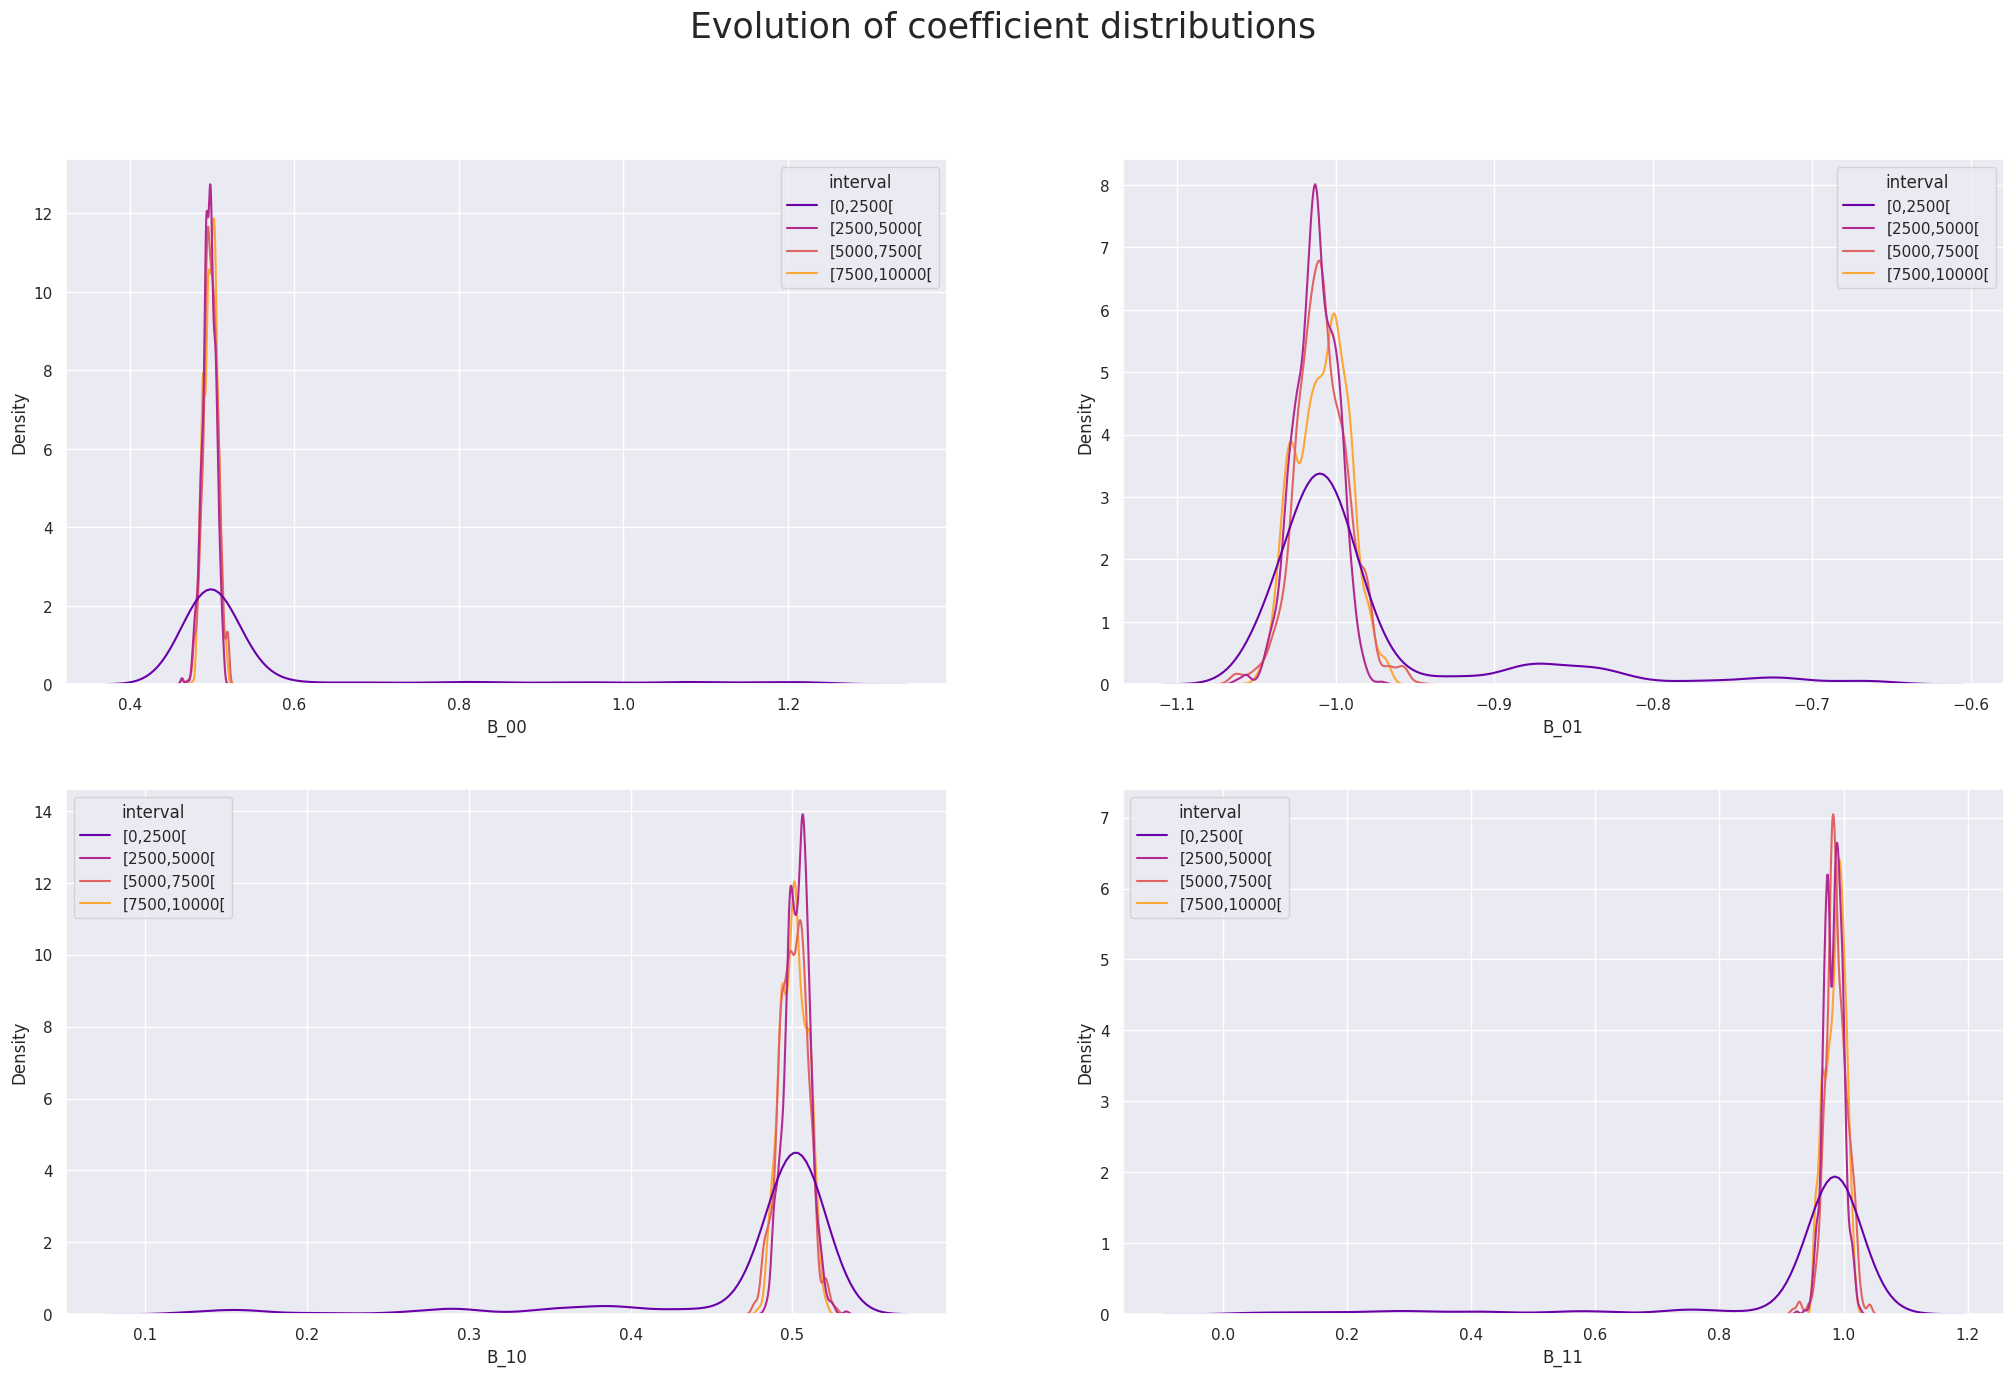

In [27]:
##############################
# Evolution of distributions #
##############################

# Get step size and evaluated points
STEP_SIZE=2500
PALETTE='plasma'

i=0
evaluated_intervals=[]
while i<N_SAMPLES:
    start=i
    end=min(
        i+STEP_SIZE,
        N_SAMPLES
    )
    evaluated_intervals.append(
        (start, end)
    )
    i = i + STEP_SIZE

# Window samples and construct dataframe for plotting
plot_df=pd.DataFrame()
for start, end in evaluated_intervals:
    wdw_df = pd.DataFrame(
        data={
            'interval': ['[{},{}['.format(start, end)]*(end-start)
        }
    )
    wdw_samples = samples[start:end,:,:]
    for i, j in np.ndindex(B_est.shape):
        wdw_df['B_{}{}'.format(i, j)] = wdw_samples[:,i,j]

    plot_df = pd.concat(
        [
            plot_df,
            wdw_df
        ],
        axis=0
    ).reset_index(
        drop=True
    )

# Plot coefficient distribution evolution
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of coefficient distributions',
    fontsize=25
)

# B_00
sns.kdeplot(
    data=plot_df,
    x='B_00',
    hue='interval',
    ax=axs[0,0],
    palette=PALETTE
)

# B_01
sns.kdeplot(
    data=plot_df,
    x='B_01',
    hue='interval',
    ax=axs[0,1],
    palette=PALETTE
)

# B_10
sns.kdeplot(
    data=plot_df,
    x='B_10',
    hue='interval',
    ax=axs[1,0],
    palette=PALETTE
)

# B_11
sns.kdeplot(
    data=plot_df,
    x='B_11',
    hue='interval',
    ax=axs[1,1],
    palette=PALETTE
)

### 1.4.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

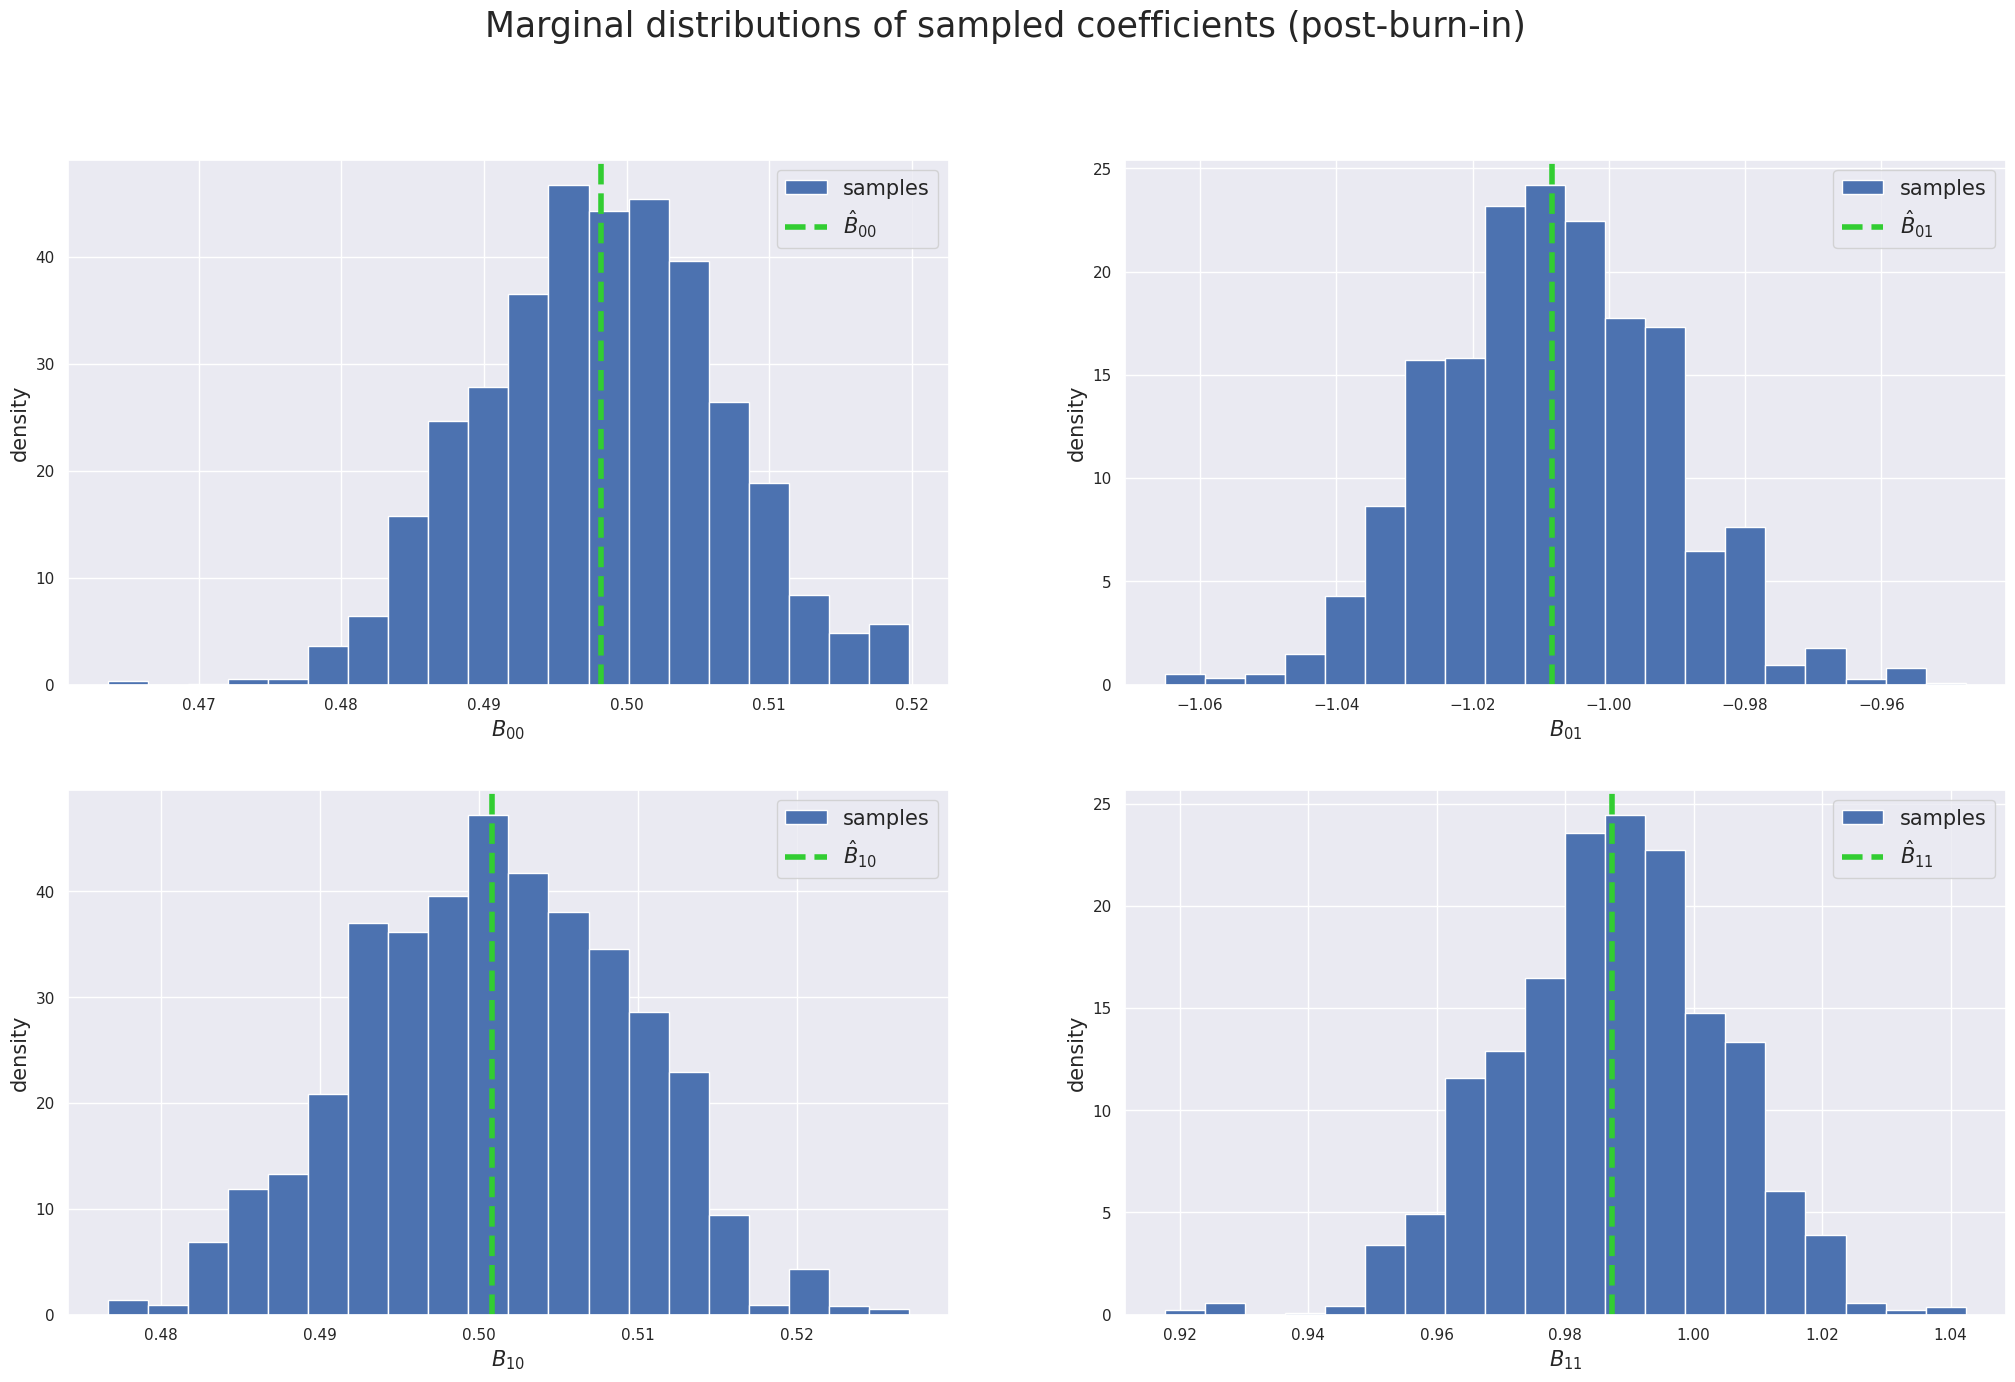

In [28]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Marginal distributions of sampled coefficients (post-burn-in)',
    fontsize=25
)

# B_00
axs[0,0].hist(
    valid_samples[:, 0, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,0].axvline(
    B_est[0, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{00}$'
)
axs[0,0].set_xlabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].set_ylabel(
    'density',
    fontsize=15
)
axs[0,0].legend(
    loc='upper right',
    fontsize=15
)


# B_01
axs[0,1].hist(
    valid_samples[:, 0, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,1].axvline(
    B_est[0, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{01}$'
)
axs[0,1].set_xlabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    'density',
    fontsize=15
)
axs[0,1].legend(
    loc='upper right',
    fontsize=15
)

# B_10
axs[1,0].hist(
    valid_samples[:, 1, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,0].axvline(
    B_est[1, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{10}$'
)
axs[1,0].set_xlabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].set_ylabel(
    'density',
    fontsize=15
)
axs[1,0].legend(
    loc='upper right',
    fontsize=15
)

# B_11
axs[1,1].hist(
    valid_samples[:, 1, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,1].axvline(
    B_est[1, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{11}$'
)
axs[1,1].set_xlabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    'density',
    fontsize=15
)
axs[1,1].legend(
    loc='upper right',
    fontsize=15
)

### 1.4.6. Plot evolution of log-posterior

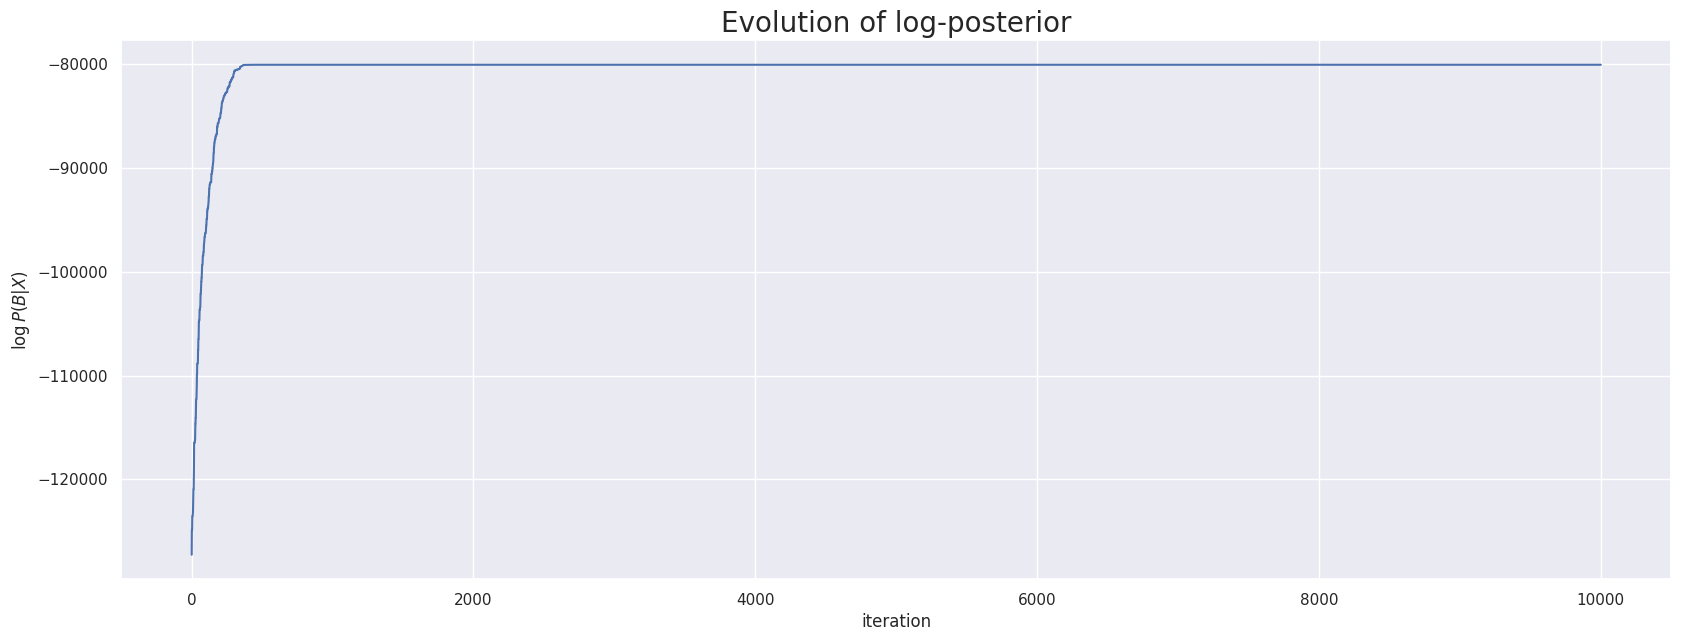

In [29]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posterior'
)
plt.ylabel(
    '$\log P(B|X)$'
)
t = plt.title(
    'Evolution of log-posterior',
    fontsize=20
)

### 1.4.7. Plot Source Separation Results

Text(0.5, 1.0, 'Scatter plot - true values and estimates - coefficient s1')

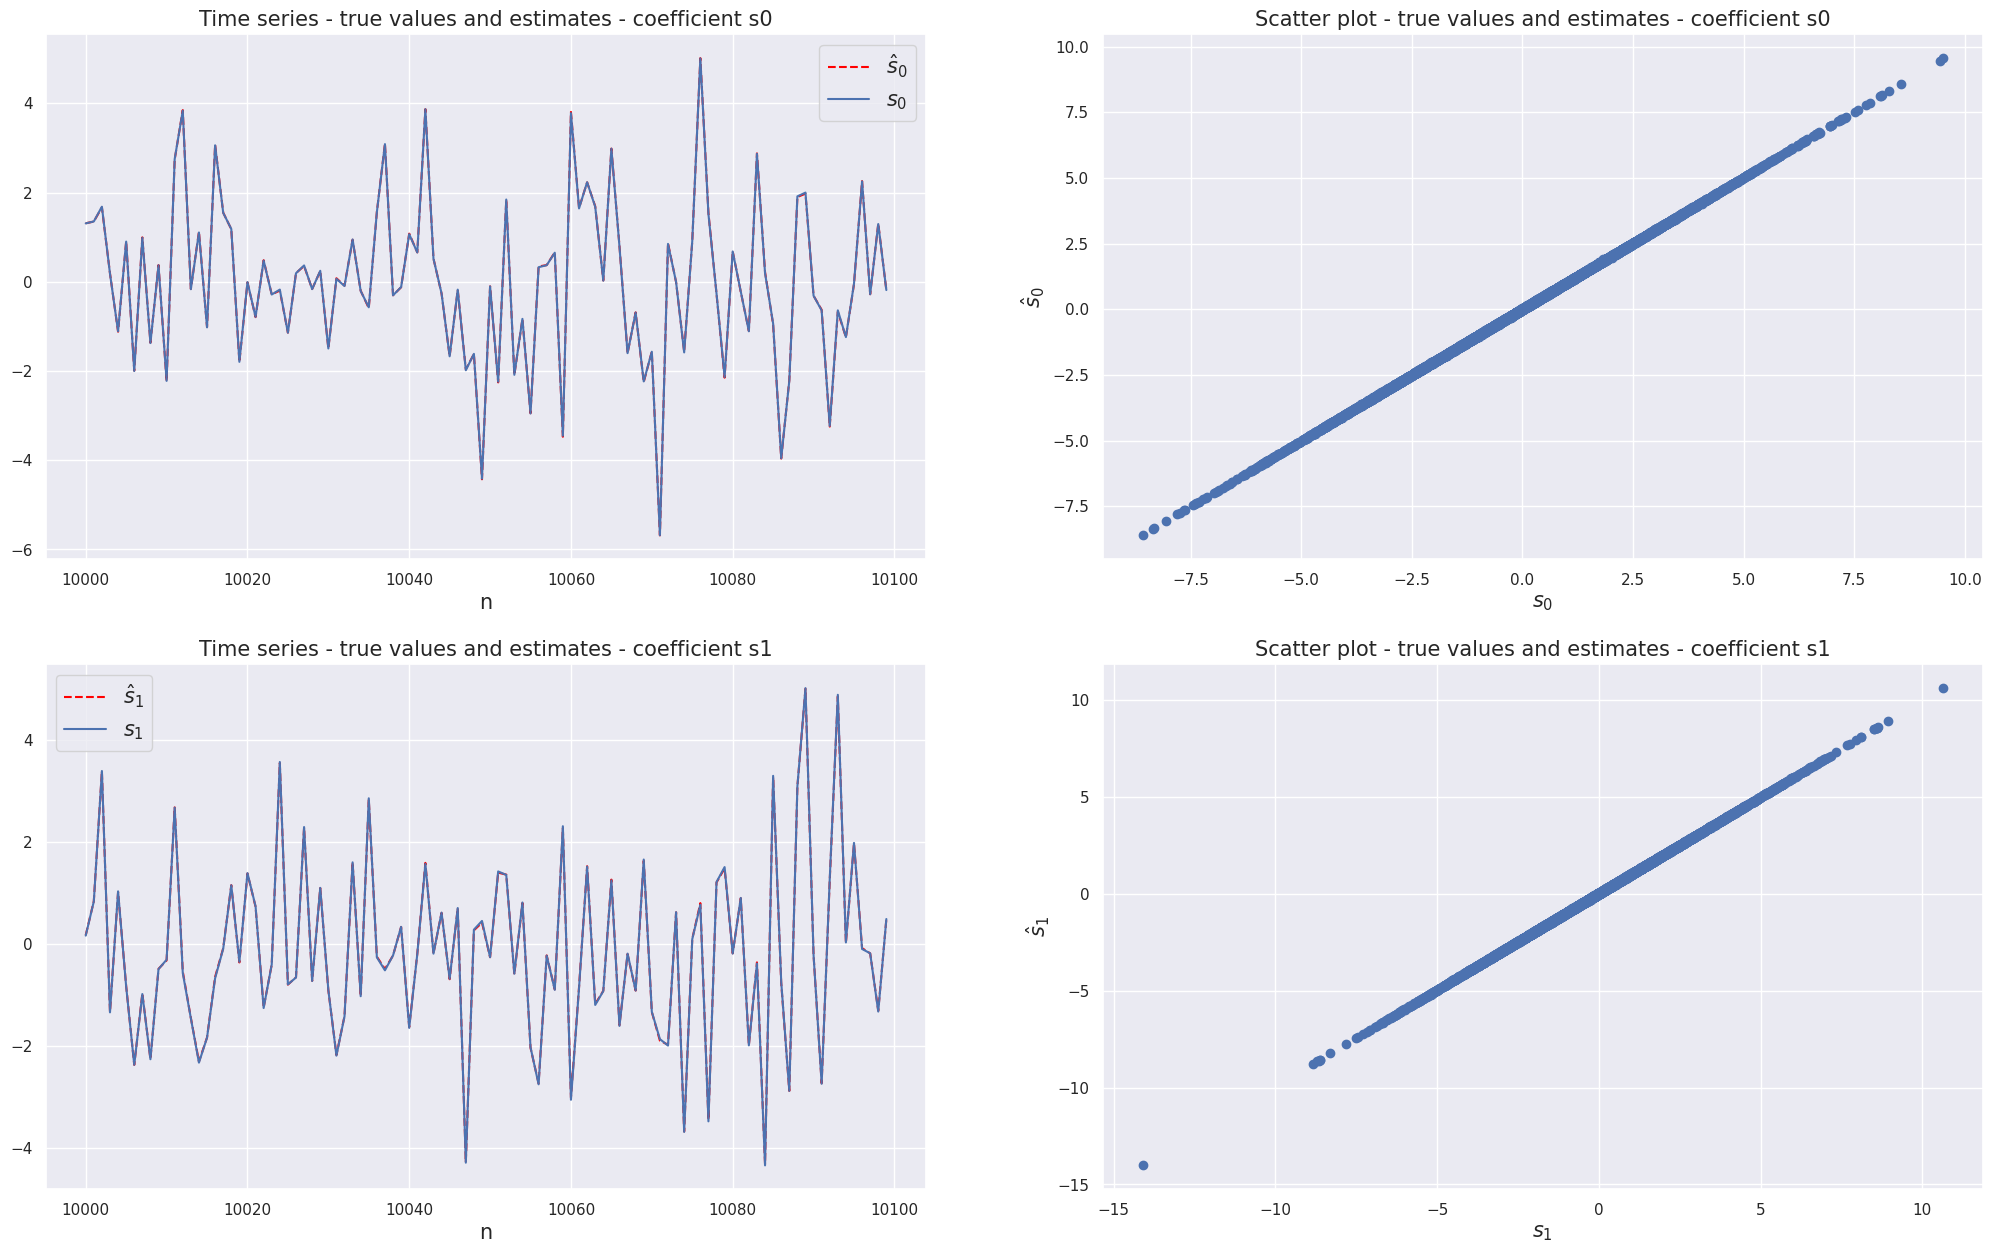

In [30]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B_est@x

# Axs 00
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
axs[0,0].set_xlabel(
    'n',
    fontsize=15
)
axs[0,0].set_title(
    'Time series - true values and estimates - coefficient s0',
    fontsize=15
)
axs[0,0].legend(fontsize=15)

# Axs 01
axs[0,1].scatter(
    s[0,:],
    s_est[0,:],
)
axs[0,1].set_xlabel(
    '$s_{0}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$\hat{s}_{0}$',
    fontsize=15
)
axs[0,1].set_title(
    'Scatter plot - true values and estimates - coefficient s0',
    fontsize=15
)

# Axs 10
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
axs[1,0].set_xlabel(
    'n',
    fontsize=15
)
axs[1,0].set_title(
    'Time series - true values and estimates - coefficient s1',
    fontsize=15
)
axs[1,0].legend(fontsize=15)

# Axs 11
axs[1,1].scatter(
    s[1,:],
    s_est[1,:],
)
axs[1,1].set_xlabel(
    '$s_{1}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$\hat{s}_{1}$',
    fontsize=15
)
axs[1,1].set_title(
    'Scatter plot - true values and estimates - coefficient s1',
    fontsize=15
)

In [31]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['perfect_model']['determinant_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 7.138954695596025e-05


## 1.5. Perform Analysis - near-identity transformation
#### Prior:
#### $p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} ||\boldsymbol{B} - \boldsymbol{I}||^2 \right]$

### 1.5.1 Execute MCMC Sampling

In [32]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(X):
    sig=0.1
    return np.exp(
        (-1/2/np.square(sig))*np.linalg.norm(X-np.eye(X.shape[0]))
    )

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [33]:
%%time

SAVE_PATH='./artifacts/perfect_model_specification/identity.pkl'
if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(estimator, f)

else:
    # Read artifact
    with open(SAVE_PATH, 'rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 91.3 ms, sys: 110 ms, total: 201 ms
Wall time: 49.7 ms


### 1.5.2. Parse MCMC Results

In [86]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 10
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [87]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.45251059 -0.91540907]
 [ 0.45437906  0.91222048]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [88]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-83724.49558604587,
 -83724.59837249646,
 -83724.49484134465,
 -83724.49586851447,
 -83724.46811382515,
 -83724.4750293591,
 -83724.5334430139,
 -83724.50387179336,
 -83724.52935962827,
 -83724.49498823544,
 -83724.49071779985,
 -83724.5472297324,
 -83724.59851292803,
 -83724.483398337,
 -83724.50741074413,
 -83724.55102410576,
 -83724.47346552617,
 -83724.46940351216,
 -83724.50776202766,
 -83724.5359672211,
 -83724.52155651816,
 -83724.6081123812,
 -83724.51774511425,
 -83724.5334000749,
 -83724.48938155672,
 -83724.49787423045,
 -83724.51978652667,
 -83724.50665006555,
 -83724.53558554925,
 -83724.50011075655]

In [89]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.45423304, -0.9122111 ],
        [ 0.45309519,  0.91566496]]),
 array([[ 0.45486073, -0.91165164],
        [ 0.45260997,  0.91601045]]),
 array([[-0.45328379,  0.91537718],
        [-0.45397076, -0.91250355]]),
 array([[ 0.45394612,  0.91376819],
        [-0.4533006 ,  0.91563288]]),
 array([[-0.454698  , -0.91131233],
        [ 0.45253267, -0.91623376]]),
 array([[ 0.45517118, -0.91039763],
        [-0.4518512 , -0.91696915]]),
 array([[ 0.45558859,  0.90894715],
        [-0.45157031,  0.91827936]]),
 array([[-0.45159976, -0.9174149 ],
        [ 0.45530087, -0.91027444]]),
 array([[-0.45380654,  0.91329982],
        [-0.45333394, -0.91401594]]),
 array([[-0.45538   , -0.90939841],
        [-0.45214857,  0.91733804]]),
 array([[ 0.45251059, -0.91540907],
        [ 0.45437906,  0.91222048]]),
 array([[-0.45274446, -0.91580309],
        [ 0.45443893, -0.91248928]]),
 array([[-0.45409849,  0.91265865],
        [ 0.45293487,  0.91517629]]),
 array([[-0.45305376,  0.9145045 ],
  

### 1.5.3. Plot sampled coefficients stochastic process - Markov Chain evolution

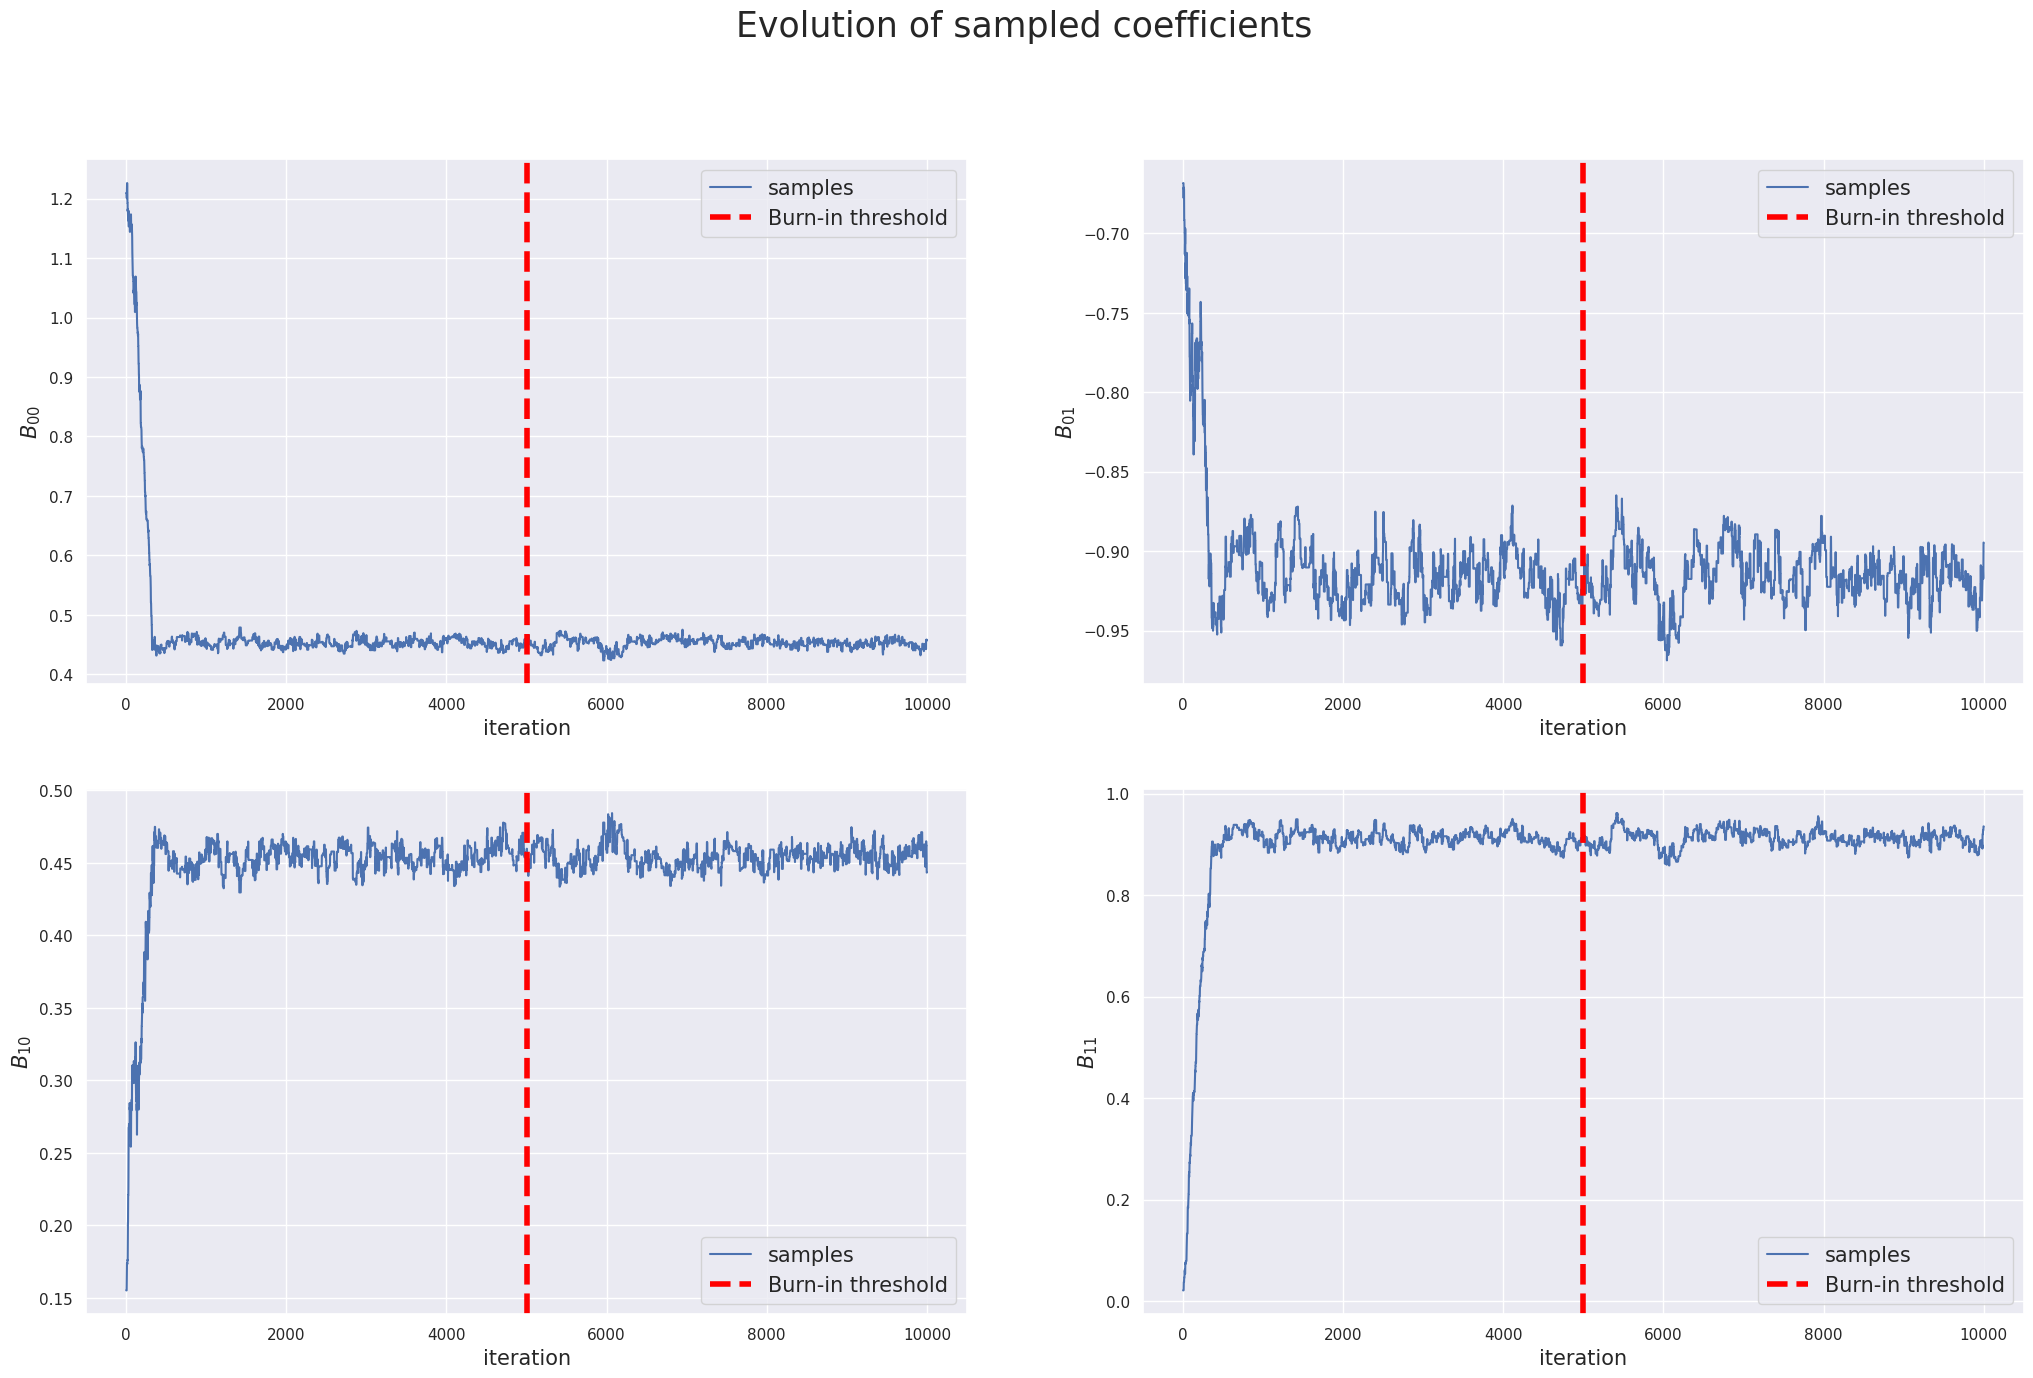

In [90]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of sampled coefficients',
    fontsize=25
)

# B_00
axs[0,0].plot(
    logs.iteration,
    samples[:, 0, 0],
    label='samples'
)
axs[0,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,0].set_ylabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].legend(
    fontsize=15
)

# B_01
axs[0,1].plot(
    logs.iteration,
    samples[:, 0, 1],
    label='samples'
)
axs[0,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].legend(
    fontsize=15
)

# B_10
axs[1,0].plot(
    logs.iteration,
    samples[:, 1, 0],
    label='samples'
)
axs[1,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,0].set_ylabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].legend(
    fontsize=15
)

# B_11
axs[1,1].plot(
    logs.iteration,
    samples[:, 1, 1],
    label='samples'
)
axs[1,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].legend(
    fontsize=15
)

### 1.5.4. Plot sampled coefficients distributions - Markov Chain evolution

<Axes: xlabel='B_11', ylabel='Density'>

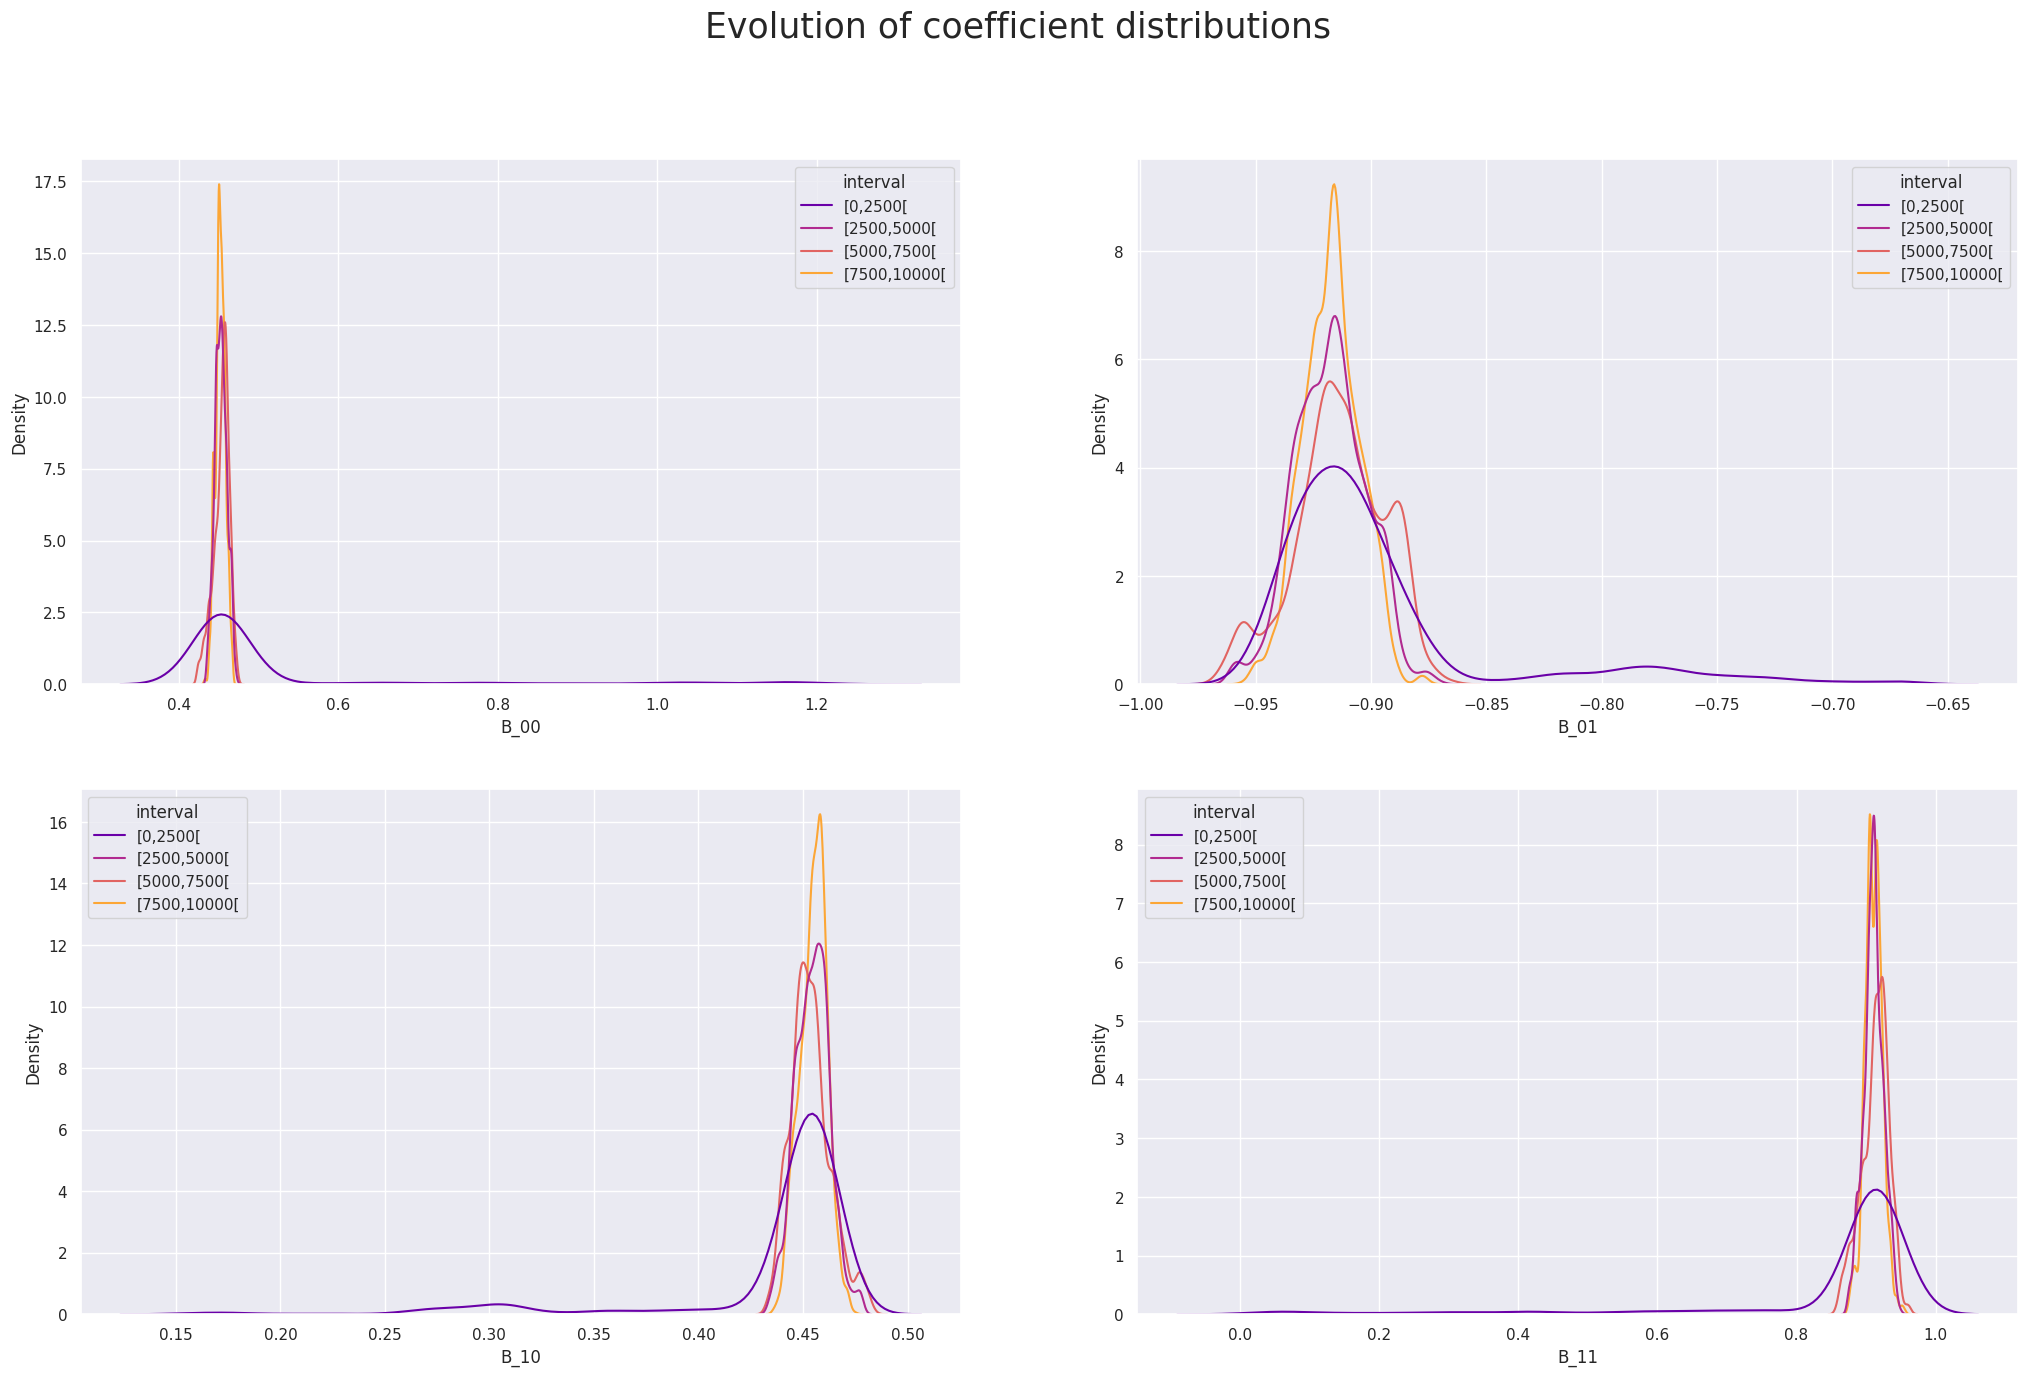

In [91]:
##############################
# Evolution of distributions #
##############################

# Get step size and evaluated points
STEP_SIZE=2500
PALETTE='plasma'

i=0
evaluated_intervals=[]
while i<N_SAMPLES:
    start=i
    end=min(
        i+STEP_SIZE,
        N_SAMPLES
    )
    evaluated_intervals.append(
        (start, end)
    )
    i = i + STEP_SIZE

# Window samples and construct dataframe for plotting
plot_df=pd.DataFrame()
for start, end in evaluated_intervals:
    wdw_df = pd.DataFrame(
        data={
            'interval': ['[{},{}['.format(start, end)]*(end-start)
        }
    )
    wdw_samples = samples[start:end,:,:]
    for i, j in np.ndindex(B_est.shape):
        wdw_df['B_{}{}'.format(i, j)] = wdw_samples[:,i,j]

    plot_df = pd.concat(
        [
            plot_df,
            wdw_df
        ],
        axis=0
    ).reset_index(
        drop=True
    )

# Plot coefficient distribution evolution
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of coefficient distributions',
    fontsize=25
)

# B_00
sns.kdeplot(
    data=plot_df,
    x='B_00',
    hue='interval',
    ax=axs[0,0],
    palette=PALETTE
)

# B_01
sns.kdeplot(
    data=plot_df,
    x='B_01',
    hue='interval',
    ax=axs[0,1],
    palette=PALETTE
)

# B_10
sns.kdeplot(
    data=plot_df,
    x='B_10',
    hue='interval',
    ax=axs[1,0],
    palette=PALETTE
)

# B_11
sns.kdeplot(
    data=plot_df,
    x='B_11',
    hue='interval',
    ax=axs[1,1],
    palette=PALETTE
)

### 1.5.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

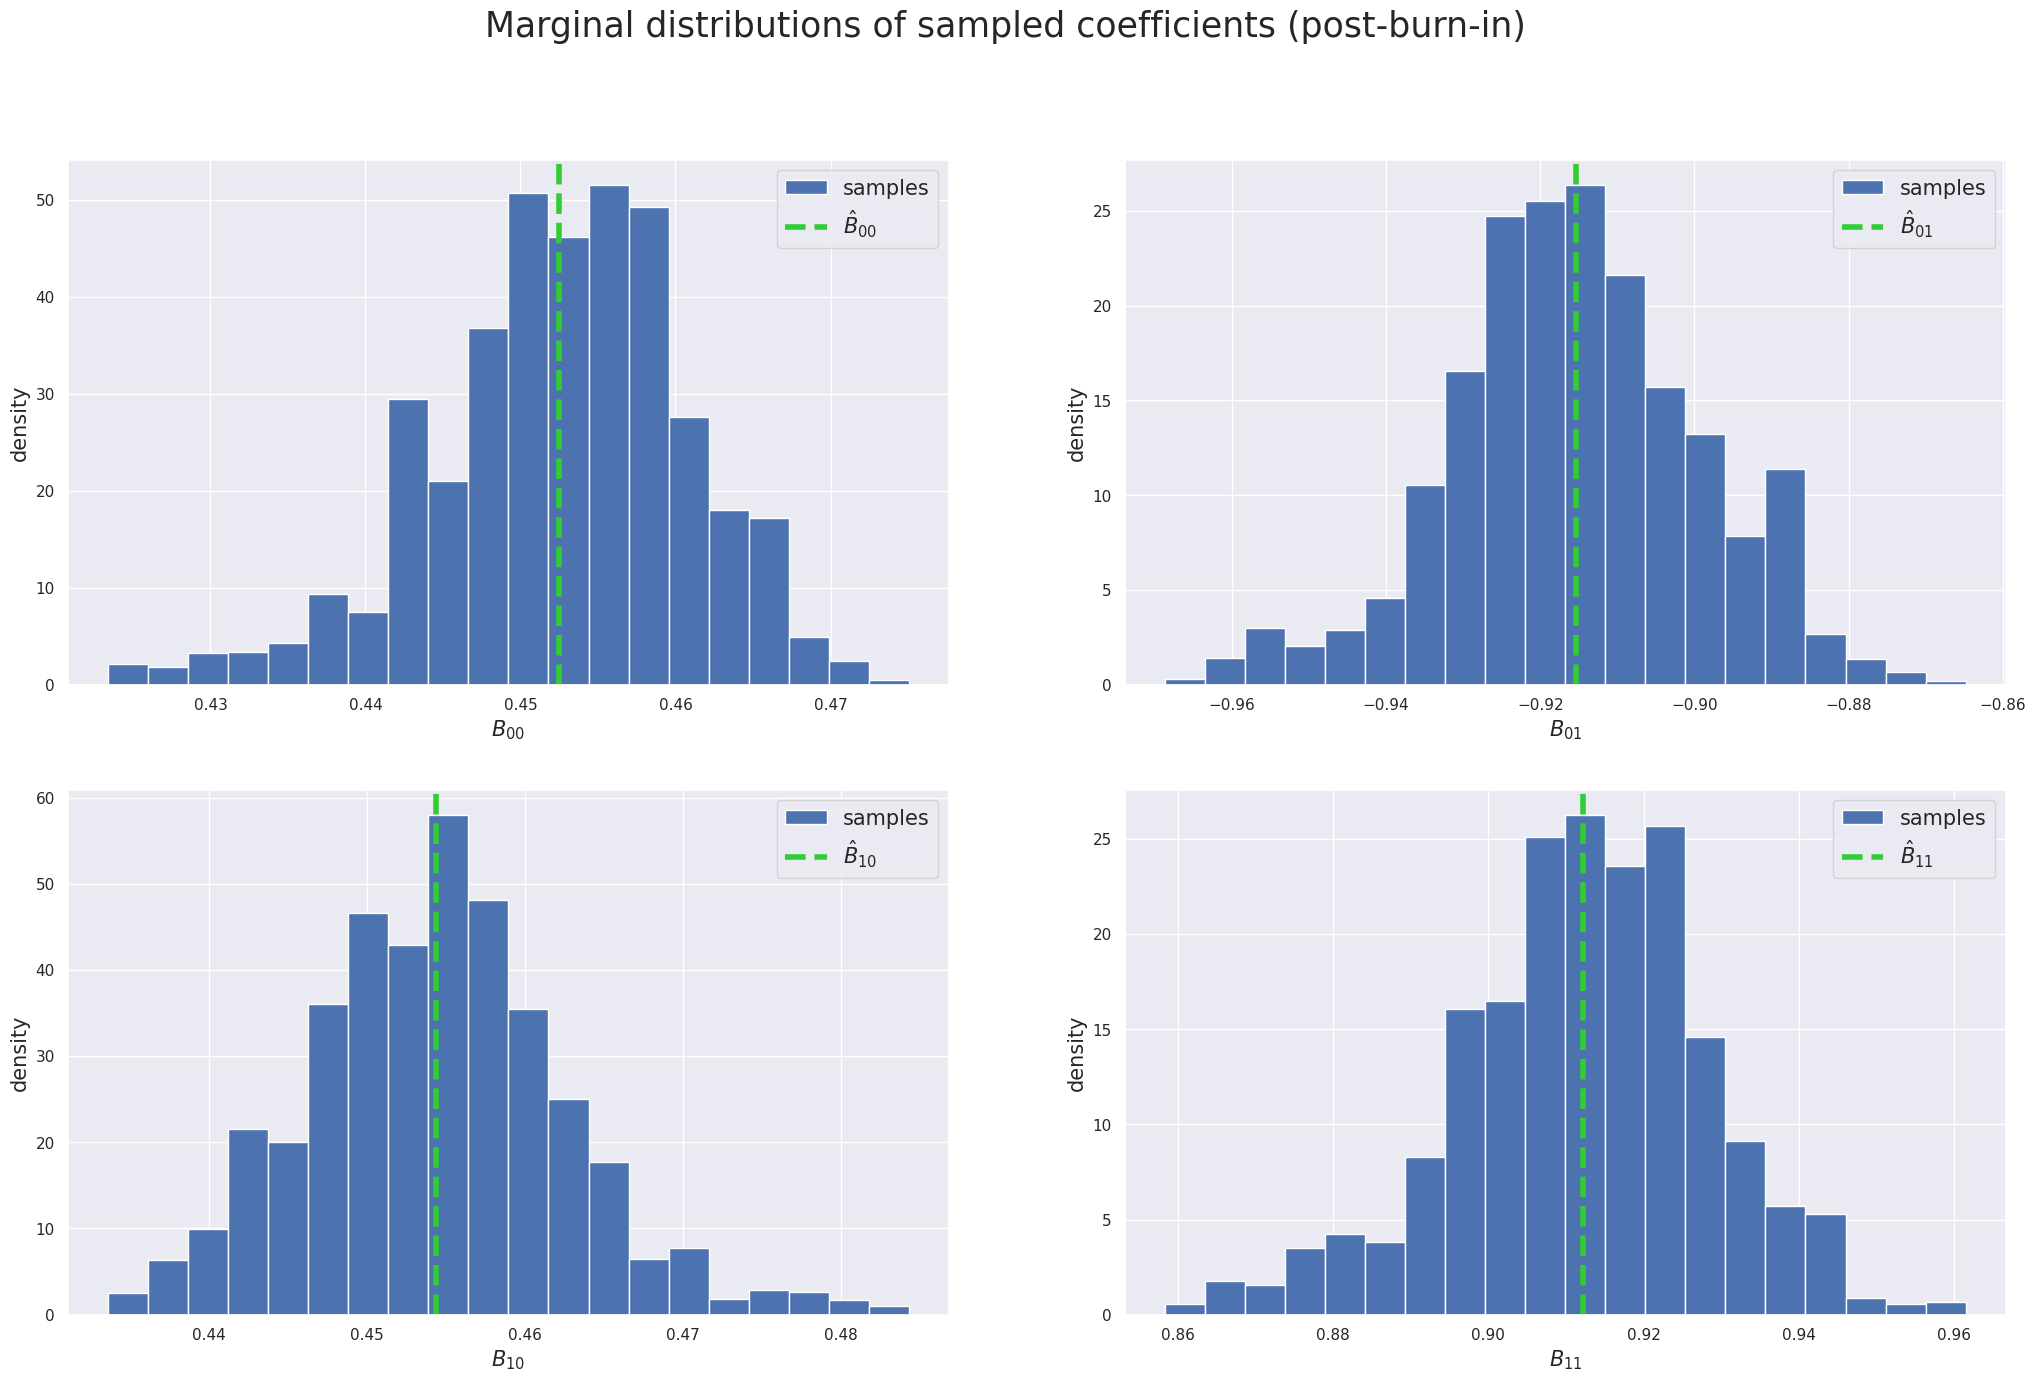

In [92]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Marginal distributions of sampled coefficients (post-burn-in)',
    fontsize=25
)

# B_00
axs[0,0].hist(
    valid_samples[:, 0, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,0].axvline(
    B_est[0, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{00}$'
)
axs[0,0].set_xlabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].set_ylabel(
    'density',
    fontsize=15
)
axs[0,0].legend(
    loc='upper right',
    fontsize=15
)


# B_01
axs[0,1].hist(
    valid_samples[:, 0, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,1].axvline(
    B_est[0, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{01}$'
)
axs[0,1].set_xlabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    'density',
    fontsize=15
)
axs[0,1].legend(
    loc='upper right',
    fontsize=15
)

# B_10
axs[1,0].hist(
    valid_samples[:, 1, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,0].axvline(
    B_est[1, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{10}$'
)
axs[1,0].set_xlabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].set_ylabel(
    'density',
    fontsize=15
)
axs[1,0].legend(
    loc='upper right',
    fontsize=15
)

# B_11
axs[1,1].hist(
    valid_samples[:, 1, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,1].axvline(
    B_est[1, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{11}$'
)
axs[1,1].set_xlabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    'density',
    fontsize=15
)
axs[1,1].legend(
    loc='upper right',
    fontsize=15
)

### 1.5.6. Plot evolution of log-posterior

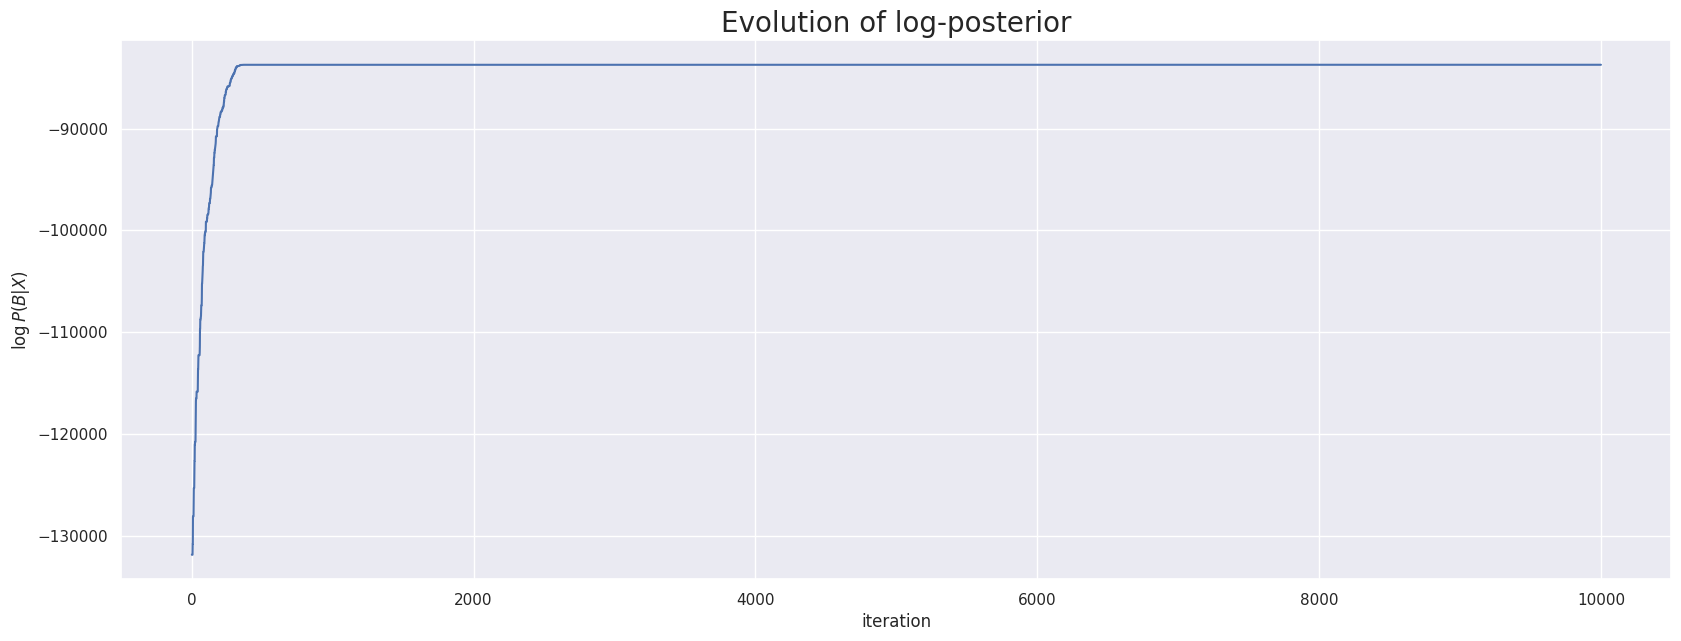

In [93]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posterior'
)
plt.ylabel(
    '$\log P(B|X)$'
)
t = plt.title(
    'Evolution of log-posterior',
    fontsize=20
)

### 1.5.7. Plot Source Separation Results

Text(0.5, 1.0, 'Scatter plot - true values and estimates - coefficient s1')

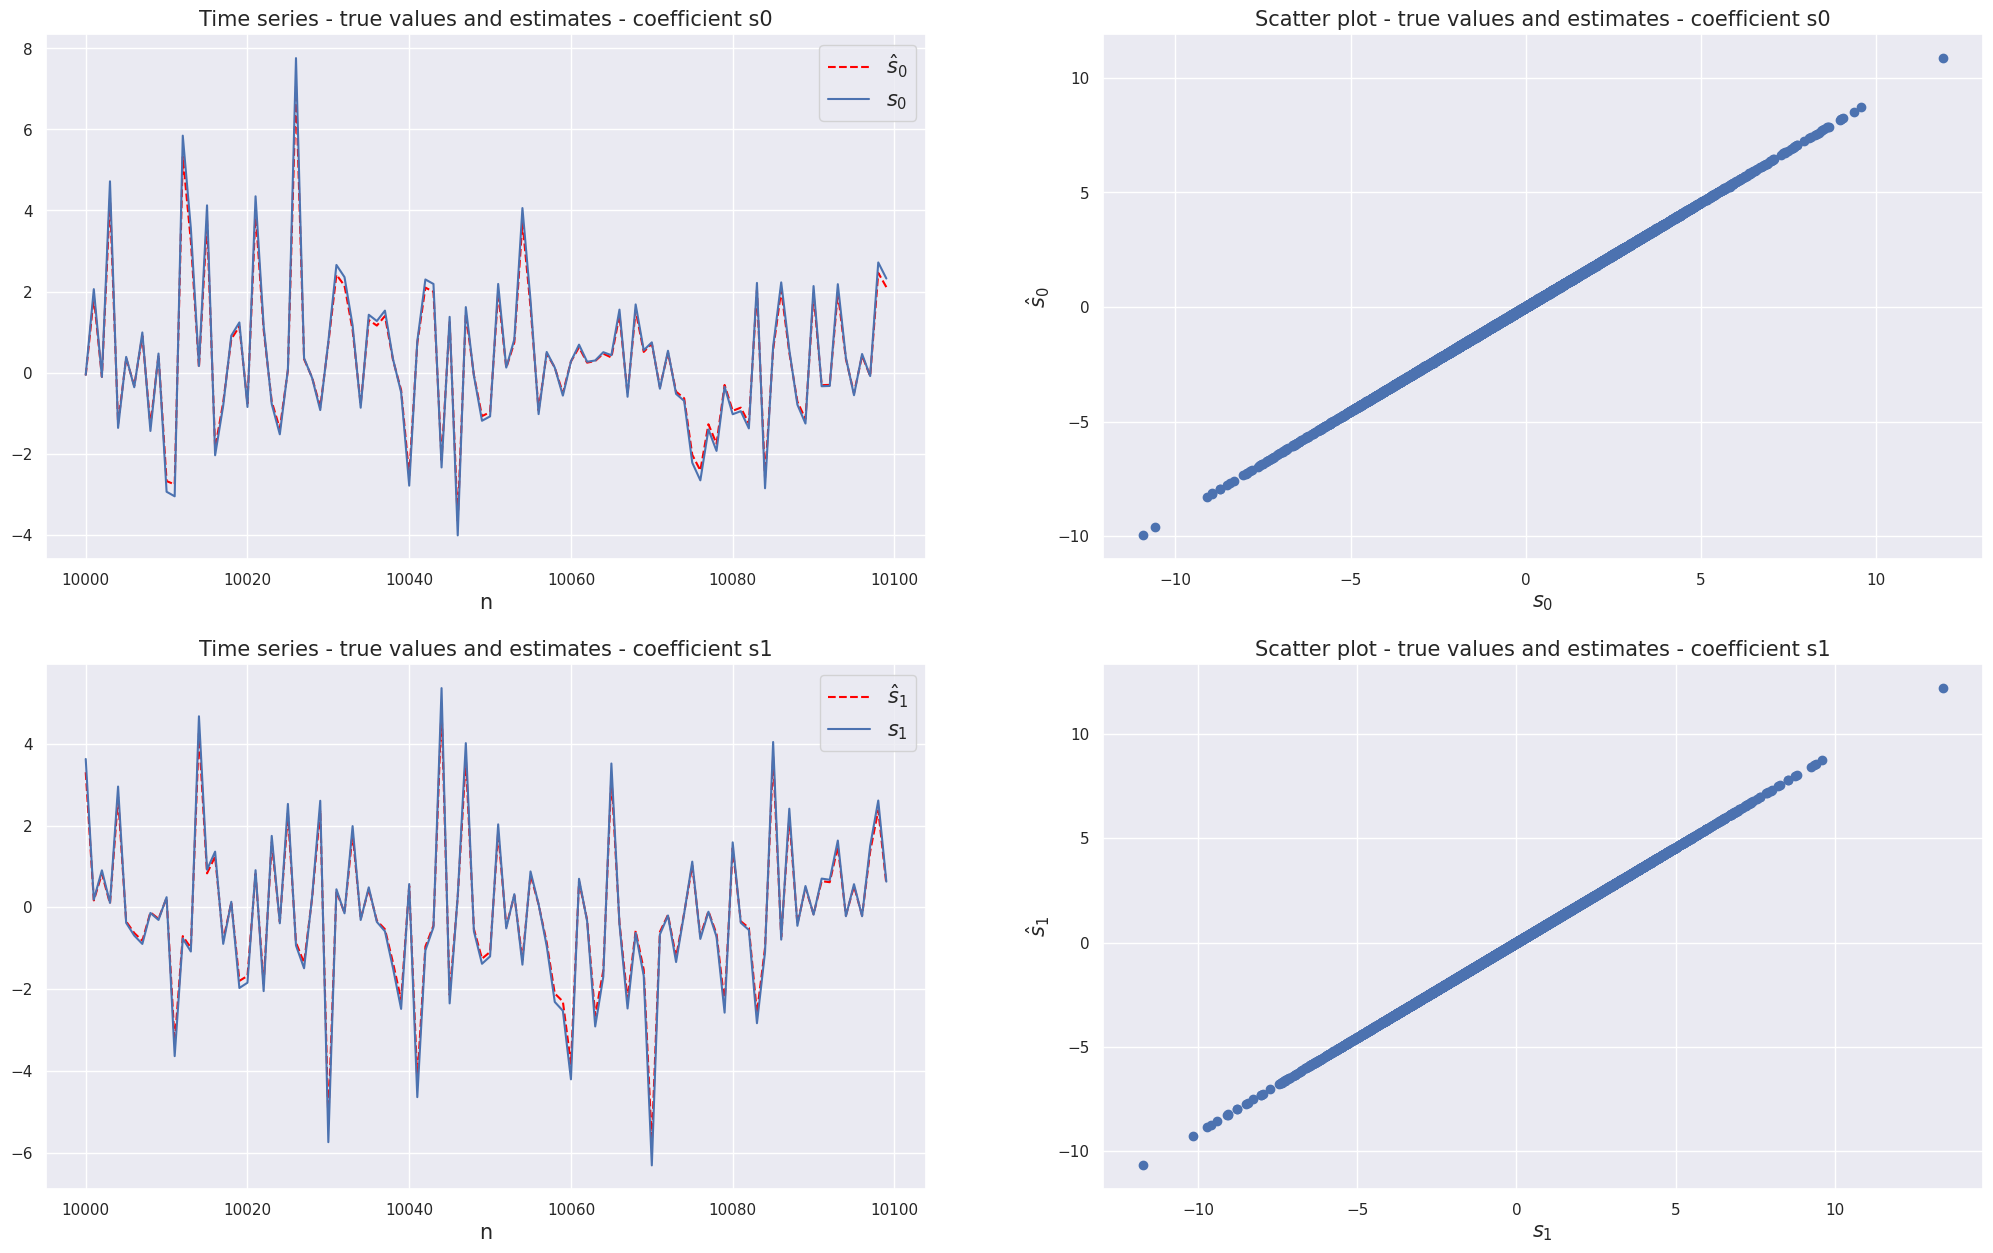

In [94]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B_est@x

# Axs 00
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
axs[0,0].set_xlabel(
    'n',
    fontsize=15
)
axs[0,0].set_title(
    'Time series - true values and estimates - coefficient s0',
    fontsize=15
)
axs[0,0].legend(fontsize=15)

# Axs 01
axs[0,1].scatter(
    s[0,:],
    s_est[0,:],
)
axs[0,1].set_xlabel(
    '$s_{0}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$\hat{s}_{0}$',
    fontsize=15
)
axs[0,1].set_title(
    'Scatter plot - true values and estimates - coefficient s0',
    fontsize=15
)

# Axs 10
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
axs[1,0].set_xlabel(
    'n',
    fontsize=15
)
axs[1,0].set_title(
    'Time series - true values and estimates - coefficient s1',
    fontsize=15
)
axs[1,0].legend(fontsize=15)

# Axs 11
axs[1,1].scatter(
    s[1,:],
    s_est[1,:],
)
axs[1,1].set_xlabel(
    '$s_{1}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$\hat{s}_{1}$',
    fontsize=15
)
axs[1,1].set_title(
    'Scatter plot - true values and estimates - coefficient s1',
    fontsize=15
)

In [95]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['perfect_model']['near_identity_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.0008931194041703476


# 2. SLIGHTLY MISSPECIFIED MODEL

## 2.1. Initialize Sources

In [44]:
def source_cumulative(x):
    return 1/(1+np.exp(-x))

def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def source_generator(
    nsources,
    nobs,
    mu,
    scale
):
    return np.random.logistic(
        loc=mu,
        scale=scale,
        size=(nsources, nobs)
    )

In [45]:
MU=0.1
SCALE=1.1

s = source_generator(
    nsources=NSOURCES,
    nobs=NOBS,
    mu=MU,
    scale=SCALE
)

print('-'*100)
print('NÚMERO DE FONTES: {}'.format(NSOURCES))
print('TAMANHO DOS SINAIS DAS FONTES: {}'.format(NOBS))
for i in range(s.shape[0]):
    print(
        'CURTOSE s{}: {}'.format(
            i,
            st.kurtosis(a=s[i,:])
        )
    )
    
print('-'*100)

----------------------------------------------------------------------------------------------------
NÚMERO DE FONTES: 2
TAMANHO DOS SINAIS DAS FONTES: 20000
CURTOSE s0: 1.1486915949312184
CURTOSE s1: 1.2403528187038688
----------------------------------------------------------------------------------------------------


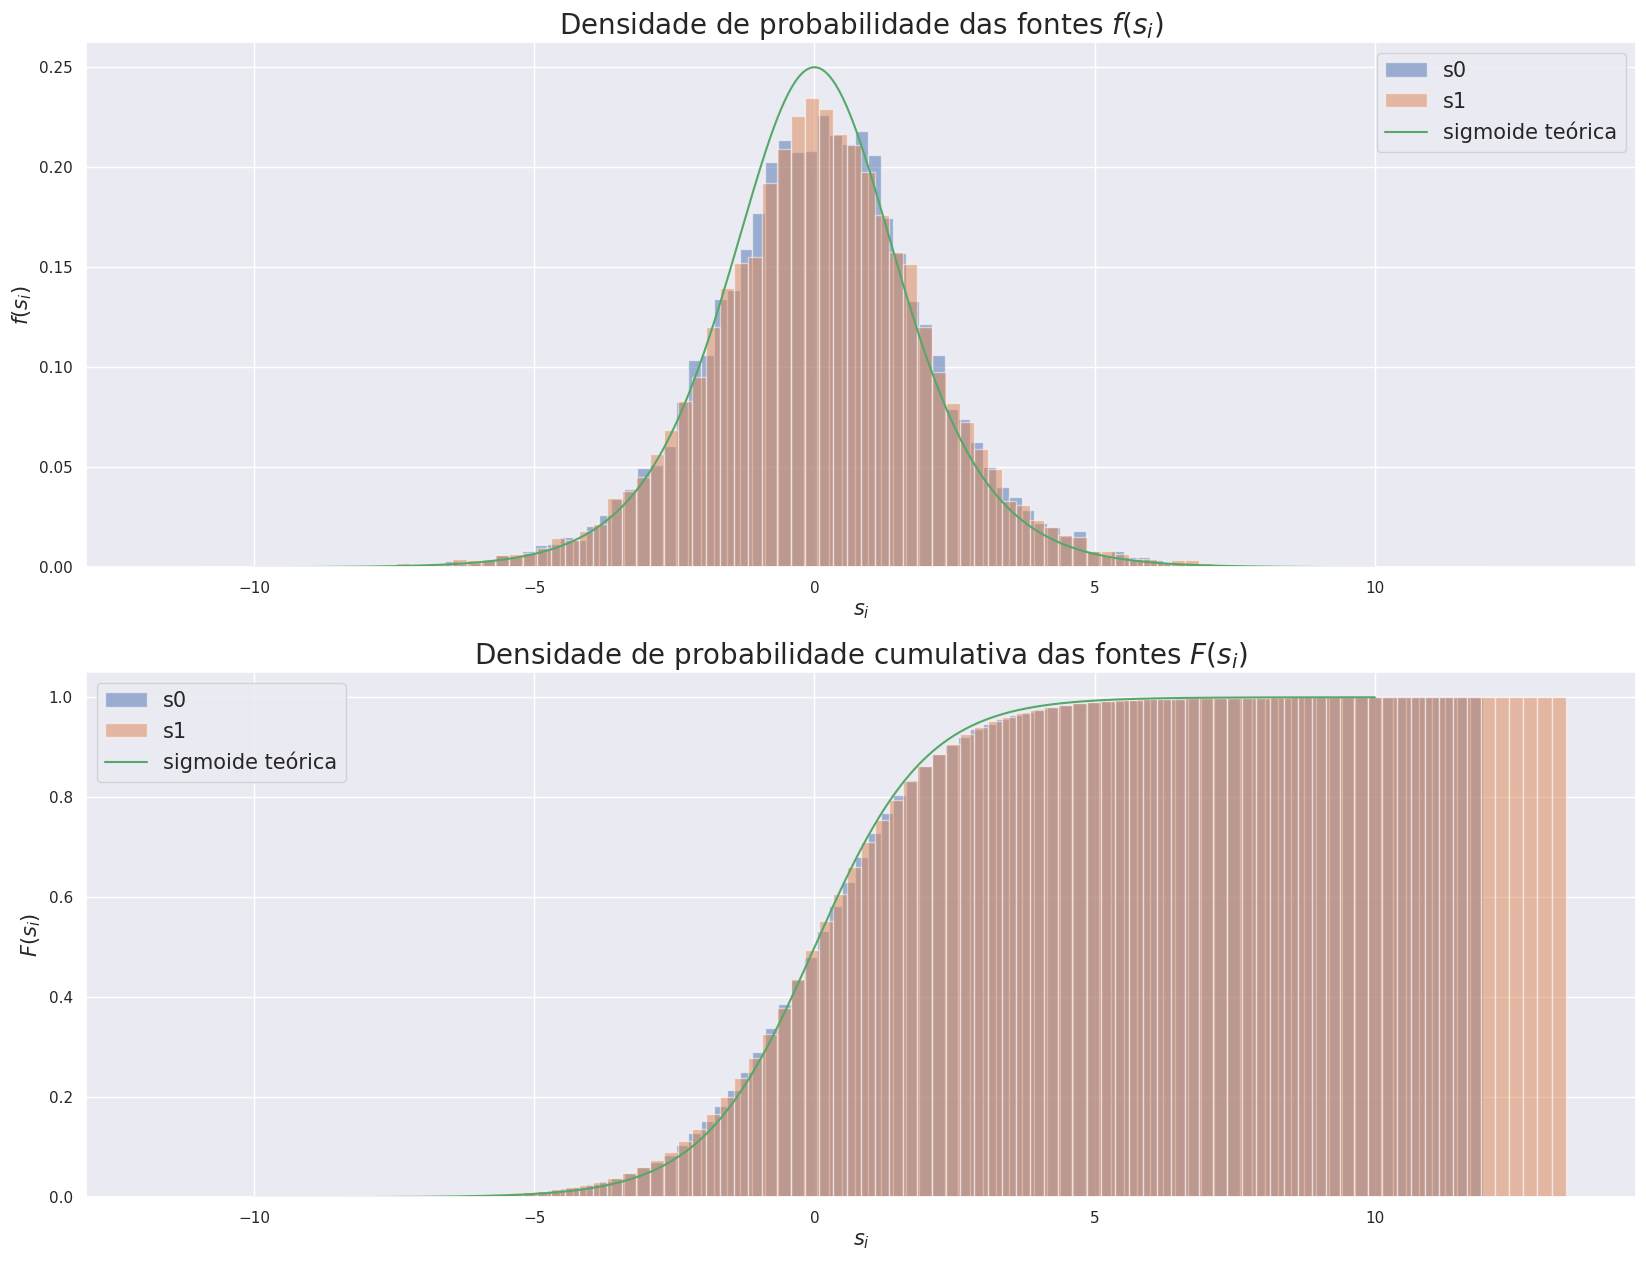

In [46]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)


for i in range(1, NSOURCES+1):
    ax1.hist(
        x=s[i-1,:],
        bins=100,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=s[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    
ax1.plot(
    np.linspace(-10,10,1000),
    [source_pdf(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)


ax2.plot(
    np.linspace(-10,10,1000),
    [source_cumulative(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)

ax1.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(s_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidade de probabilidade das fontes $f(s_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(s_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidade de probabilidade cumulativa das fontes $F(s_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

## 2.2. Mix sources and generate observations

In [47]:
# Mixing matrix
A = np.array([
    [1, 1],
    [-0.5, 0.5]
])
print('MIXING MATRIX A:')
print(A)

MIXING MATRIX A:
[[ 1.   1. ]
 [-0.5  0.5]]


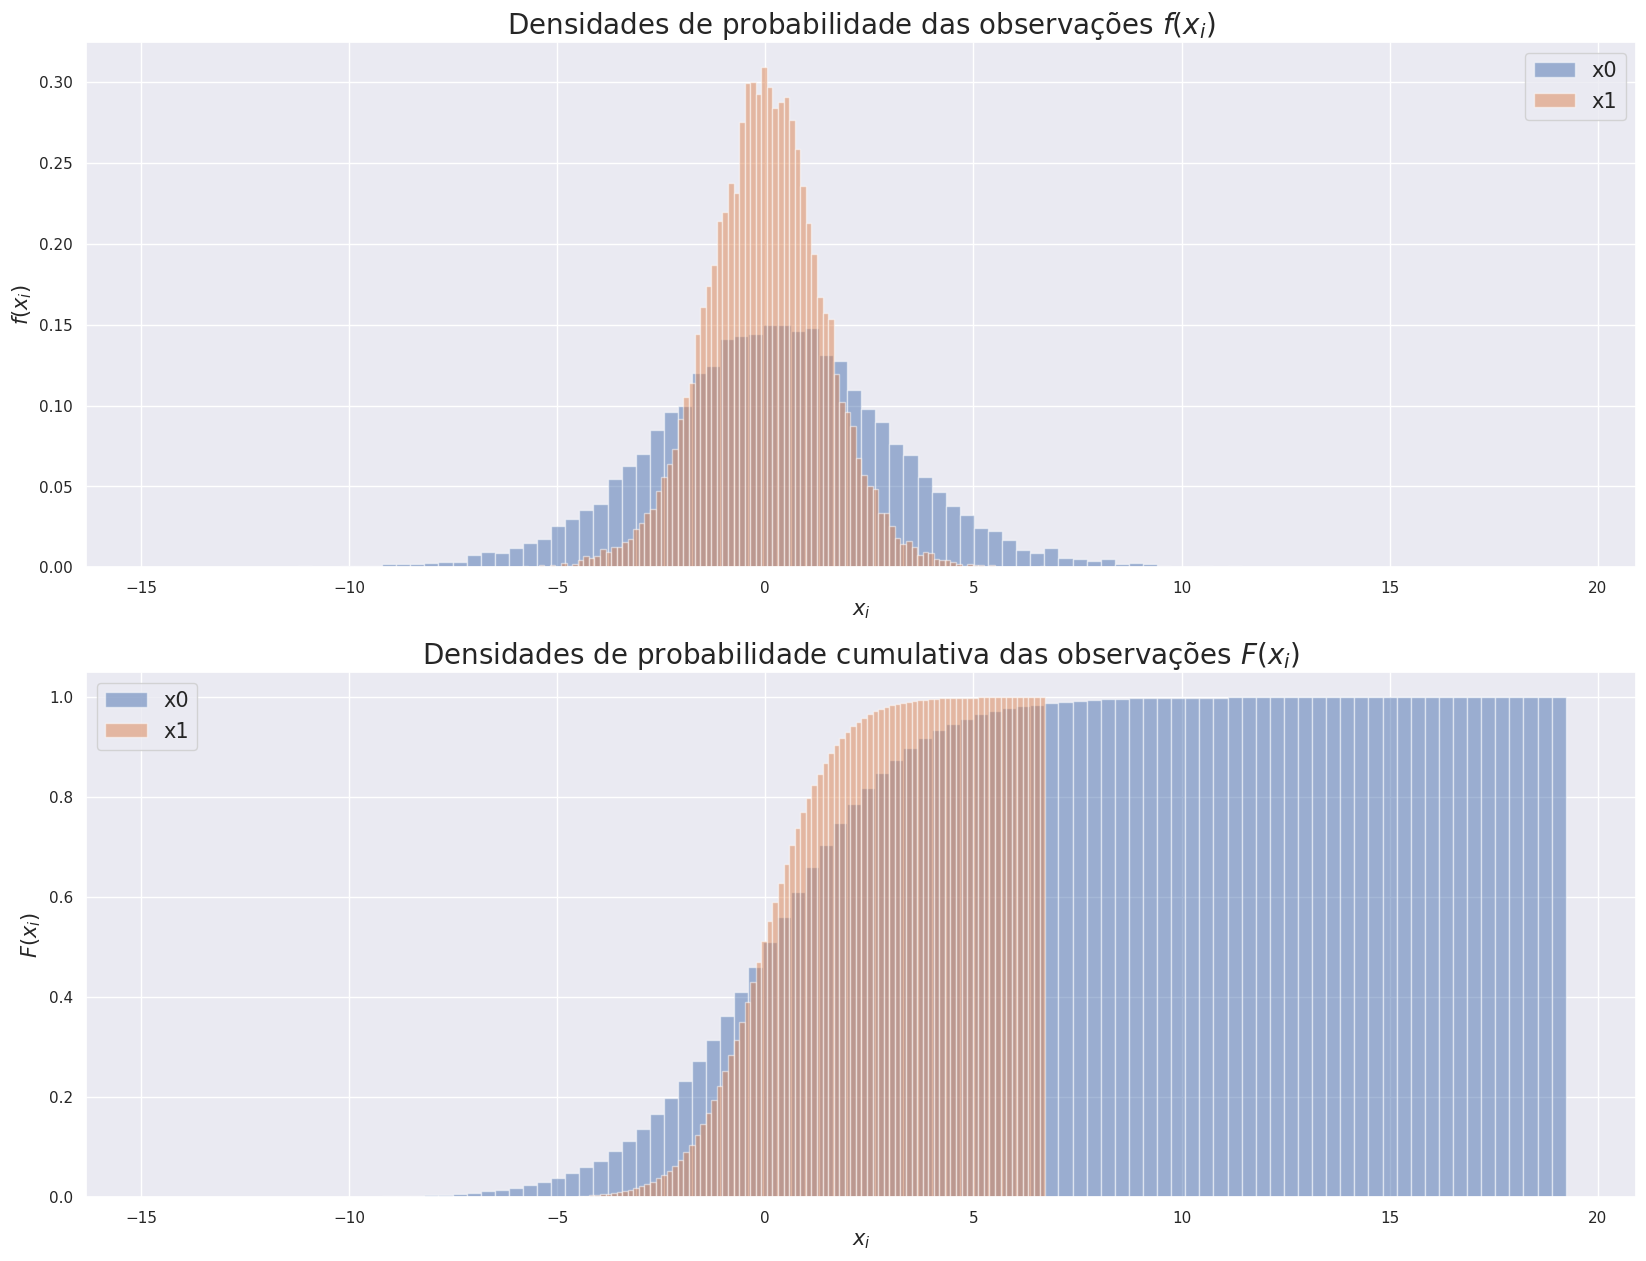

In [48]:
# Observed sources
x = A@s

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

for i in range(1, NSOURCES+1):
    ax1.hist(
        x=x[i-1,:],
        bins=100,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=x[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )

ax1.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(x_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidades de probabilidade das observações $f(x_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(x_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidades de probabilidade cumulativa das observações $F(x_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

## 2.3. Perform Analysis - LIKELIHOOD

### 2.3.1 Execute MCMC Sampling

In [49]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    return 1

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [50]:
%%time

SAVE_PATH='./artifacts/slightly_misspecified_model/ML.pkl'
if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(estimator, f)

else:
    # Read artifact
    with open(SAVE_PATH, 'rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 24.7 ms, sys: 14.2 ms, total: 38.9 ms
Wall time: 55.5 ms


### 2.3.2. Parse MCMC Results

In [51]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 10
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [52]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.45164622 -0.91855697]
 [ 0.45566753  0.90944976]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [53]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-83724.53347466908,
 -83724.55062011098,
 -83724.54194528182,
 -83724.49551899606,
 -83724.57414096389,
 -83724.49254367223,
 -83724.4931854362,
 -83724.49127194806,
 -83724.50636326274,
 -83724.47717899746,
 -83724.55447649854,
 -83724.49924366671,
 -83724.53003526272,
 -83724.5106755902,
 -83724.53430971621,
 -83724.49482130392,
 -83724.50668512177,
 -83724.5258375155,
 -83724.50220168631,
 -83724.56309628578,
 -83724.53618015313,
 -83724.47149201587,
 -83724.50500522832,
 -83724.4784967678,
 -83724.50464842173,
 -83724.48168716834,
 -83724.47071662897,
 -83724.48666259817,
 -83724.47824738978,
 -83724.55945348623]

In [54]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.45331361, -0.91545902],
        [ 0.45393344,  0.91384258]]),
 array([[ 0.45408788,  0.91232115],
        [-0.45280969,  0.91648608]]),
 array([[-0.45480916,  0.91294844],
        [-0.45274229, -0.91504032]]),
 array([[-0.45529221,  0.91014297],
        [-0.4518924 , -0.91672046]]),
 array([[-0.45446701, -0.91191215],
        [ 0.45294929, -0.91530626]]),
 array([[-0.4553898 , -0.91125517],
        [-0.4520638 ,  0.91735839]]),
 array([[ 0.45288887,  0.91575896],
        [-0.45458403,  0.91253457]]),
 array([[-0.45496226, -0.91093745],
        [ 0.45234286, -0.91556208]]),
 array([[-0.45593145,  0.90937711],
        [-0.45145958, -0.91845047]]),
 array([[-0.45244018,  0.91683231],
        [ 0.45506644,  0.91107116]]),
 array([[ 0.45164622, -0.91855697],
        [ 0.45566753,  0.90944976]]),
 array([[-0.45485755, -0.91136478],
        [ 0.45265365, -0.91776647]]),
 array([[-0.4514587 ,  0.92004346],
        [ 0.45595043,  0.90895697]]),
 array([[-0.45451469,  0.91296574],
  

### 2.3.3. Plot sampled coefficients stochastic process - Markov Chain evolution

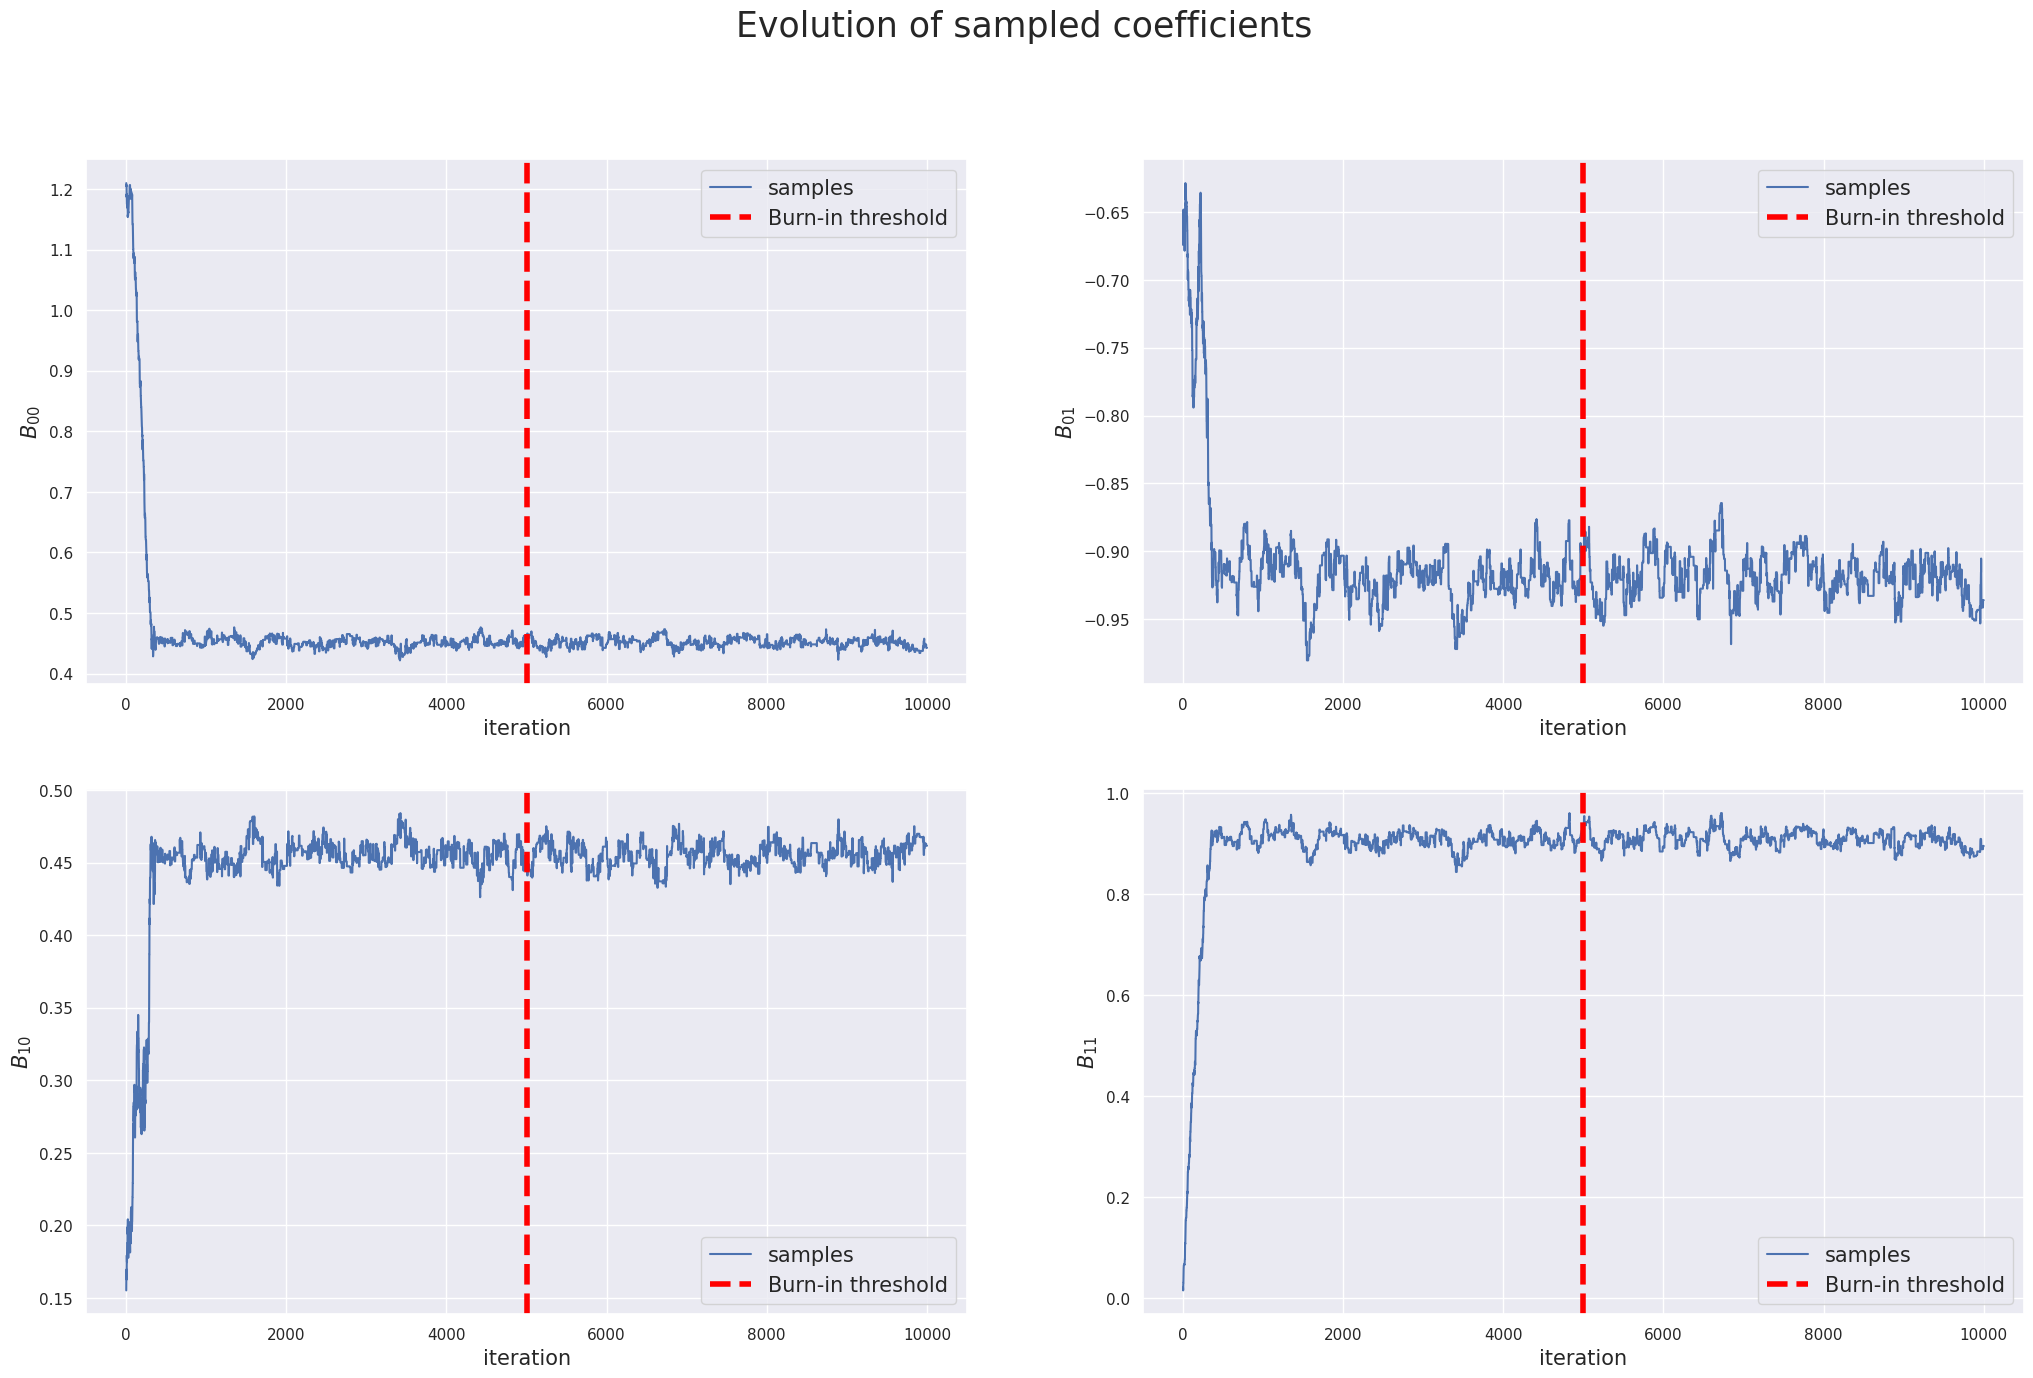

In [55]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of sampled coefficients',
    fontsize=25
)

# B_00
axs[0,0].plot(
    logs.iteration,
    samples[:, 0, 0],
    label='samples'
)
axs[0,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,0].set_ylabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].legend(
    fontsize=15
)

# B_01
axs[0,1].plot(
    logs.iteration,
    samples[:, 0, 1],
    label='samples'
)
axs[0,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].legend(
    fontsize=15
)

# B_10
axs[1,0].plot(
    logs.iteration,
    samples[:, 1, 0],
    label='samples'
)
axs[1,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,0].set_ylabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].legend(
    fontsize=15
)

# B_11
axs[1,1].plot(
    logs.iteration,
    samples[:, 1, 1],
    label='samples'
)
axs[1,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].legend(
    fontsize=15
)

### 2.3.4. Plot sampled coefficients distributions - Markov Chain evolution

<Axes: xlabel='B_11', ylabel='Density'>

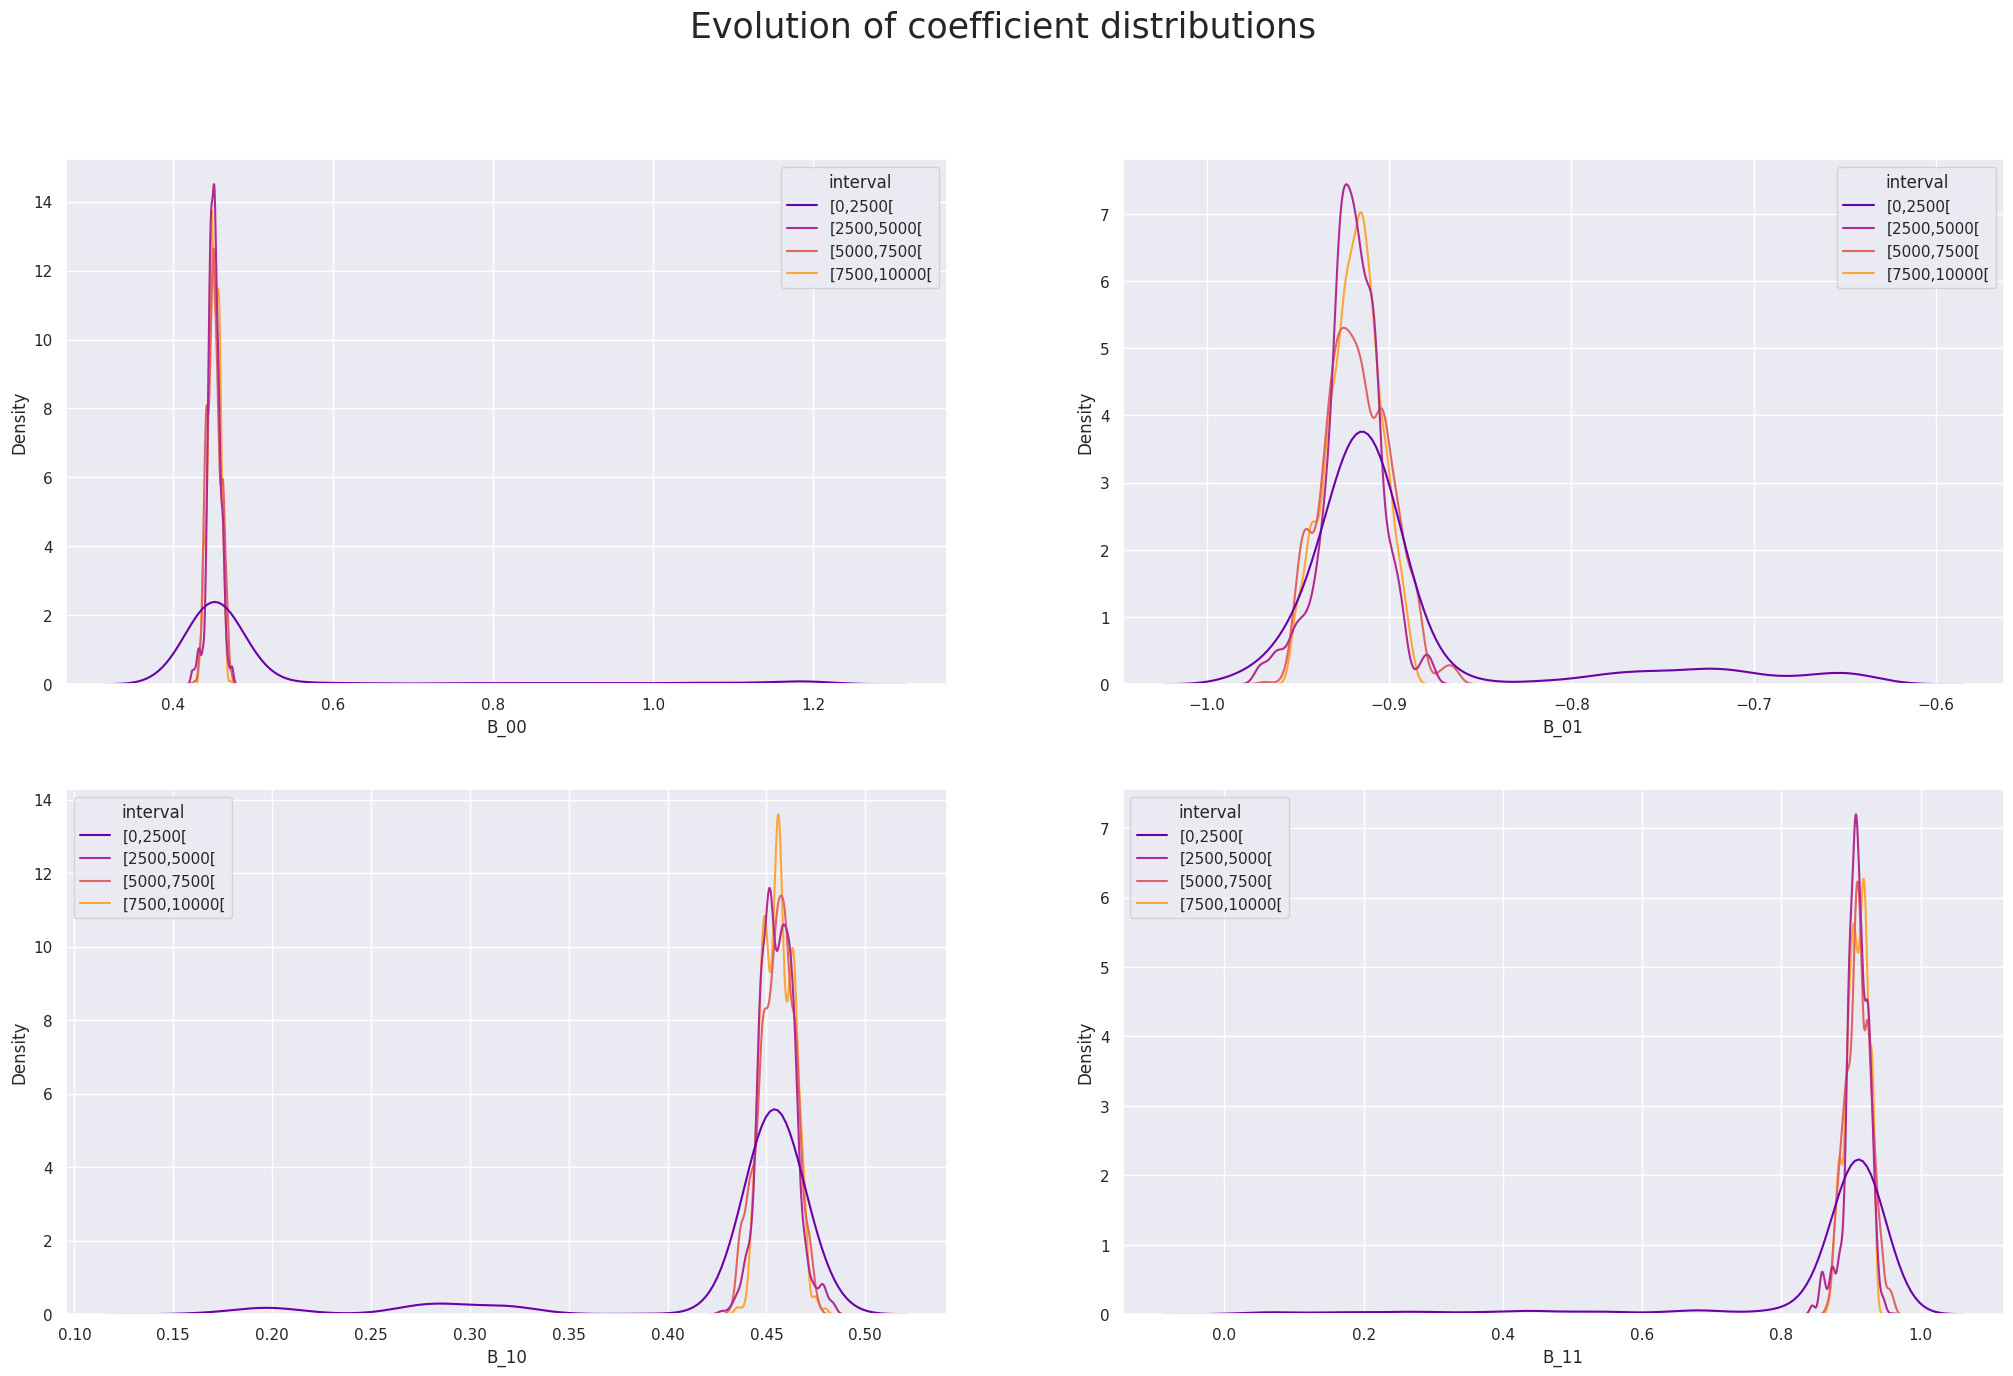

In [56]:
##############################
# Evolution of distributions #
##############################

# Get step size and evaluated points
STEP_SIZE=2500
PALETTE='plasma'

i=0
evaluated_intervals=[]
while i<N_SAMPLES:
    start=i
    end=min(
        i+STEP_SIZE,
        N_SAMPLES
    )
    evaluated_intervals.append(
        (start, end)
    )
    i = i + STEP_SIZE

# Window samples and construct dataframe for plotting
plot_df=pd.DataFrame()
for start, end in evaluated_intervals:
    wdw_df = pd.DataFrame(
        data={
            'interval': ['[{},{}['.format(start, end)]*(end-start)
        }
    )
    wdw_samples = samples[start:end,:,:]
    for i, j in np.ndindex(B_est.shape):
        wdw_df['B_{}{}'.format(i, j)] = wdw_samples[:,i,j]

    plot_df = pd.concat(
        [
            plot_df,
            wdw_df
        ],
        axis=0
    ).reset_index(
        drop=True
    )

# Plot coefficient distribution evolution
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of coefficient distributions',
    fontsize=25
)

# B_00
sns.kdeplot(
    data=plot_df,
    x='B_00',
    hue='interval',
    ax=axs[0,0],
    palette=PALETTE
)

# B_01
sns.kdeplot(
    data=plot_df,
    x='B_01',
    hue='interval',
    ax=axs[0,1],
    palette=PALETTE
)

# B_10
sns.kdeplot(
    data=plot_df,
    x='B_10',
    hue='interval',
    ax=axs[1,0],
    palette=PALETTE
)

# B_11
sns.kdeplot(
    data=plot_df,
    x='B_11',
    hue='interval',
    ax=axs[1,1],
    palette=PALETTE
)

### 2.3.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

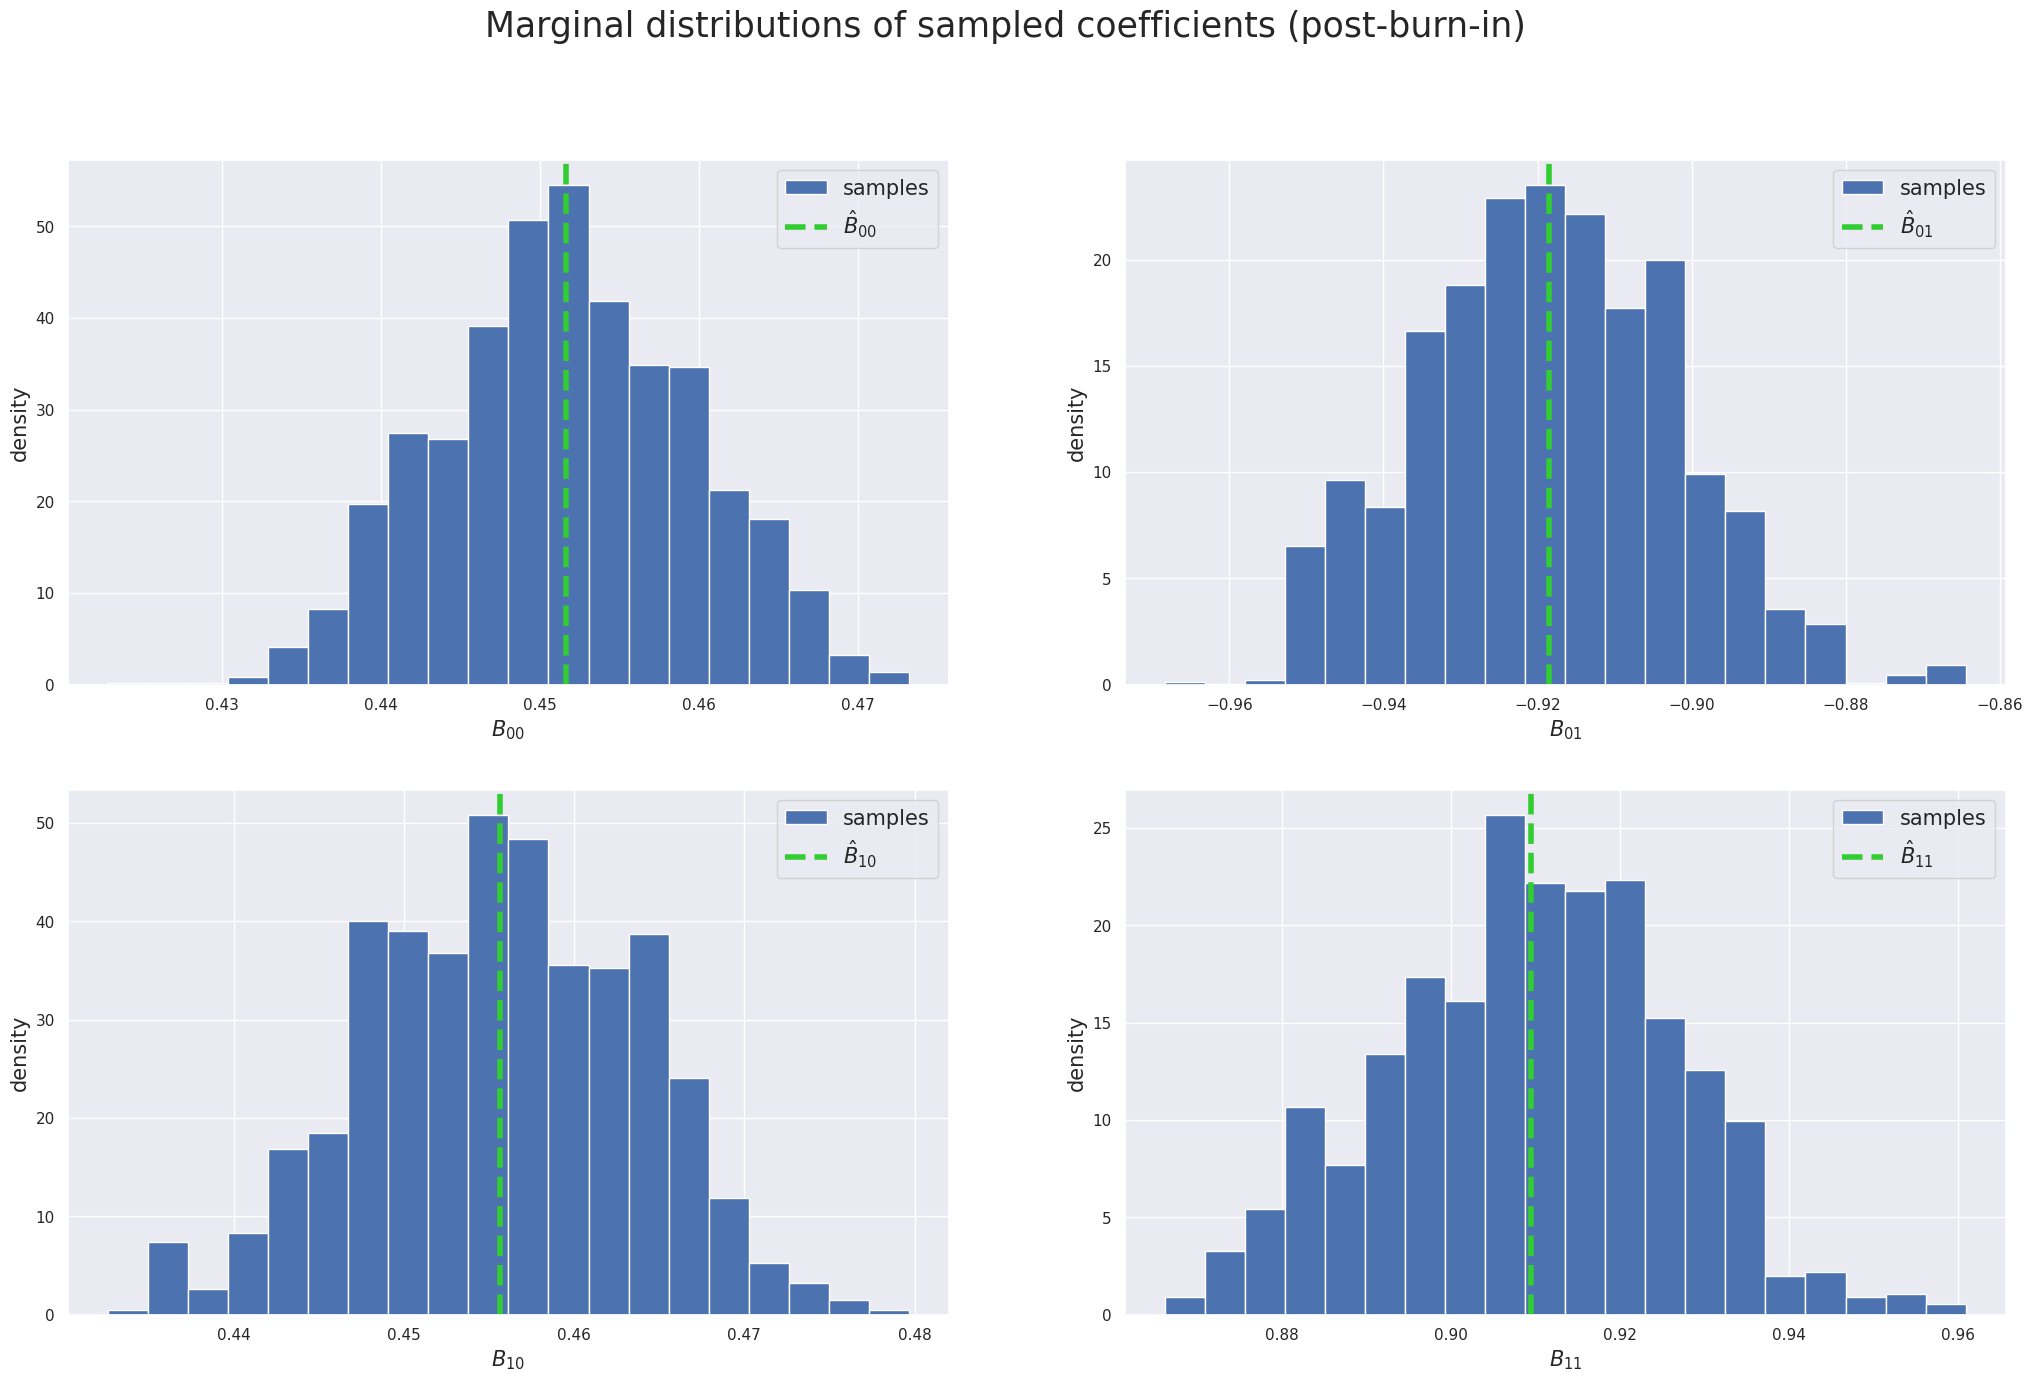

In [57]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Marginal distributions of sampled coefficients (post-burn-in)',
    fontsize=25
)

# B_00
axs[0,0].hist(
    valid_samples[:, 0, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,0].axvline(
    B_est[0, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{00}$'
)
axs[0,0].set_xlabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].set_ylabel(
    'density',
    fontsize=15
)
axs[0,0].legend(
    loc='upper right',
    fontsize=15
)


# B_01
axs[0,1].hist(
    valid_samples[:, 0, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,1].axvline(
    B_est[0, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{01}$'
)
axs[0,1].set_xlabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    'density',
    fontsize=15
)
axs[0,1].legend(
    loc='upper right',
    fontsize=15
)

# B_10
axs[1,0].hist(
    valid_samples[:, 1, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,0].axvline(
    B_est[1, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{10}$'
)
axs[1,0].set_xlabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].set_ylabel(
    'density',
    fontsize=15
)
axs[1,0].legend(
    loc='upper right',
    fontsize=15
)

# B_11
axs[1,1].hist(
    valid_samples[:, 1, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,1].axvline(
    B_est[1, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{11}$'
)
axs[1,1].set_xlabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    'density',
    fontsize=15
)
axs[1,1].legend(
    loc='upper right',
    fontsize=15
)

### 2.3.6. Plot evolution of log-posterior

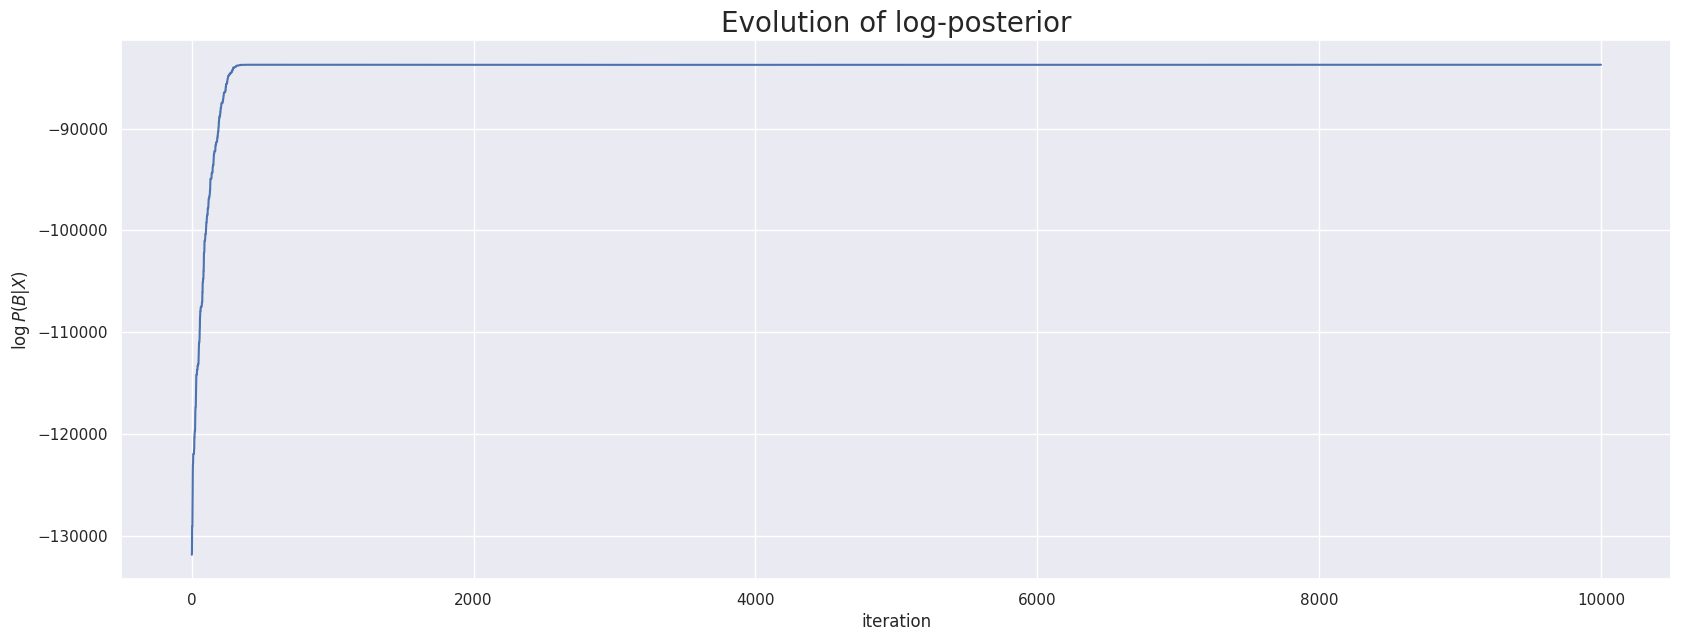

In [58]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posterior'
)
plt.ylabel(
    '$\log P(B|X)$'
)
t = plt.title(
    'Evolution of log-posterior',
    fontsize=20
)

Text(0.5, 1.0, 'Scatter plot - true values and estimates - coefficient s1')

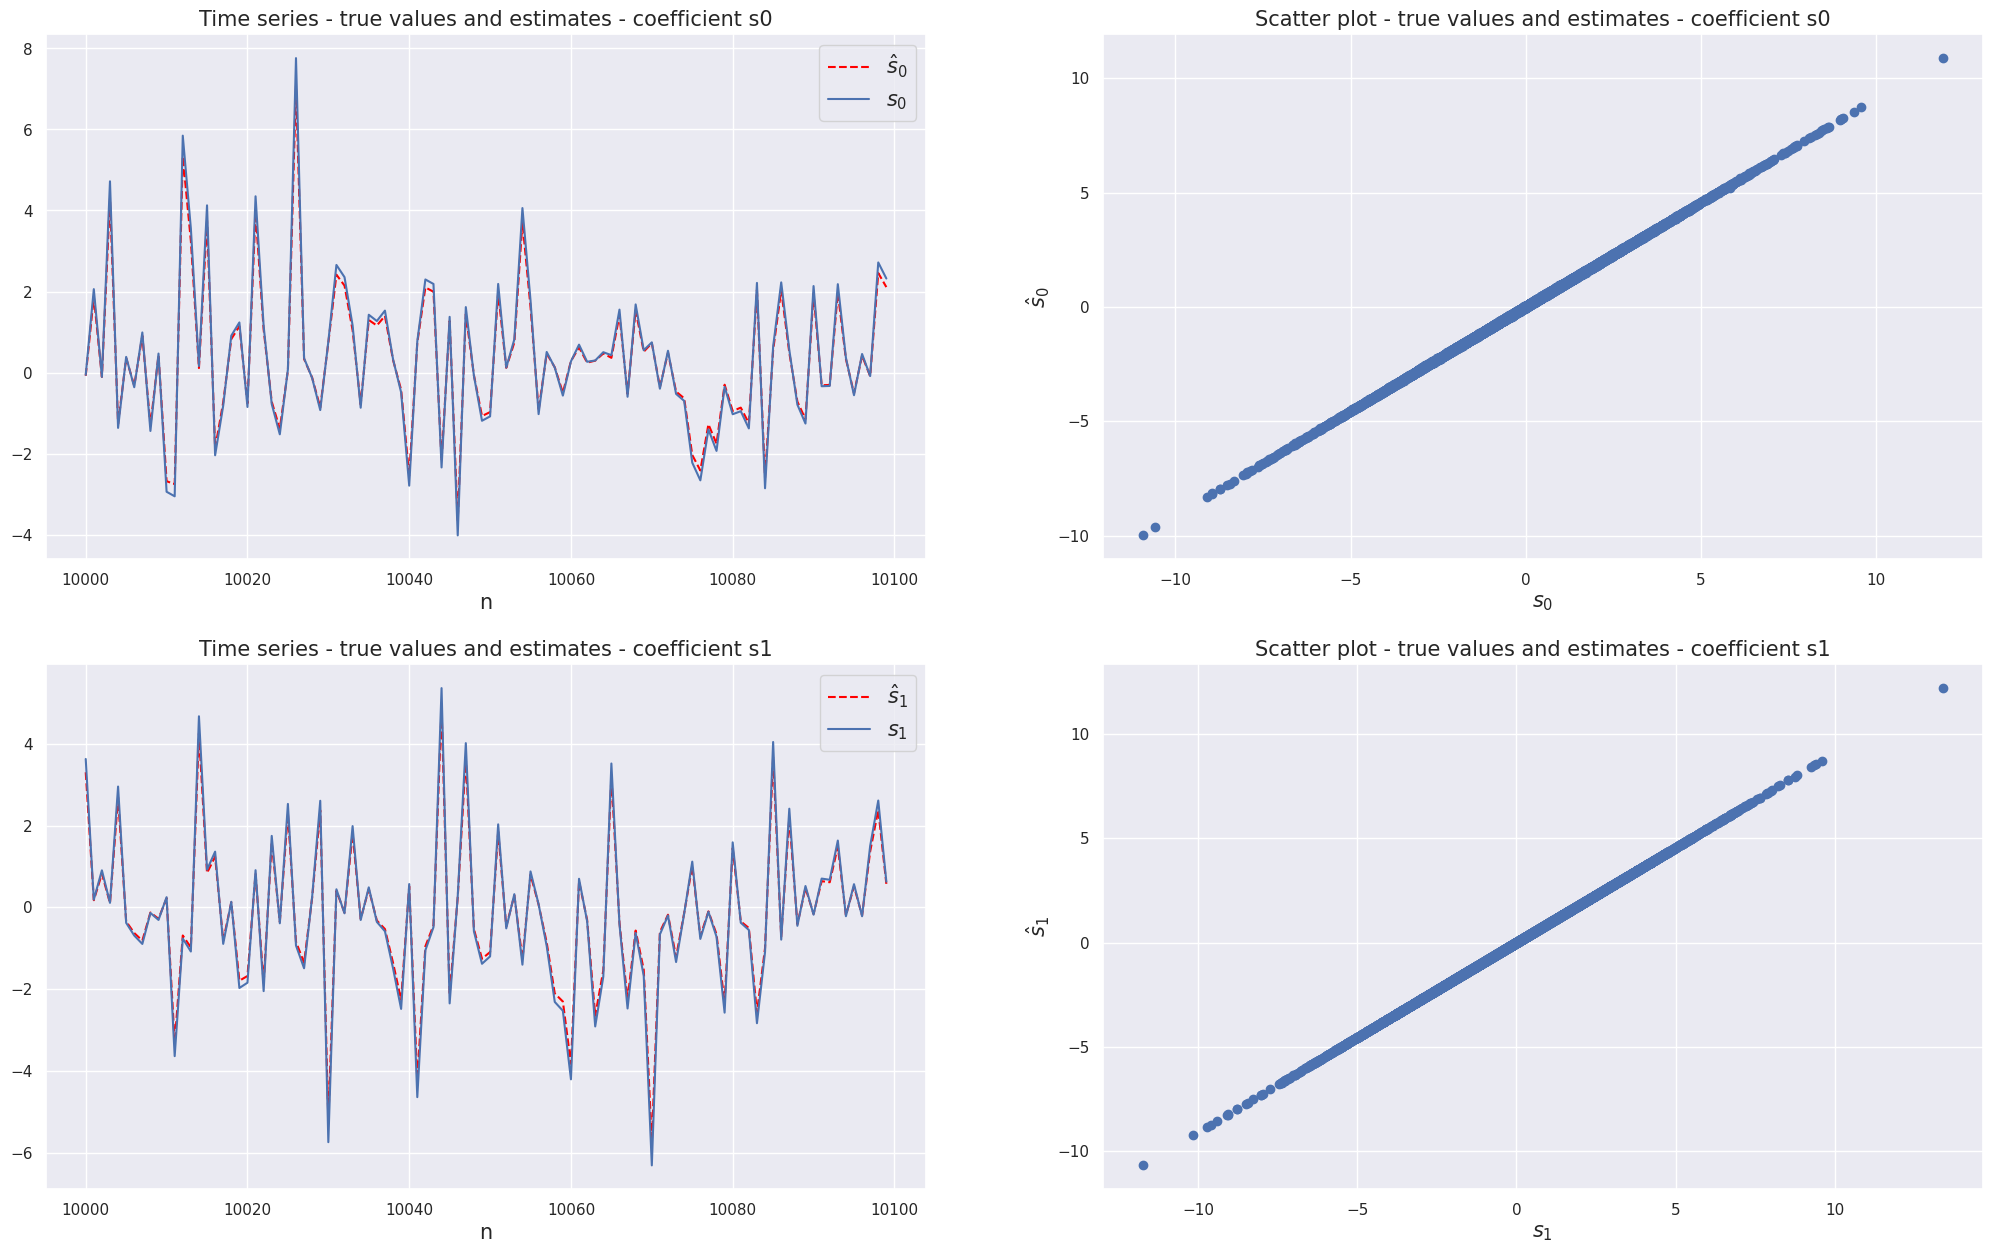

In [59]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B_est@x

# Axs 00
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
axs[0,0].set_xlabel(
    'n',
    fontsize=15
)
axs[0,0].set_title(
    'Time series - true values and estimates - coefficient s0',
    fontsize=15
)
axs[0,0].legend(fontsize=15)

# Axs 01
axs[0,1].scatter(
    s[0,:],
    s_est[0,:],
)
axs[0,1].set_xlabel(
    '$s_{0}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$\hat{s}_{0}$',
    fontsize=15
)
axs[0,1].set_title(
    'Scatter plot - true values and estimates - coefficient s0',
    fontsize=15
)

# Axs 10
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
axs[1,0].set_xlabel(
    'n',
    fontsize=15
)
axs[1,0].set_title(
    'Time series - true values and estimates - coefficient s1',
    fontsize=15
)
axs[1,0].legend(fontsize=15)

# Axs 11
axs[1,1].scatter(
    s[1,:],
    s_est[1,:],
)
axs[1,1].set_xlabel(
    '$s_{1}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$\hat{s}_{1}$',
    fontsize=15
)
axs[1,1].set_title(
    'Scatter plot - true values and estimates - coefficient s1',
    fontsize=15
)

In [60]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['slightly_misspecified']['likelihood'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.0008908940717477854


## 2.4. Perform Analysis - DETERMINANT PRIOR
#### Prior:
$p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} (det(\boldsymbol{B}) - 1)^2 \right]$

### 2.4.1 Execute MCMC Sampling

In [61]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    sig=0.1
    desired_det=1
    return (1/np.sqrt(2*np.pi*np.square(sig)))*np.exp(-np.square(np.linalg.det(B)-desired_det)/(2*np.square(sig)))

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [62]:
%%time

SAVE_PATH='./artifacts/slightly_misspecified_model/Det_1.pkl'
if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(estimator, f)

else:
    # Read artifact
    with open(SAVE_PATH, 'rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 80.1 ms, sys: 67.4 ms, total: 147 ms
Wall time: 52.6 ms


### 2.4.2. Parse MCMC Results

In [63]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 10
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [64]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.45375846 -0.91420525]
 [ 0.4536242   0.91398993]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [65]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-83724.47260573263,
 -83724.51450830868,
 -83724.54795949842,
 -83724.50405575823,
 -83724.57414096389,
 -83724.51016633376,
 -83724.50755491563,
 -83724.5561378941,
 -83724.52517637874,
 -83724.47717899746,
 -83724.50041816544,
 -83724.48875541844,
 -83724.52053499484,
 -83724.46564052423,
 -83724.50809216002,
 -83724.49482130392,
 -83724.51282862488,
 -83724.49539968892,
 -83724.50242769216,
 -83724.56309628578,
 -83724.53588963828,
 -83724.57296905897,
 -83724.49444736716,
 -83724.52734888621,
 -83724.56830857738,
 -83724.47863574428,
 -83724.59976042103,
 -83724.53422105787,
 -83724.47824738978,
 -83724.53688602218]

In [66]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.45382141, -0.91430676],
        [ 0.45348423,  0.91343906]]),
 array([[ 0.45400872,  0.91399827],
        [-0.45371646,  0.91414413]]),
 array([[-0.45266643,  0.91581977],
        [-0.45422375, -0.91242244]]),
 array([[ 0.45271507,  0.91575475],
        [-0.4546672 ,  0.91259666]]),
 array([[-0.45446701, -0.91191215],
        [ 0.45294929, -0.91530626]]),
 array([[-0.45360066, -0.91350041],
        [-0.45374446,  0.9143791 ]]),
 array([[ 0.45341762,  0.91393495],
        [-0.45406423,  0.91356763]]),
 array([[-0.45477035, -0.91107788],
        [ 0.45188618, -0.91669002]]),
 array([[-0.45411926,  0.91331029],
        [-0.45315425, -0.91403389]]),
 array([[-0.45244018,  0.91683231],
        [ 0.45506644,  0.91107116]]),
 array([[ 0.45375846, -0.91420525],
        [ 0.4536242 ,  0.91398993]]),
 array([[-0.45331592, -0.91392226],
        [ 0.45407479, -0.91427601]]),
 array([[-0.45348294,  0.91321376],
        [ 0.4533991 ,  0.91348413]]),
 array([[-0.45465862,  0.9130224 ],
  

### 2.4.3. Plot sampled coefficients stochastic process - Markov Chain evolution

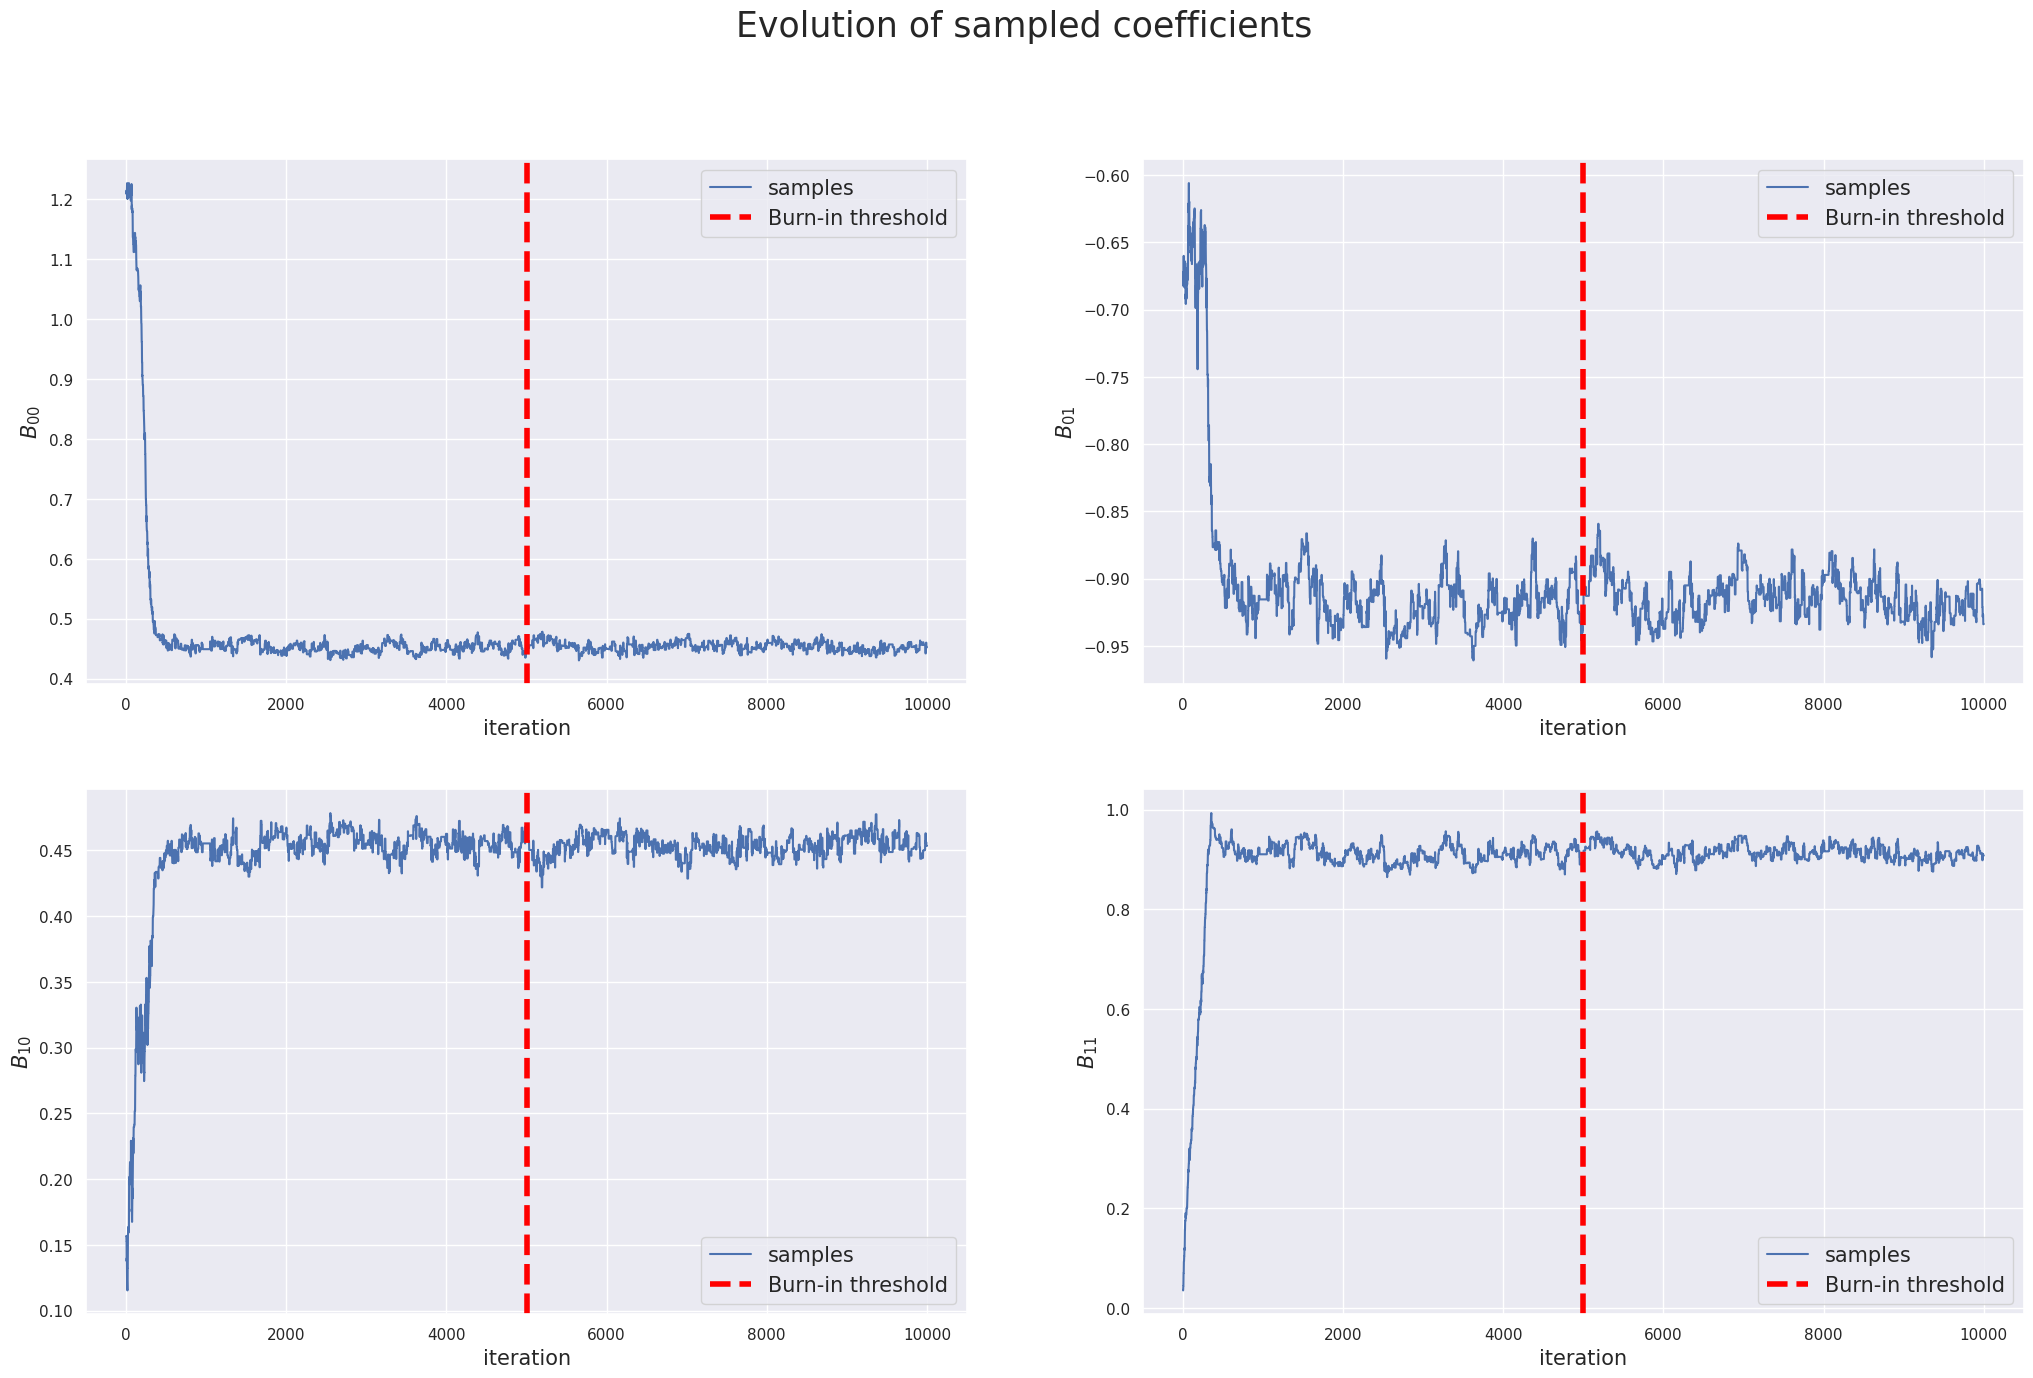

In [67]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of sampled coefficients',
    fontsize=25
)

# B_00
axs[0,0].plot(
    logs.iteration,
    samples[:, 0, 0],
    label='samples'
)
axs[0,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,0].set_ylabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].legend(
    fontsize=15
)

# B_01
axs[0,1].plot(
    logs.iteration,
    samples[:, 0, 1],
    label='samples'
)
axs[0,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].legend(
    fontsize=15
)

# B_10
axs[1,0].plot(
    logs.iteration,
    samples[:, 1, 0],
    label='samples'
)
axs[1,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,0].set_ylabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].legend(
    fontsize=15
)

# B_11
axs[1,1].plot(
    logs.iteration,
    samples[:, 1, 1],
    label='samples'
)
axs[1,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].legend(
    fontsize=15
)

### 2.4.4. Plot sampled coefficients distributions - Markov Chain evolution

<Axes: xlabel='B_11', ylabel='Density'>

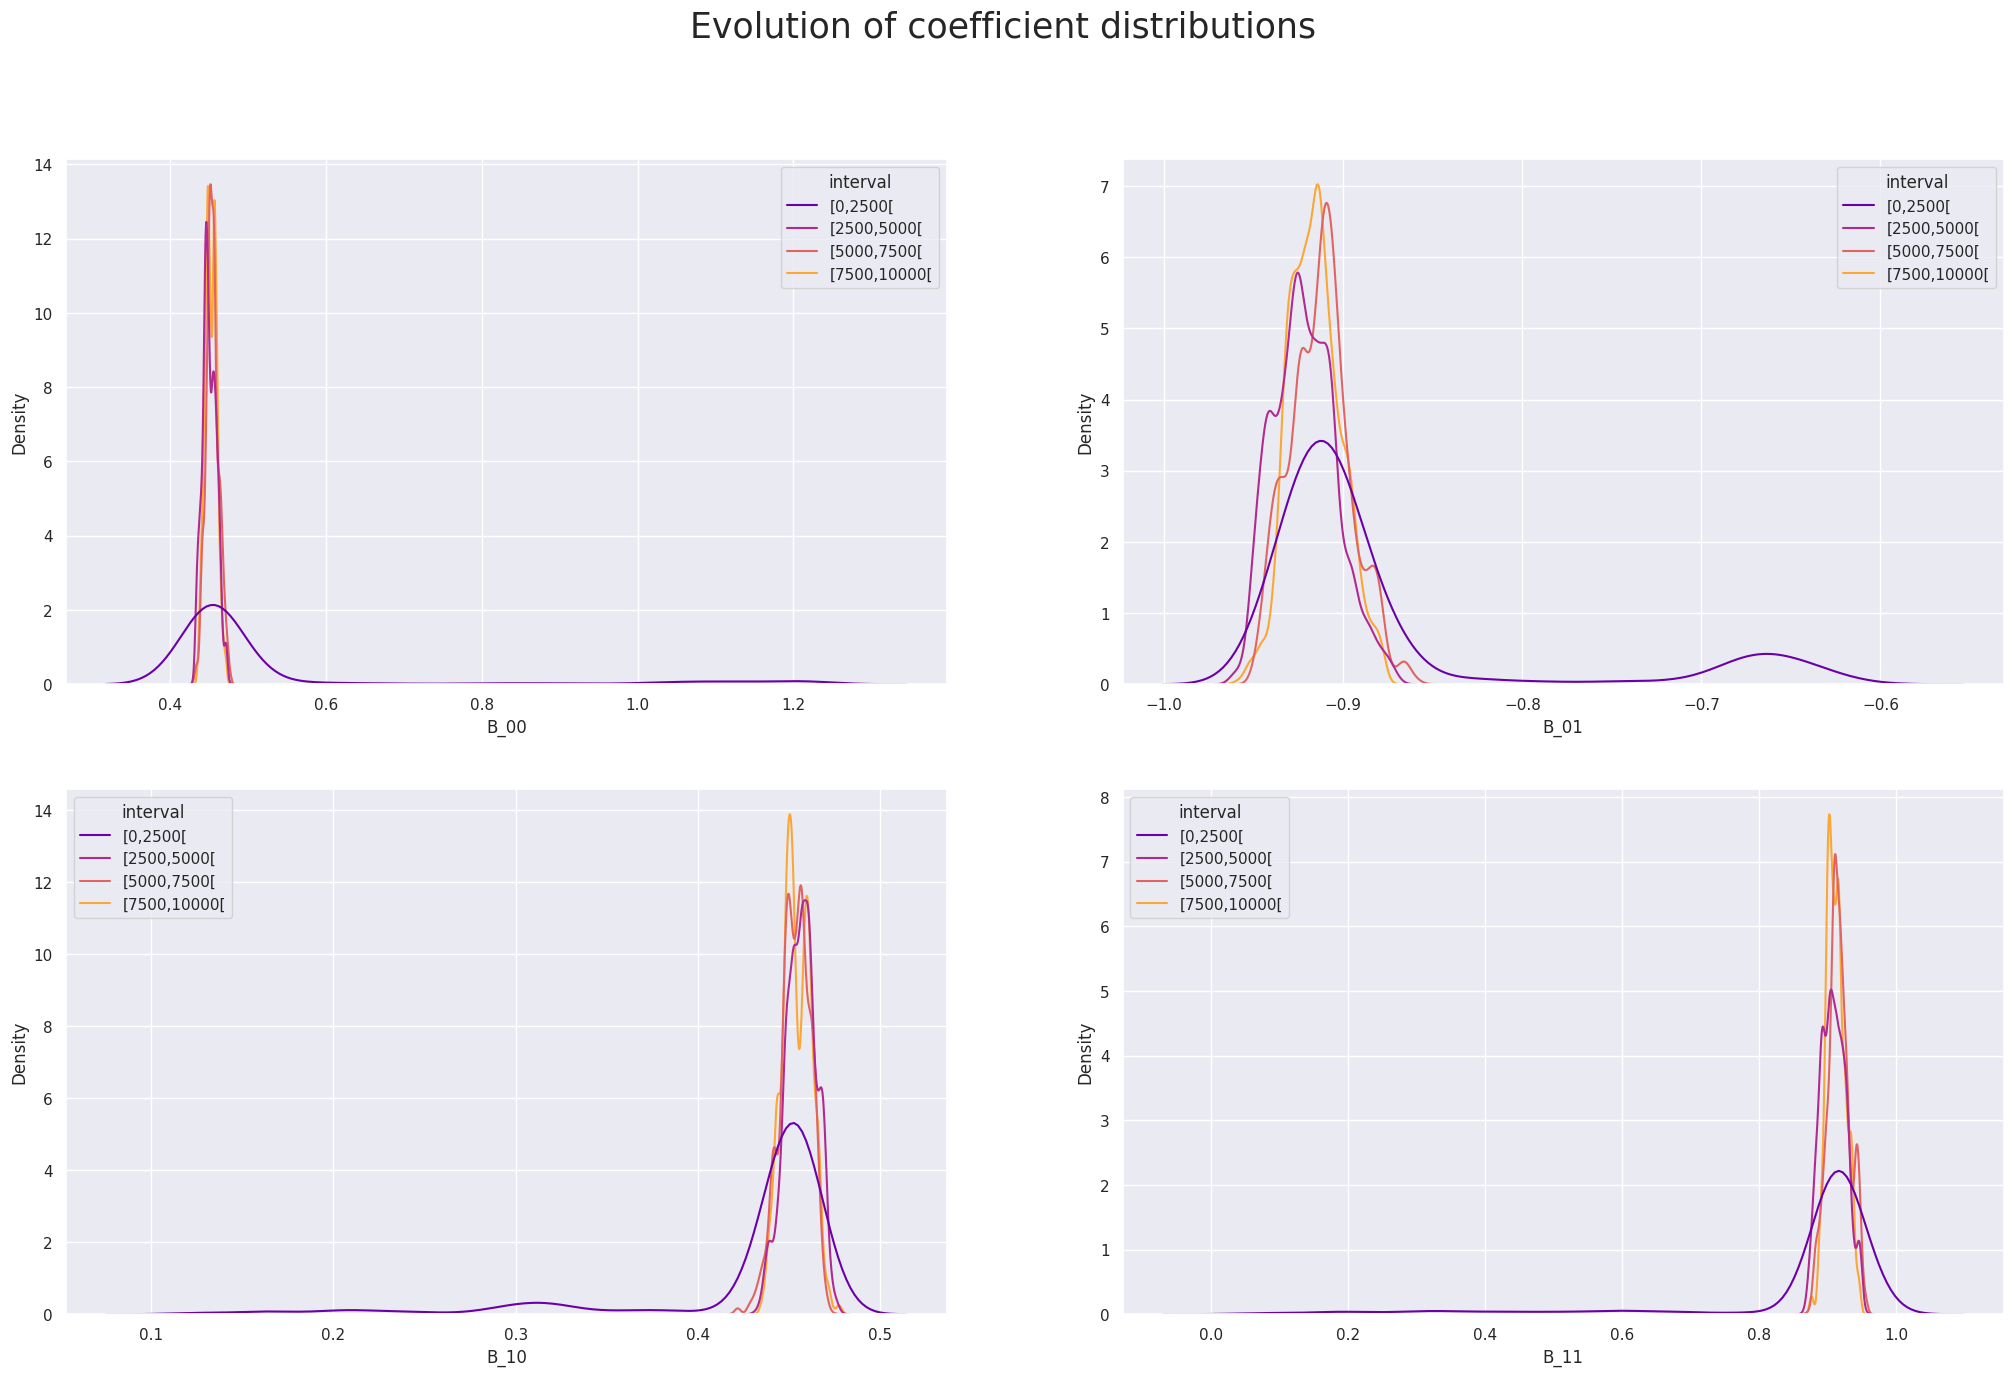

In [68]:
##############################
# Evolution of distributions #
##############################

# Get step size and evaluated points
STEP_SIZE=2500
PALETTE='plasma'

i=0
evaluated_intervals=[]
while i<N_SAMPLES:
    start=i
    end=min(
        i+STEP_SIZE,
        N_SAMPLES
    )
    evaluated_intervals.append(
        (start, end)
    )
    i = i + STEP_SIZE

# Window samples and construct dataframe for plotting
plot_df=pd.DataFrame()
for start, end in evaluated_intervals:
    wdw_df = pd.DataFrame(
        data={
            'interval': ['[{},{}['.format(start, end)]*(end-start)
        }
    )
    wdw_samples = samples[start:end,:,:]
    for i, j in np.ndindex(B_est.shape):
        wdw_df['B_{}{}'.format(i, j)] = wdw_samples[:,i,j]

    plot_df = pd.concat(
        [
            plot_df,
            wdw_df
        ],
        axis=0
    ).reset_index(
        drop=True
    )

# Plot coefficient distribution evolution
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of coefficient distributions',
    fontsize=25
)

# B_00
sns.kdeplot(
    data=plot_df,
    x='B_00',
    hue='interval',
    ax=axs[0,0],
    palette=PALETTE
)

# B_01
sns.kdeplot(
    data=plot_df,
    x='B_01',
    hue='interval',
    ax=axs[0,1],
    palette=PALETTE
)

# B_10
sns.kdeplot(
    data=plot_df,
    x='B_10',
    hue='interval',
    ax=axs[1,0],
    palette=PALETTE
)

# B_11
sns.kdeplot(
    data=plot_df,
    x='B_11',
    hue='interval',
    ax=axs[1,1],
    palette=PALETTE
)

### 2.4.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

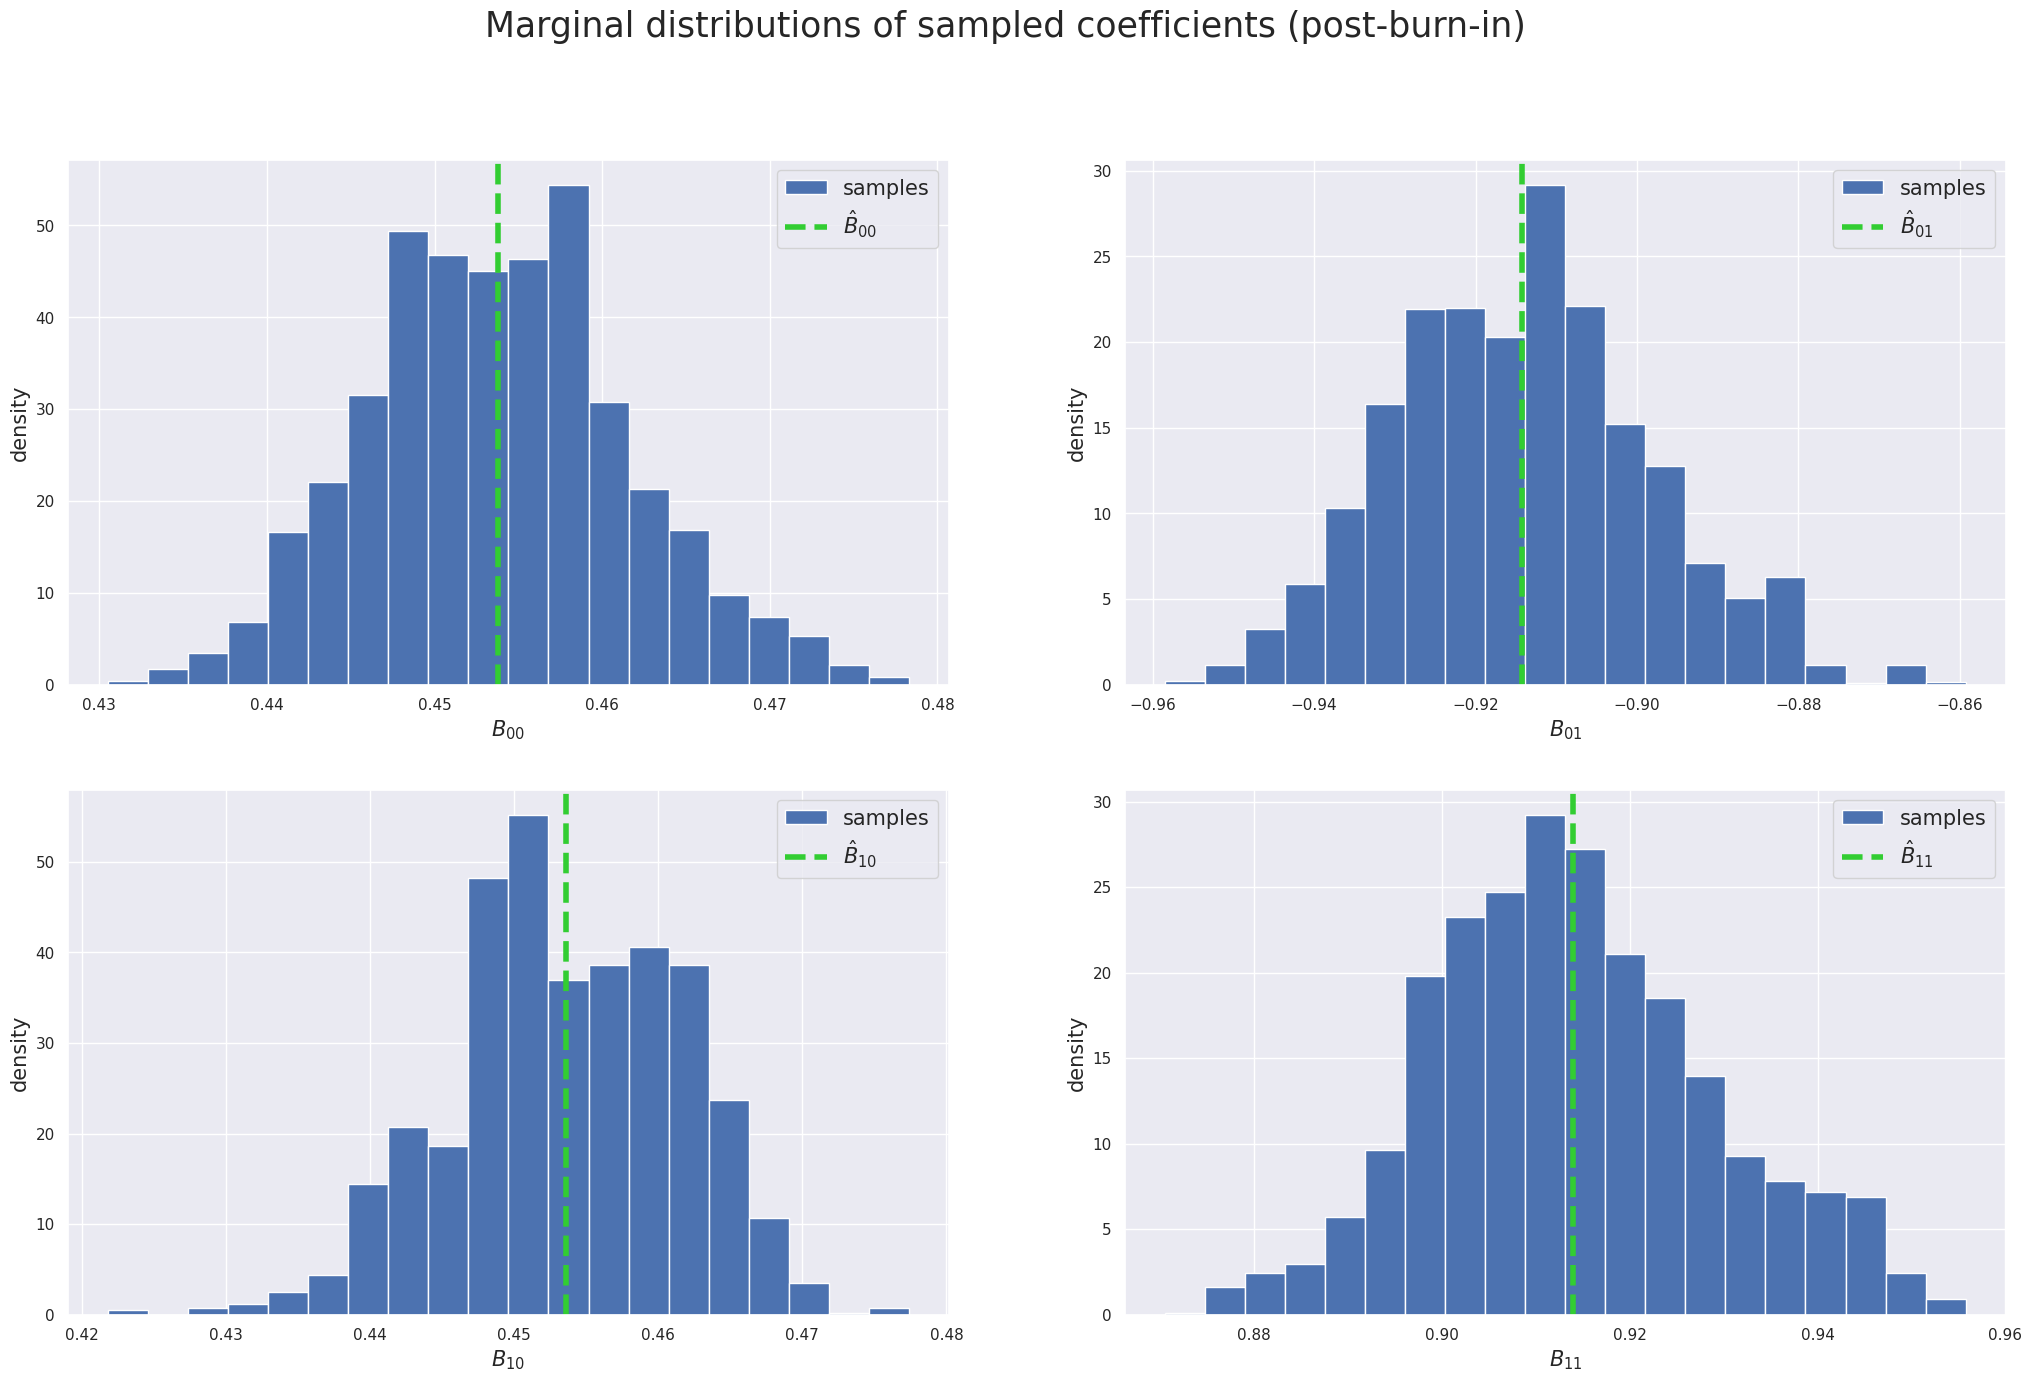

In [69]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Marginal distributions of sampled coefficients (post-burn-in)',
    fontsize=25
)

# B_00
axs[0,0].hist(
    valid_samples[:, 0, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,0].axvline(
    B_est[0, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{00}$'
)
axs[0,0].set_xlabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].set_ylabel(
    'density',
    fontsize=15
)
axs[0,0].legend(
    loc='upper right',
    fontsize=15
)


# B_01
axs[0,1].hist(
    valid_samples[:, 0, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,1].axvline(
    B_est[0, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{01}$'
)
axs[0,1].set_xlabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    'density',
    fontsize=15
)
axs[0,1].legend(
    loc='upper right',
    fontsize=15
)

# B_10
axs[1,0].hist(
    valid_samples[:, 1, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,0].axvline(
    B_est[1, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{10}$'
)
axs[1,0].set_xlabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].set_ylabel(
    'density',
    fontsize=15
)
axs[1,0].legend(
    loc='upper right',
    fontsize=15
)

# B_11
axs[1,1].hist(
    valid_samples[:, 1, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,1].axvline(
    B_est[1, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{11}$'
)
axs[1,1].set_xlabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    'density',
    fontsize=15
)
axs[1,1].legend(
    loc='upper right',
    fontsize=15
)

### 2.4.6. Plot evolution of log-posterior

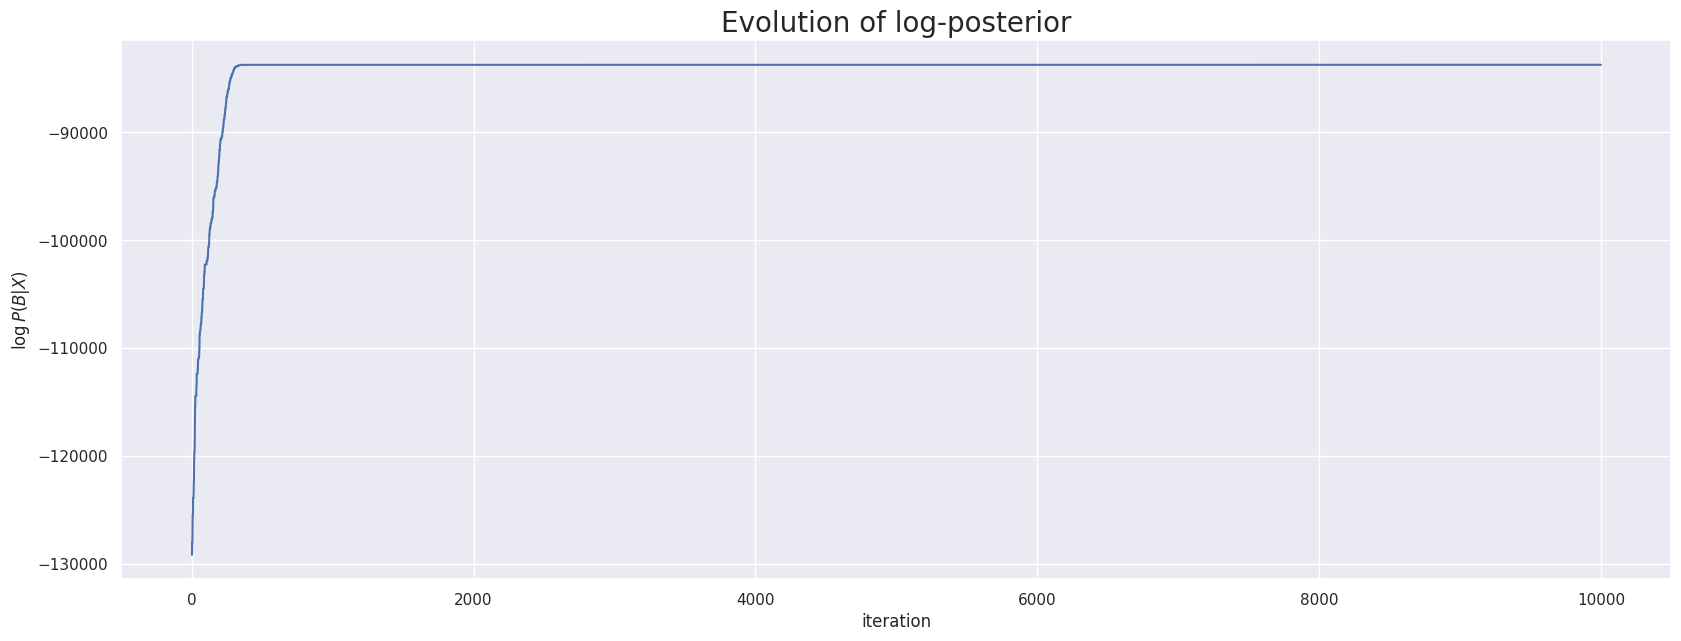

In [70]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posterior'
)
plt.ylabel(
    '$\log P(B|X)$'
)
t = plt.title(
    'Evolution of log-posterior',
    fontsize=20
)

### 2.4.7. Plot Source Separation Results

Text(0.5, 1.0, 'Scatter plot - true values and estimates - coefficient s1')

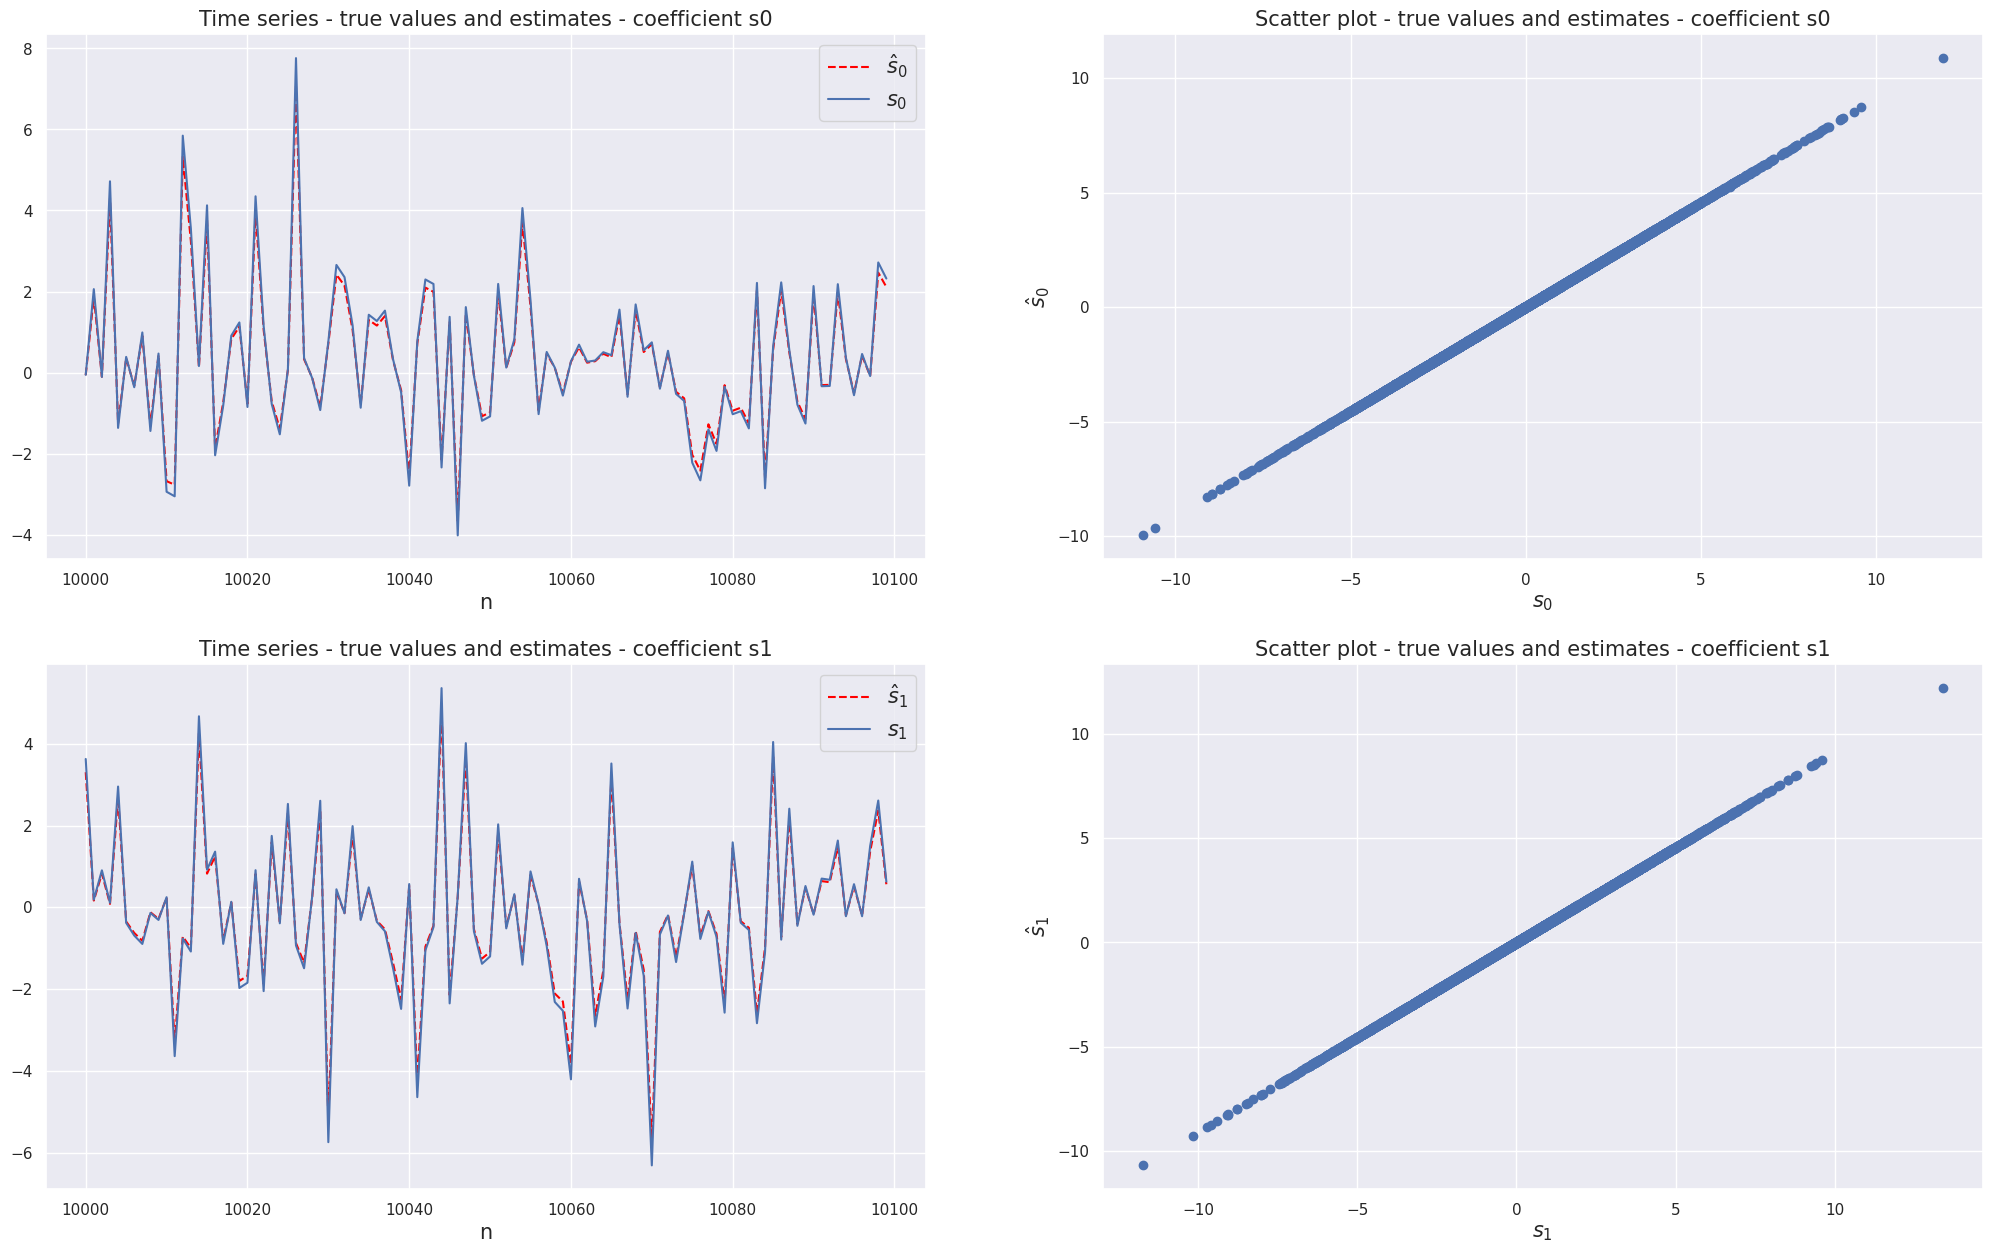

In [71]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B_est@x

# Axs 00
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
axs[0,0].set_xlabel(
    'n',
    fontsize=15
)
axs[0,0].set_title(
    'Time series - true values and estimates - coefficient s0',
    fontsize=15
)
axs[0,0].legend(fontsize=15)

# Axs 01
axs[0,1].scatter(
    s[0,:],
    s_est[0,:],
)
axs[0,1].set_xlabel(
    '$s_{0}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$\hat{s}_{0}$',
    fontsize=15
)
axs[0,1].set_title(
    'Scatter plot - true values and estimates - coefficient s0',
    fontsize=15
)

# Axs 10
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
axs[1,0].set_xlabel(
    'n',
    fontsize=15
)
axs[1,0].set_title(
    'Time series - true values and estimates - coefficient s1',
    fontsize=15
)
axs[1,0].legend(fontsize=15)

# Axs 11
axs[1,1].scatter(
    s[1,:],
    s_est[1,:],
)
axs[1,1].set_xlabel(
    '$s_{1}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$\hat{s}_{1}$',
    fontsize=15
)
axs[1,1].set_title(
    'Scatter plot - true values and estimates - coefficient s1',
    fontsize=15
)

In [72]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['slightly_misspecified']['determinant_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.0008890541935622762


## 2.5. Perform Analysis - near-identity transformation
#### Prior:
#### $p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} ||\boldsymbol{B} - \boldsymbol{I}||^2 \right]$

### 1.5.1 Execute MCMC Sampling

In [73]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(X):
    sig=0.1
    return np.exp(
        (-1/2/np.square(sig))*np.linalg.norm(X-np.eye(X.shape[0]))
    )

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [74]:
%%time

SAVE_PATH='./artifacts/slightly_misspecified_model/identity.pkl'
if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(estimator, f)

else:
    # Read artifact
    with open(SAVE_PATH, 'rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 8.19 ms, sys: 8.05 ms, total: 16.2 ms
Wall time: 43.7 ms


### 2.5.2. Parse MCMC Results

In [75]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 0
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [76]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.45423304 -0.9122111 ]
 [ 0.45309519  0.91566496]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [77]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-83724.49558604587,
 -83724.59837249646,
 -83724.49484134465,
 -83724.49586851447,
 -83724.46811382515,
 -83724.4750293591,
 -83724.5334430139,
 -83724.50387179336,
 -83724.52935962827,
 -83724.49498823544,
 -83724.49071779985,
 -83724.5472297324,
 -83724.59851292803,
 -83724.483398337,
 -83724.50741074413,
 -83724.55102410576,
 -83724.47346552617,
 -83724.46940351216,
 -83724.50776202766,
 -83724.5359672211,
 -83724.52155651816,
 -83724.6081123812,
 -83724.51774511425,
 -83724.5334000749,
 -83724.48938155672,
 -83724.49787423045,
 -83724.51978652667,
 -83724.50665006555,
 -83724.53558554925,
 -83724.50011075655]

In [78]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.45423304, -0.9122111 ],
        [ 0.45309519,  0.91566496]]),
 array([[ 0.45486073, -0.91165164],
        [ 0.45260997,  0.91601045]]),
 array([[-0.45328379,  0.91537718],
        [-0.45397076, -0.91250355]]),
 array([[ 0.45394612,  0.91376819],
        [-0.4533006 ,  0.91563288]]),
 array([[-0.454698  , -0.91131233],
        [ 0.45253267, -0.91623376]]),
 array([[ 0.45517118, -0.91039763],
        [-0.4518512 , -0.91696915]]),
 array([[ 0.45558859,  0.90894715],
        [-0.45157031,  0.91827936]]),
 array([[-0.45159976, -0.9174149 ],
        [ 0.45530087, -0.91027444]]),
 array([[-0.45380654,  0.91329982],
        [-0.45333394, -0.91401594]]),
 array([[-0.45538   , -0.90939841],
        [-0.45214857,  0.91733804]]),
 array([[ 0.45251059, -0.91540907],
        [ 0.45437906,  0.91222048]]),
 array([[-0.45274446, -0.91580309],
        [ 0.45443893, -0.91248928]]),
 array([[-0.45409849,  0.91265865],
        [ 0.45293487,  0.91517629]]),
 array([[-0.45305376,  0.9145045 ],
  

### 2.5.3. Plot sampled coefficients stochastic process - Markov Chain evolution

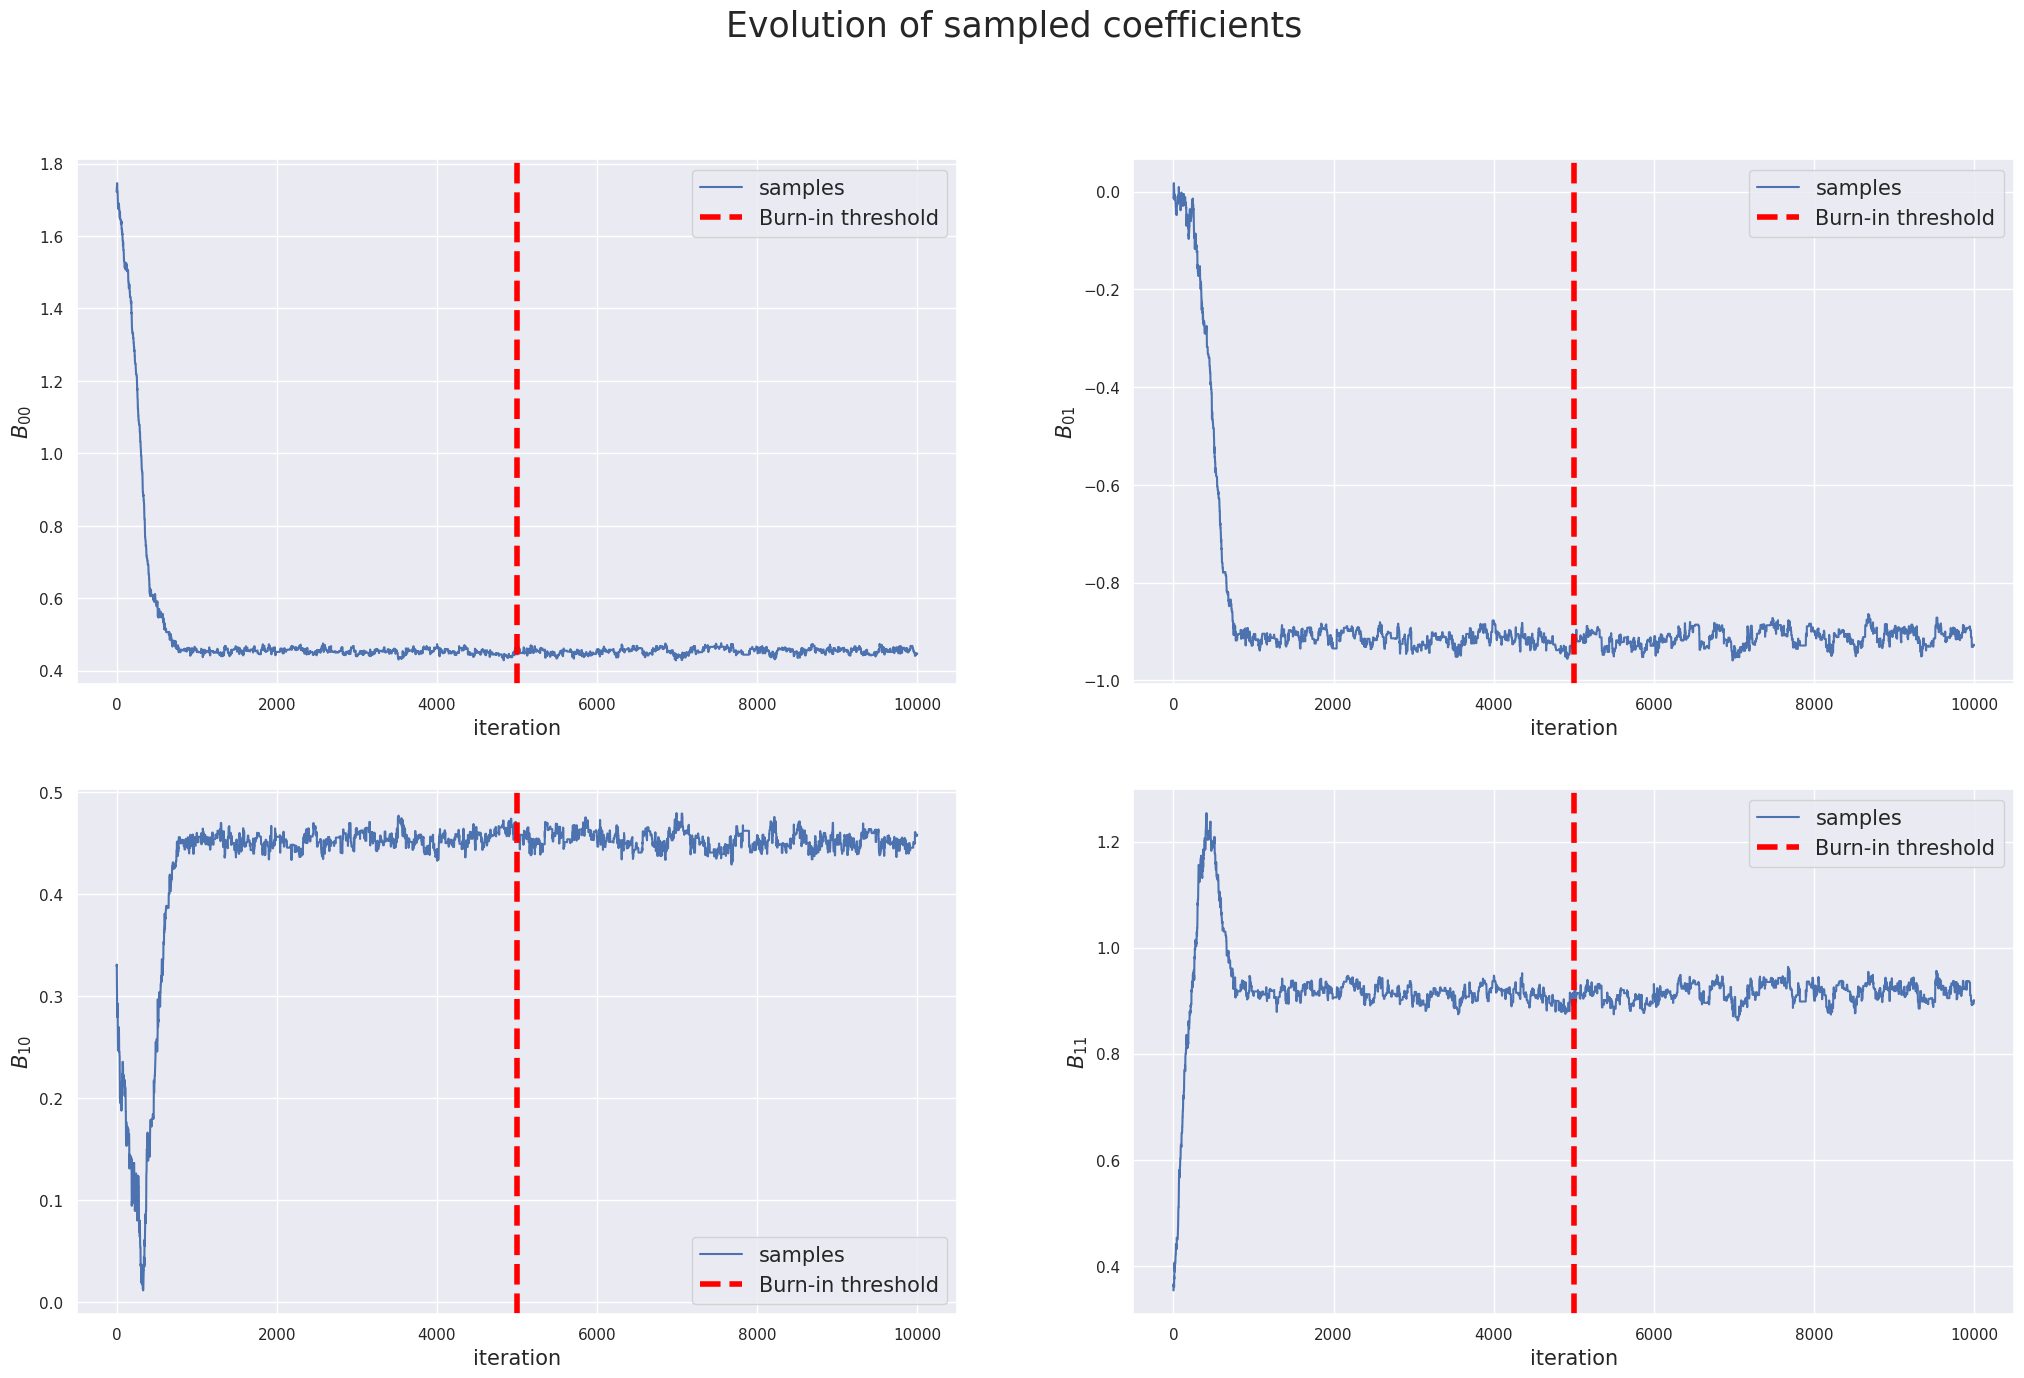

In [79]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of sampled coefficients',
    fontsize=25
)

# B_00
axs[0,0].plot(
    logs.iteration,
    samples[:, 0, 0],
    label='samples'
)
axs[0,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,0].set_ylabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].legend(
    fontsize=15
)

# B_01
axs[0,1].plot(
    logs.iteration,
    samples[:, 0, 1],
    label='samples'
)
axs[0,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[0,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].legend(
    fontsize=15
)

# B_10
axs[1,0].plot(
    logs.iteration,
    samples[:, 1, 0],
    label='samples'
)
axs[1,0].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,0].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,0].set_ylabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].legend(
    fontsize=15
)

# B_11
axs[1,1].plot(
    logs.iteration,
    samples[:, 1, 1],
    label='samples'
)
axs[1,1].axvline(
    estimator.burn_in_start,
    color='red',
    linestyle='--',
    linewidth=4,
    label='Burn-in threshold'
)
axs[1,1].set_xlabel(
    'iteration',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].legend(
    fontsize=15
)

### 2.5.4. Plot sampled coefficients distributions - Markov Chain evolution

<Axes: xlabel='B_11', ylabel='Density'>

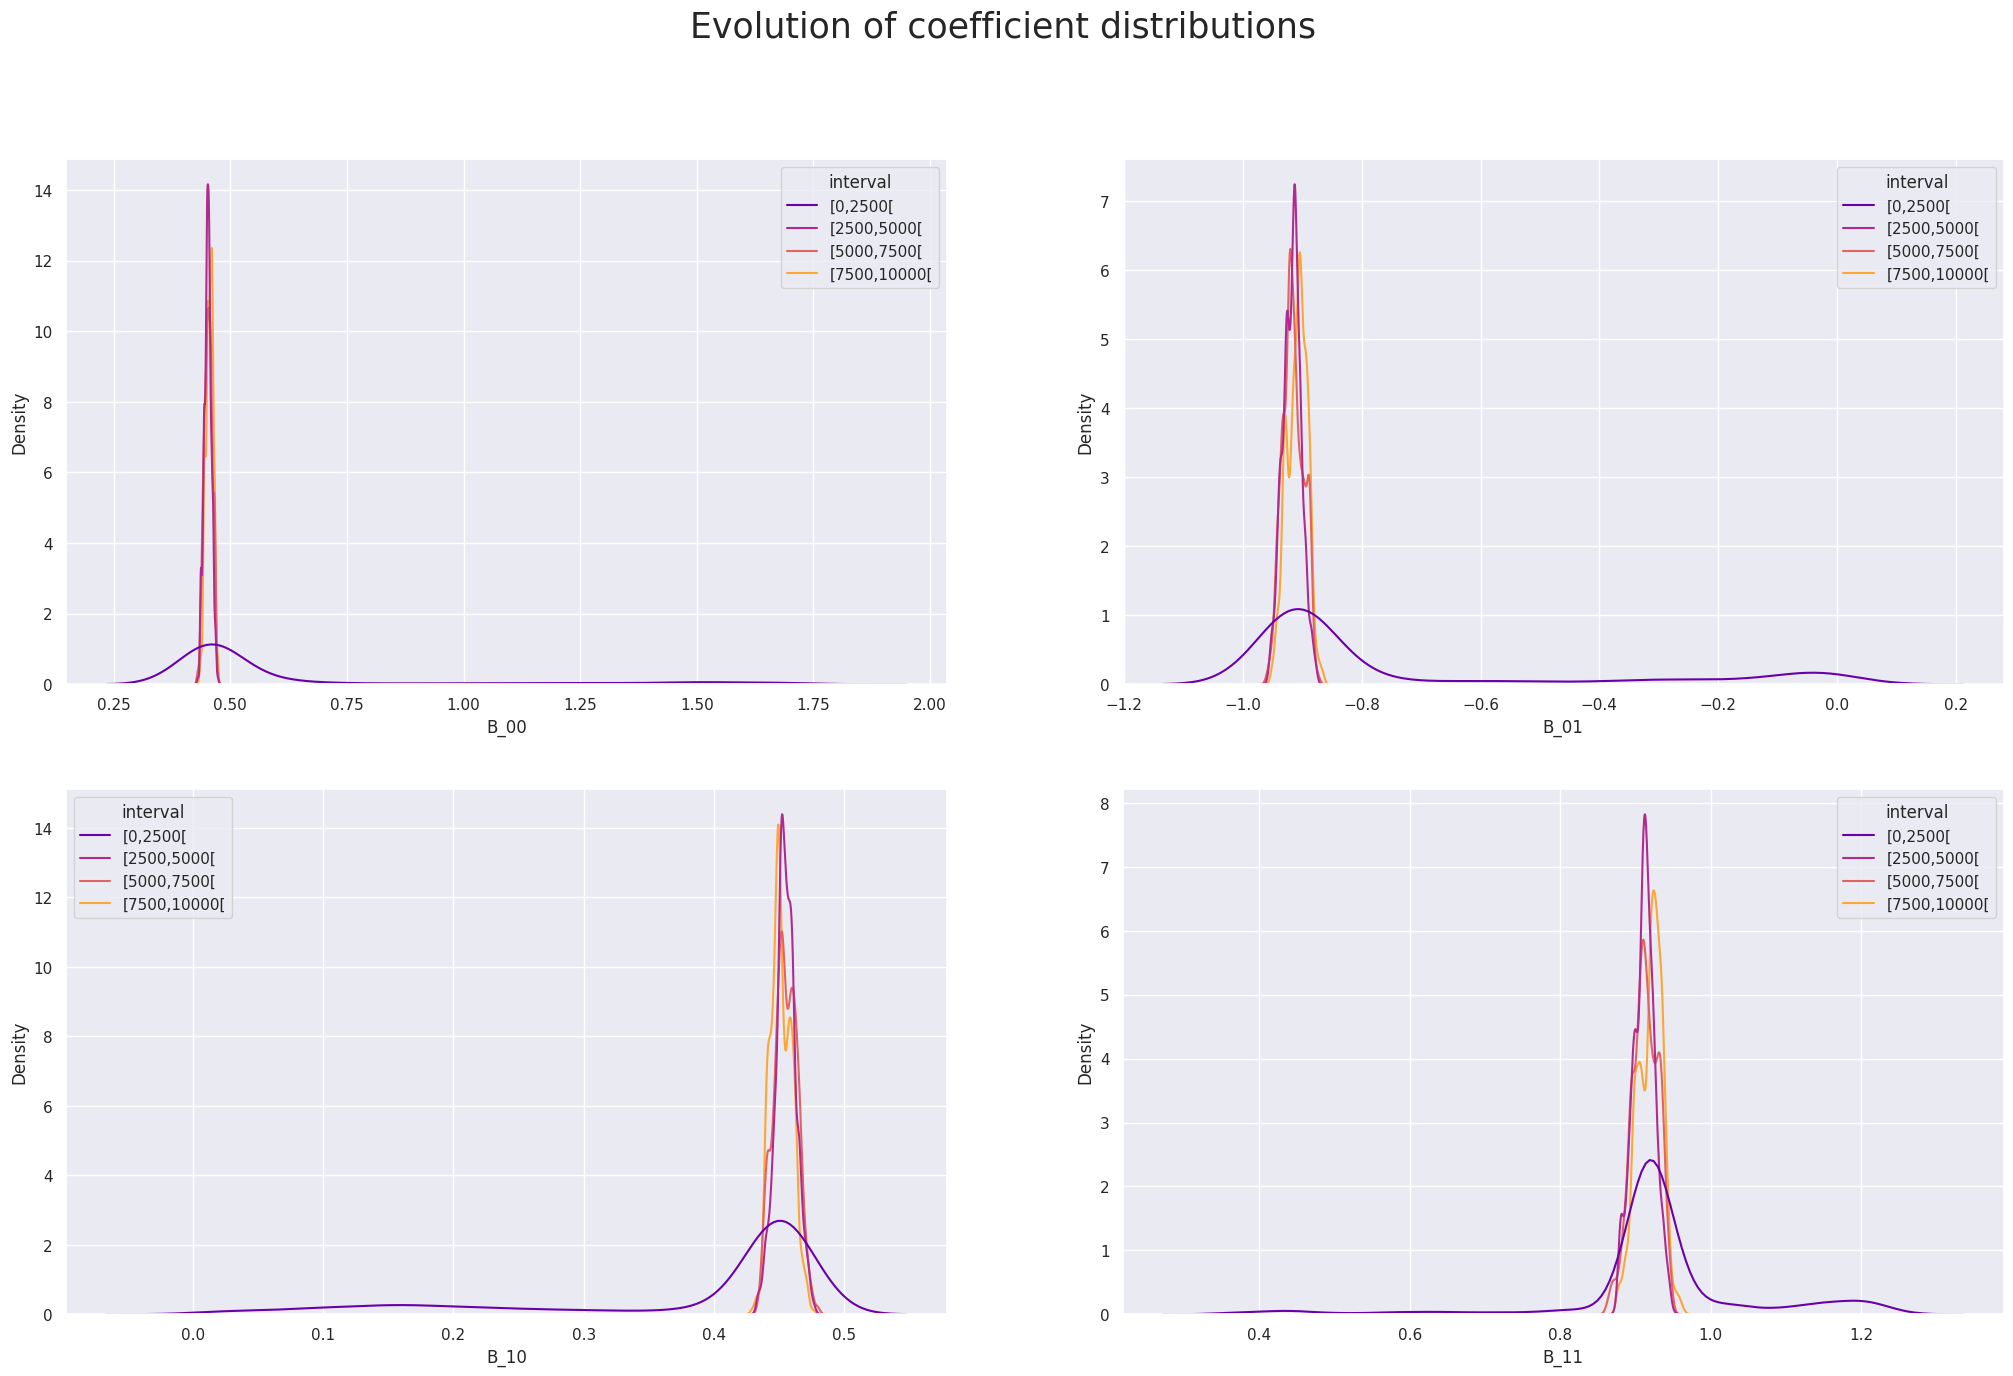

In [80]:
##############################
# Evolution of distributions #
##############################

# Get step size and evaluated points
STEP_SIZE=2500
PALETTE='plasma'

i=0
evaluated_intervals=[]
while i<N_SAMPLES:
    start=i
    end=min(
        i+STEP_SIZE,
        N_SAMPLES
    )
    evaluated_intervals.append(
        (start, end)
    )
    i = i + STEP_SIZE

# Window samples and construct dataframe for plotting
plot_df=pd.DataFrame()
for start, end in evaluated_intervals:
    wdw_df = pd.DataFrame(
        data={
            'interval': ['[{},{}['.format(start, end)]*(end-start)
        }
    )
    wdw_samples = samples[start:end,:,:]
    for i, j in np.ndindex(B_est.shape):
        wdw_df['B_{}{}'.format(i, j)] = wdw_samples[:,i,j]

    plot_df = pd.concat(
        [
            plot_df,
            wdw_df
        ],
        axis=0
    ).reset_index(
        drop=True
    )

# Plot coefficient distribution evolution
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Evolution of coefficient distributions',
    fontsize=25
)

# B_00
sns.kdeplot(
    data=plot_df,
    x='B_00',
    hue='interval',
    ax=axs[0,0],
    palette=PALETTE
)

# B_01
sns.kdeplot(
    data=plot_df,
    x='B_01',
    hue='interval',
    ax=axs[0,1],
    palette=PALETTE
)

# B_10
sns.kdeplot(
    data=plot_df,
    x='B_10',
    hue='interval',
    ax=axs[1,0],
    palette=PALETTE
)

# B_11
sns.kdeplot(
    data=plot_df,
    x='B_11',
    hue='interval',
    ax=axs[1,1],
    palette=PALETTE
)

### 2.5.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

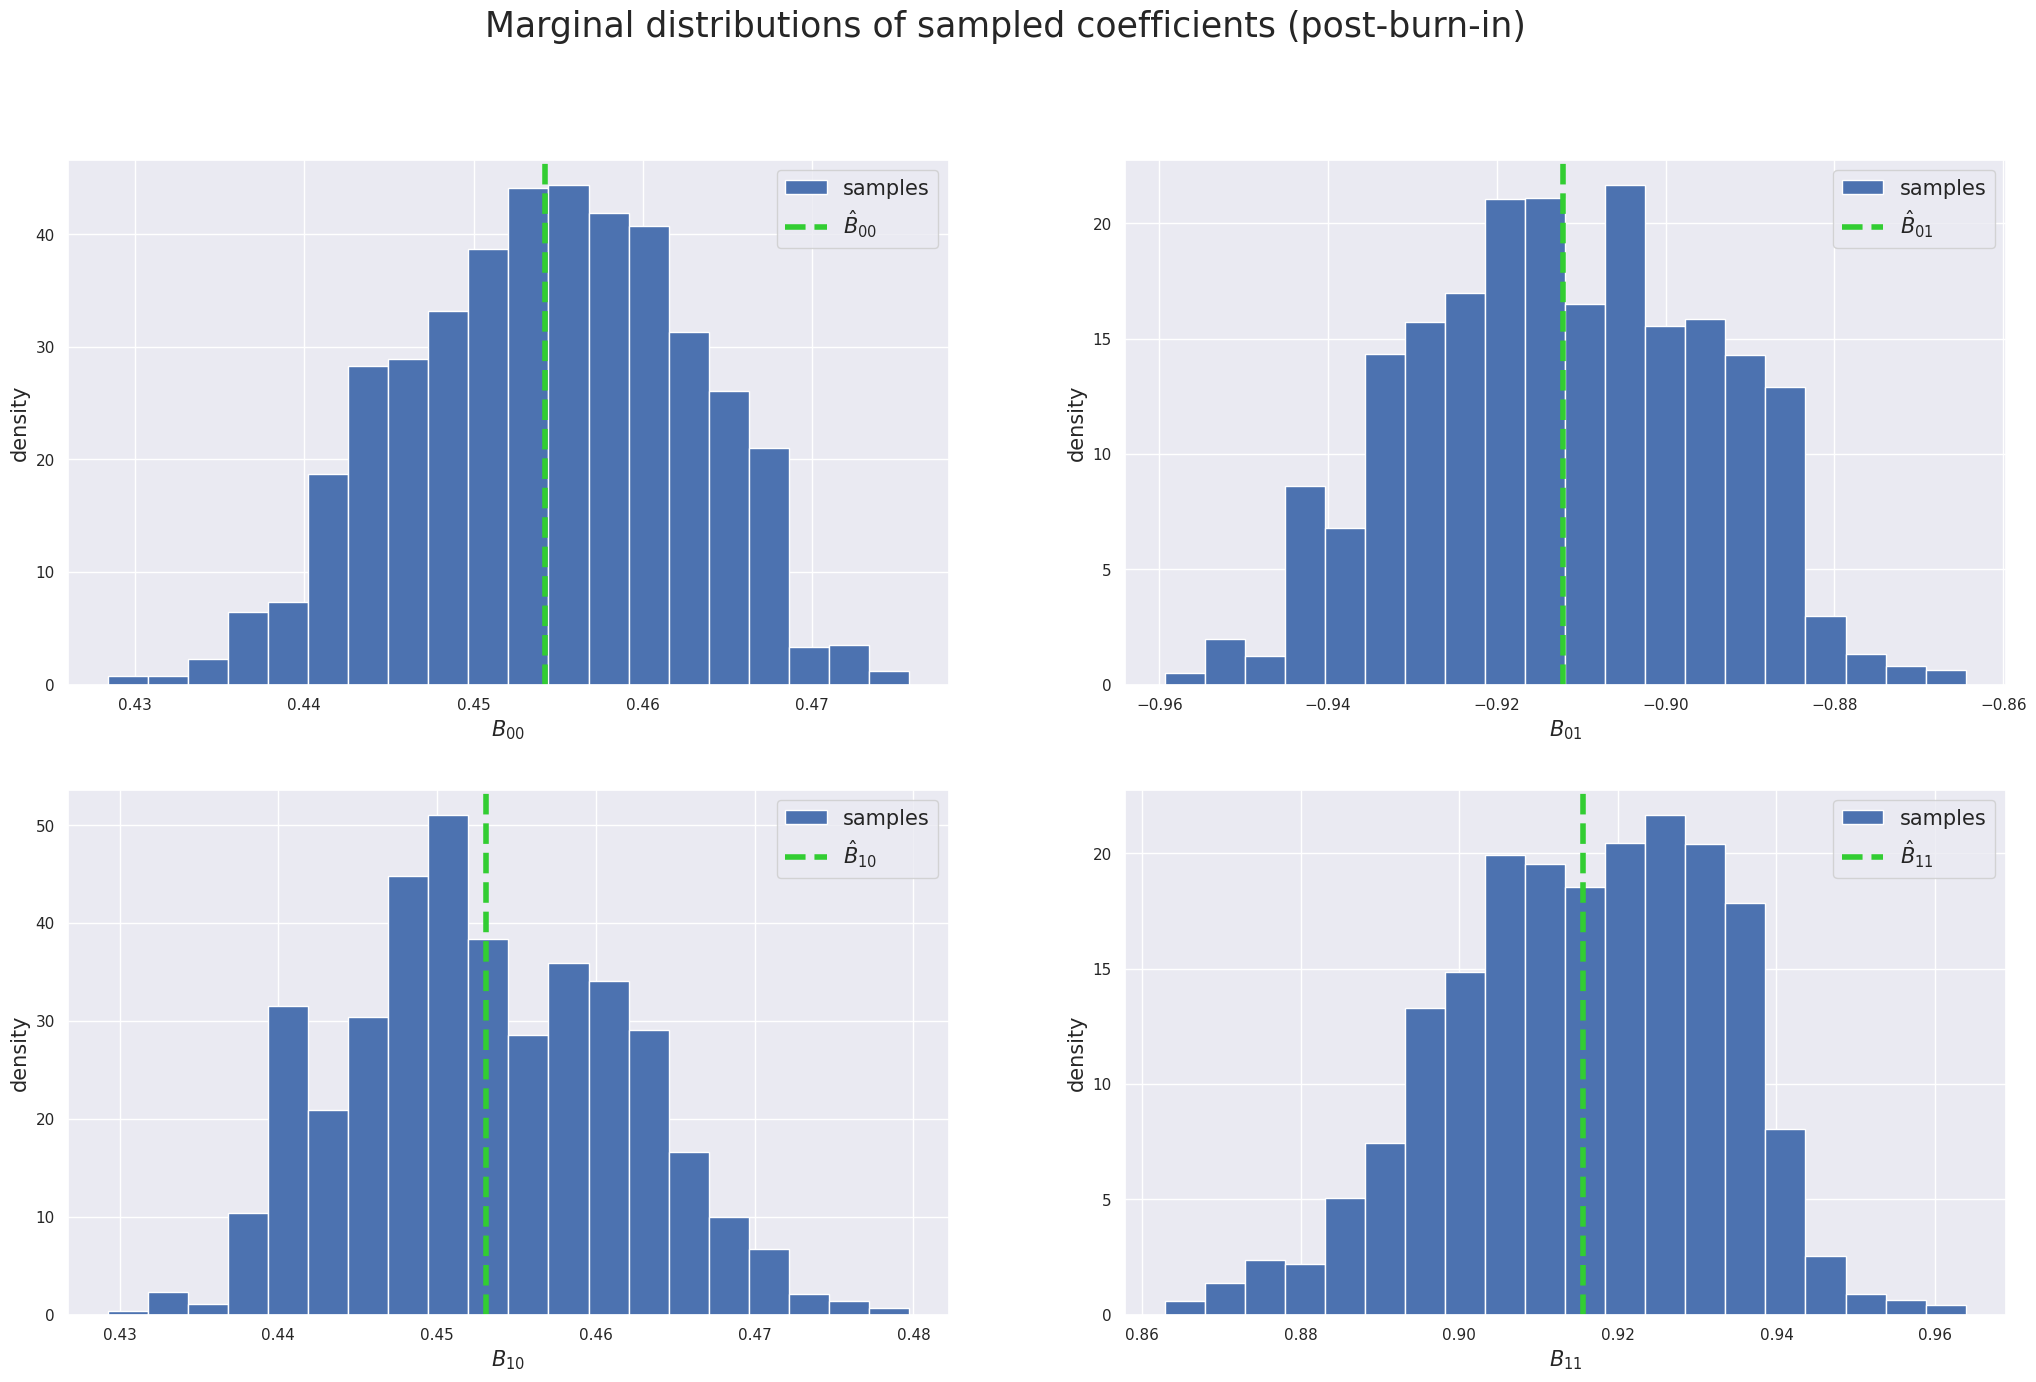

In [81]:
# Plot sampled coefficients
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)

fig.suptitle(
    'Marginal distributions of sampled coefficients (post-burn-in)',
    fontsize=25
)

# B_00
axs[0,0].hist(
    valid_samples[:, 0, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,0].axvline(
    B_est[0, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{00}$'
)
axs[0,0].set_xlabel(
    '$B_{00}$',
    fontsize=15
)
axs[0,0].set_ylabel(
    'density',
    fontsize=15
)
axs[0,0].legend(
    loc='upper right',
    fontsize=15
)


# B_01
axs[0,1].hist(
    valid_samples[:, 0, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[0,1].axvline(
    B_est[0, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{01}$'
)
axs[0,1].set_xlabel(
    '$B_{01}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    'density',
    fontsize=15
)
axs[0,1].legend(
    loc='upper right',
    fontsize=15
)

# B_10
axs[1,0].hist(
    valid_samples[:, 1, 0],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,0].axvline(
    B_est[1, 0],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{10}$'
)
axs[1,0].set_xlabel(
    '$B_{10}$',
    fontsize=15
)
axs[1,0].set_ylabel(
    'density',
    fontsize=15
)
axs[1,0].legend(
    loc='upper right',
    fontsize=15
)

# B_11
axs[1,1].hist(
    valid_samples[:, 1, 1],
    density=True,
    bins=NBINS,
    label='samples'
)
axs[1,1].axvline(
    B_est[1, 1],
    color='limegreen',
    linestyle='--',
    linewidth=4,
    label='$\hat{B}_{11}$'
)
axs[1,1].set_xlabel(
    '$B_{11}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    'density',
    fontsize=15
)
axs[1,1].legend(
    loc='upper right',
    fontsize=15
)

### 2.5.6. Plot evolution of log-posterior

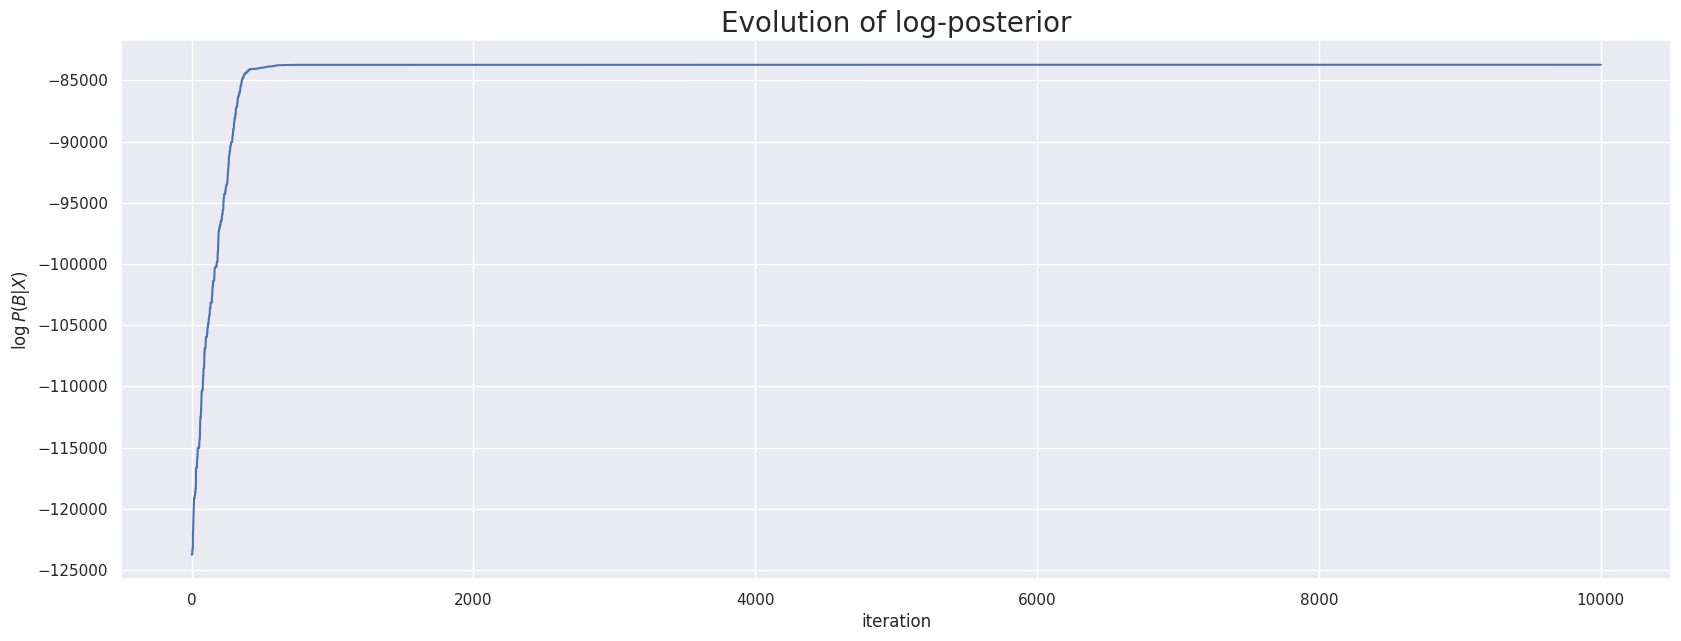

In [82]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posterior'
)
plt.ylabel(
    '$\log P(B|X)$'
)
t = plt.title(
    'Evolution of log-posterior',
    fontsize=20
)

### 2.5.7. Plot Source Separation Results

Text(0.5, 1.0, 'Scatter plot - true values and estimates - coefficient s1')

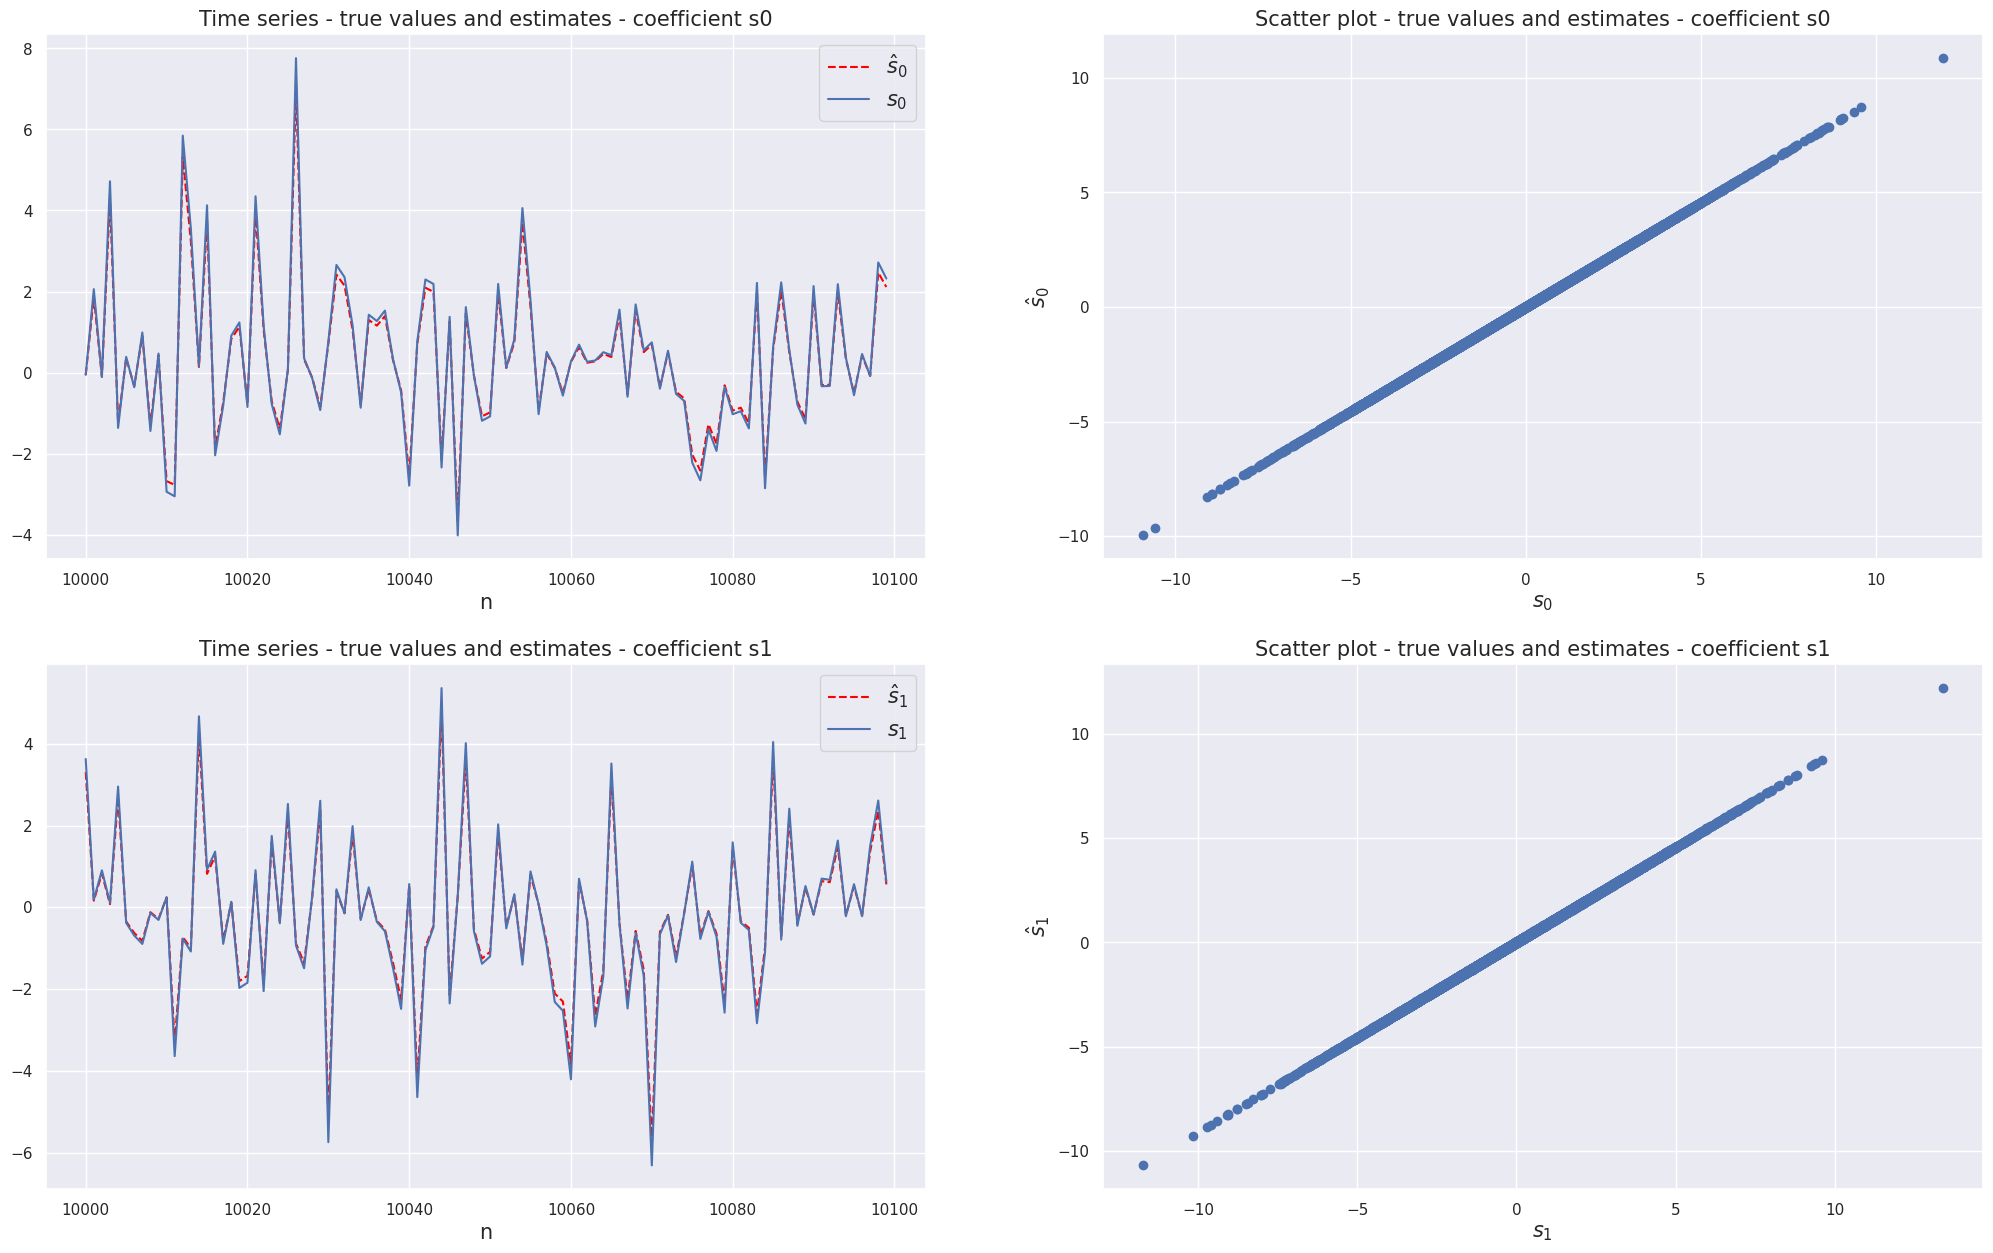

In [83]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(25,15)
)
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B_est@x

# Axs 00
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
axs[0,0].plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
axs[0,0].set_xlabel(
    'n',
    fontsize=15
)
axs[0,0].set_title(
    'Time series - true values and estimates - coefficient s0',
    fontsize=15
)
axs[0,0].legend(fontsize=15)

# Axs 01
axs[0,1].scatter(
    s[0,:],
    s_est[0,:],
)
axs[0,1].set_xlabel(
    '$s_{0}$',
    fontsize=15
)
axs[0,1].set_ylabel(
    '$\hat{s}_{0}$',
    fontsize=15
)
axs[0,1].set_title(
    'Scatter plot - true values and estimates - coefficient s0',
    fontsize=15
)

# Axs 10
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
axs[1,0].plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
axs[1,0].set_xlabel(
    'n',
    fontsize=15
)
axs[1,0].set_title(
    'Time series - true values and estimates - coefficient s1',
    fontsize=15
)
axs[1,0].legend(fontsize=15)

# Axs 11
axs[1,1].scatter(
    s[1,:],
    s_est[1,:],
)
axs[1,1].set_xlabel(
    '$s_{1}$',
    fontsize=15
)
axs[1,1].set_ylabel(
    '$\hat{s}_{1}$',
    fontsize=15
)
axs[1,1].set_title(
    'Scatter plot - true values and estimates - coefficient s1',
    fontsize=15
)

In [84]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['slightly_misspecified']['near_identity_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.0008901962352631327


In [85]:
pprint.pp(errors)

{'perfect_model': {'likelihood': 8.505339686882418e-05,
                   'determinant_prior': 7.138954695596025e-05,
                   'near_identity_prior': 0.012787920379307767},
 'slightly_misspecified': {'likelihood': 0.0008908940717477854,
                           'determinant_prior': 0.0008890541935622762,
                           'near_identity_prior': 0.0008901962352631327}}
